In [125]:
DATASET_DIR = ''
SAVE_DIR = './'

import os
import pandas as pd
import keras
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras import backend as K

environment='L'


In [126]:

if environment == 'S':
    os.environ["CUDA_VISIBLE_DEVICES"] = '1'  
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth =\
        True
    sess = tf.Session(config=config)
    keras.backend.set_session(sess)
elif environment == 'L':
    os.chdir("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source")

In [117]:


X = pd.read_csv(os.path.join(DATASET_DIR, 'essay_set1_merged.csv'), encoding='ISO-8859-1')
#X = (X[(X["essay_set"] == 1) | (X["essay_set"] == 2)])
X = (X[(X["essay_set"] == 1)])
print(X.columns)
#y = X[[ 'domain1_score', 'Content',
#       'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions']]
y_domain_score=X[['rater1_domain1']]
y_content=X[['Content']]
y_organization=X[['Organization']]
y_wordChoice=X[['Word Choice']]
y_sentenceFluency=X[['Sentence Fluency']]
y_conventions=X[['Conventions']]
  
  
X = X.dropna(axis=1)
os.chdir("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source")


Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'Content',
       'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions'],
      dtype='object')


Preprocessing the Data
We will preprocess all essays and convert them to feature vectors so that they can be fed into the RNN.

These are all helper functions used to clean the essays.

In [118]:
minimum_scores = [-1, 2, 1, 0, 0, 0, 0, 0, 0]
maximum_scores = [-1, 12, 6, 3, 3, 4, 4, 30, 60]

import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs


Defining the model
Here we define a 2-Layer LSTM Model.

Note that instead of using sigmoid activation in the output layer we will use Relu since we are not normalising training labels.



In [122]:

from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K
from keras.utils.np_utils import to_categorical
from keras.layers import Input
from keras.models import Model

def get_model():
    """Define the model.""" 
    inputs = Input(shape=(1, 300))
    extract = LSTM(300, return_sequences=True)(inputs)
    class11 = LSTM(64)(extract)
    output1 = Dense(7, activation='sigmoid')(class11)
    output2 = Dense(7, activation='sigmoid')(class11)
    output3 = Dense(7, activation='sigmoid')(class11)
    output4 = Dense(7, activation='sigmoid')(class11)
    output5 = Dense(7, activation='sigmoid')(class11)
    output6 = Dense(7, activation='sigmoid')(class11)

    model = Model(inputs=inputs,outputs=[output1,output2,output3,output4,output5,output6])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model


Training Phase
Now we train the model on the dataset.

We will use 5-Fold Cross Validation and measure the Quadratic Weighted Kappa for each fold. We will then calculate Average Kappa for all the folds.

(1783, 9)


Training Word2Vec Model...


/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


trainDataVecs(1783, 300)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 300)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 1, 300)       721200      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 64)           93440       lstm_1[0][0]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 7)            455         lstm_2[0][0]                     
__________________________________________________________________________________________________
dense_2 (D

Train on 1426 samples, validate on 357 samples
Epoch 1/50


  64/1426 [>.............................] - ETA: 59s - loss: 4.1590 - dense_1_loss: 0.6934 - dense_2_loss: 0.6935 - dense_3_loss: 0.6927 - dense_4_loss: 0.6932 - dense_5_loss: 0.6931 - dense_6_loss: 0.6930 - dense_1_acc: 0.3281 - dense_2_acc: 0.3951 - dense_3_acc: 0.7567 - dense_4_acc: 0.4888 - dense_5_acc: 0.4821 - dense_6_acc: 0.5915

 128/1426 [=>............................] - ETA: 28s - loss: 4.1555 - dense_1_loss: 0.6928 - dense_2_loss: 0.6928 - dense_3_loss: 0.6922 - dense_4_loss: 0.6927 - dense_5_loss: 0.6925 - dense_6_loss: 0.6923 - dense_1_acc: 0.5190 - dense_2_acc: 0.5379 - dense_3_acc: 0.7980 - dense_4_acc: 0.6004 - dense_5_acc: 0.6663 - dense_6_acc: 0.6853

 256/1426 [====>.........................] - ETA: 13s - loss: 4.1484 - dense_1_loss: 0.6915 - dense_2_loss: 0.6915 - dense_3_loss: 0.6912 - dense_4_loss: 0.6918 - dense_5_loss: 0.6914 - dense_6_loss: 0.6910 - dense_1_acc: 0.6334 - dense_2_acc: 0.6970 - dense_3_acc: 0.8270 - dense_4_acc: 0.6758 - dense_5_acc: 0.7617 - dense_6_acc: 0.7478

 384/1426 [=======>......................] - ETA: 8s - loss: 4.1403 - dense_1_loss: 0.6901 - dense_2_loss: 0.6900 - dense_3_loss: 0.6901 - dense_4_loss: 0.6907 - dense_5_loss: 0.6900 - dense_6_loss: 0.6894 - dense_1_acc: 0.6715 - dense_2_acc: 0.7504 - dense_3_acc: 0.8371 - dense_4_acc: 0.7109 - dense_5_acc: 0.7935 - dense_6_acc: 0.7716 

 512/1426 [=========>....................] - ETA: 5s - loss: 4.1310 - dense_1_loss: 0.6885 - dense_2_loss: 0.6882 - dense_3_loss: 0.6887 - dense_4_loss: 0.6894 - dense_5_loss: 0.6885 - dense_6_loss: 0.6877 - dense_1_acc: 0.6883 - dense_2_acc: 0.7771 - dense_3_acc: 0.8421 - dense_4_acc: 0.7453 - dense_5_acc: 0.8094 - dense_6_acc: 0.7796

 640/1426 [============>.................] - ETA: 3s - loss: 4.1199 - dense_1_loss: 0.6864 - dense_2_loss: 0.6863 - dense_3_loss: 0.6871 - dense_4_loss: 0.6878 - dense_5_loss: 0.6867 - dense_6_loss: 0.6855 - dense_1_acc: 0.7029 - dense_2_acc: 0.7931 - dense_3_acc: 0.8451 - dense_4_acc: 0.7674 - dense_5_acc: 0.8190 - dense_6_acc: 0.7853

 768/1426 [===============>..............] - ETA: 2s - loss: 4.1066 - dense_1_loss: 0.6841 - dense_2_loss: 0.6838 - dense_3_loss: 0.6852 - dense_4_loss: 0.6859 - dense_5_loss: 0.6847 - dense_6_loss: 0.6829 - dense_1_acc: 0.7111 - dense_2_acc: 0.8038 - dense_3_acc: 0.8471 - dense_4_acc: 0.7824 - dense_5_acc: 0.8253 - dense_6_acc: 0.7913

 896/1426 [=================>............] - ETA: 1s - loss: 4.0906 - dense_1_loss: 0.6812 - dense_2_loss: 0.6809 - dense_3_loss: 0.6829 - dense_4_loss: 0.6835 - dense_5_loss: 0.6820 - dense_6_loss: 0.6800 - dense_1_acc: 0.7167 - dense_2_acc: 0.8114 - dense_3_acc: 0.8485 - dense_4_acc: 0.7930 - dense_5_acc: 0.8299 - dense_6_acc: 0.7918

1024/1426 [====================>.........] - ETA: 1s - loss: 4.0720 - dense_1_loss: 0.6781 - dense_2_loss: 0.6776 - dense_3_loss: 0.6801 - dense_4_loss: 0.6808 - dense_5_loss: 0.6791 - dense_6_loss: 0.6763 - dense_1_acc: 0.7189 - dense_2_acc: 0.8171 - dense_3_acc: 0.8496 - dense_4_acc: 0.8011 - dense_5_acc: 0.8333 - dense_6_acc: 0.7955

1152/1426 [=======================>......] - ETA: 0s - loss: 4.0497 - dense_1_loss: 0.6742 - dense_2_loss: 0.6735 - dense_3_loss: 0.6767 - dense_4_loss: 0.6774 - dense_5_loss: 0.6756 - dense_6_loss: 0.6722 - dense_1_acc: 0.7287 - dense_2_acc: 0.8216 - dense_3_acc: 0.8504 - dense_4_acc: 0.8073 - dense_5_acc: 0.8359 - dense_6_acc: 0.7956

1280/1426 [=========================>....] - ETA: 0s - loss: 4.0231 - dense_1_loss: 0.6696 - dense_2_loss: 0.6687 - dense_3_loss: 0.6729 - dense_4_loss: 0.6733 - dense_5_loss: 0.6713 - dense_6_loss: 0.6674 - dense_1_acc: 0.7415 - dense_2_acc: 0.8251 - dense_3_acc: 0.8511 - dense_4_acc: 0.8123 - dense_5_acc: 0.8381 - dense_6_acc: 0.7951

1408/1426 [============================>.] - ETA: 0s - loss: 3.9919 - dense_1_loss: 0.6640 - dense_2_loss: 0.6632 - dense_3_loss: 0.6682 - dense_4_loss: 0.6686 - dense_5_loss: 0.6663 - dense_6_loss: 0.6615 - dense_1_acc: 0.7528 - dense_2_acc: 0.8280 - dense_3_acc: 0.8517 - dense_4_acc: 0.8164 - dense_5_acc: 0.8398 - dense_6_acc: 0.7963

1426/1426 [==============================] - 4s 3ms/step - loss: 3.9868 - dense_1_loss: 0.6631 - dense_2_loss: 0.6624 - dense_3_loss: 0.6674 - dense_4_loss: 0.6678 - dense_5_loss: 0.6656 - dense_6_loss: 0.6605 - dense_1_acc: 0.7542 - dense_2_acc: 0.8284 - dense_3_acc: 0.8517 - dense_4_acc: 0.8169 - dense_5_acc: 0.8400 - dense_6_acc: 0.7970 - val_loss: 3.5271 - val_dense_1_loss: 0.5805 - val_dense_2_loss: 0.5815 - val_dense_3_loss: 0.5970 - val_dense_4_loss: 0.5975 - val_dense_5_loss: 0.5938 - val_dense_6_loss: 0.5768 - val_dense_1_acc: 0.8719 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8039


Epoch 2/50
  64/1426 [>.............................] - ETA: 0s - loss: 3.5215 - dense_1_loss: 0.5836 - dense_2_loss: 0.5775 - dense_3_loss: 0.5995 - dense_4_loss: 0.5958 - dense_5_loss: 0.5898 - dense_6_loss: 0.5753 - dense_1_acc: 0.8661 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8036

 192/1426 [===>..........................] - ETA: 0s - loss: 3.4601 - dense_1_loss: 0.5722 - dense_2_loss: 0.5670 - dense_3_loss: 0.5882 - dense_4_loss: 0.5874 - dense_5_loss: 0.5816 - dense_6_loss: 0.5637 - dense_1_acc: 0.8512 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8006

 320/1426 [=====>........................] - ETA: 0s - loss: 3.3782 - dense_1_loss: 0.5561 - dense_2_loss: 0.5533 - dense_3_loss: 0.5757 - dense_4_loss: 0.5750 - dense_5_loss: 0.5705 - dense_6_loss: 0.5475 - dense_1_acc: 0.8563 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8116

 448/1426 [========>.....................] - ETA: 0s - loss: 3.3011 - dense_1_loss: 0.5417 - dense_2_loss: 0.5395 - dense_3_loss: 0.5633 - dense_4_loss: 0.5639 - dense_5_loss: 0.5583 - dense_6_loss: 0.5343 - dense_1_acc: 0.8546 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8093

 576/1426 [===========>..................] - ETA: 0s - loss: 3.2174 - dense_1_loss: 0.5267 - dense_2_loss: 0.5251 - dense_3_loss: 0.5502 - dense_4_loss: 0.5505 - dense_5_loss: 0.5456 - dense_6_loss: 0.5192 - dense_1_acc: 0.8566 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8100

 704/1426 [=============>................] - ETA: 0s - loss: 3.1368 - dense_1_loss: 0.5123 - dense_2_loss: 0.5109 - dense_3_loss: 0.5377 - dense_4_loss: 0.5373 - dense_5_loss: 0.5333 - dense_6_loss: 0.5052 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8186

 832/1426 [================>.............] - ETA: 0s - loss: 3.0555 - dense_1_loss: 0.4975 - dense_2_loss: 0.4971 - dense_3_loss: 0.5246 - dense_4_loss: 0.5246 - dense_5_loss: 0.5212 - dense_6_loss: 0.4905 - dense_1_acc: 0.8599 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8245

 960/1426 [===================>..........] - ETA: 0s - loss: 2.9799 - dense_1_loss: 0.4832 - dense_2_loss: 0.4842 - dense_3_loss: 0.5114 - dense_4_loss: 0.5136 - dense_5_loss: 0.5096 - dense_6_loss: 0.4779 - dense_1_acc: 0.8589 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8289

1088/1426 [=====================>........] - ETA: 0s - loss: 2.9043 - dense_1_loss: 0.4691 - dense_2_loss: 0.4717 - dense_3_loss: 0.4989 - dense_4_loss: 0.5020 - dense_5_loss: 0.4970 - dense_6_loss: 0.4656 - dense_1_acc: 0.8592 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8322

1216/1426 [========================>.....] - ETA: 0s - loss: 2.8355 - dense_1_loss: 0.4566 - dense_2_loss: 0.4605 - dense_3_loss: 0.4870 - dense_4_loss: 0.4914 - dense_5_loss: 0.4858 - dense_6_loss: 0.4543 - dense_1_acc: 0.8590 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8348

1344/1426 [===========================>..] - ETA: 0s - loss: 2.7706 - dense_1_loss: 0.4445 - dense_2_loss: 0.4502 - dense_3_loss: 0.4759 - dense_4_loss: 0.4809 - dense_5_loss: 0.4757 - dense_6_loss: 0.4434 - dense_1_acc: 0.8595 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8369

1426/1426 [==============================] - 1s 551us/step - loss: 2.7347 - dense_1_loss: 0.4378 - dense_2_loss: 0.4440 - dense_3_loss: 0.4693 - dense_4_loss: 0.4755 - dense_5_loss: 0.4705 - dense_6_loss: 0.4376 - dense_1_acc: 0.8595 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8381 - val_loss: 2.1123 - val_dense_1_loss: 0.3045 - val_dense_2_loss: 0.3504 - val_dense_3_loss: 0.3596 - val_dense_4_loss: 0.3814 - val_dense_5_loss: 0.3728 - val_dense_6_loss: 0.3437 - val_dense_1_acc: 0.8719 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 3/50
  64/1426 [>.............................] - ETA: 0s - loss: 2.0954 - dense_1_loss: 0.3172 - dense_2_loss: 0.3562 - dense_3_loss: 0.3478 - dense_4_loss: 0.3698 - dense_5_loss: 0.3695 - dense_6_loss: 0.3349 - dense_1_acc: 0.8661 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 2.0564 - dense_1_loss: 0.3076 - dense_2_loss: 0.3427 - dense_3_loss: 0.3389 - dense_4_loss: 0.3712 - dense_5_loss: 0.3602 - dense_6_loss: 0.3358 - dense_1_acc: 0.8683 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 2.0371 - dense_1_loss: 0.3007 - dense_2_loss: 0.3378 - dense_3_loss: 0.3397 - dense_4_loss: 0.3614 - dense_5_loss: 0.3634 - dense_6_loss: 0.3342 - dense_1_acc: 0.8661 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.9929 - dense_1_loss: 0.2988 - dense_2_loss: 0.3319 - dense_3_loss: 0.3314 - dense_4_loss: 0.3538 - dense_5_loss: 0.3524 - dense_6_loss: 0.3247 - dense_1_acc: 0.8661 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 1.9915 - dense_1_loss: 0.2996 - dense_2_loss: 0.3333 - dense_3_loss: 0.3299 - dense_4_loss: 0.3525 - dense_5_loss: 0.3501 - dense_6_loss: 0.3260 - dense_1_acc: 0.8636 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 1.9897 - dense_1_loss: 0.3038 - dense_2_loss: 0.3349 - dense_3_loss: 0.3275 - dense_4_loss: 0.3533 - dense_5_loss: 0.3453 - dense_6_loss: 0.3249 - dense_1_acc: 0.8588 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.9911 - dense_1_loss: 0.3051 - dense_2_loss: 0.3343 - dense_3_loss: 0.3278 - dense_4_loss: 0.3518 - dense_5_loss: 0.3458 - dense_6_loss: 0.3262 - dense_1_acc: 0.8561 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 1.9773 - dense_1_loss: 0.3020 - dense_2_loss: 0.3335 - dense_3_loss: 0.3262 - dense_4_loss: 0.3481 - dense_5_loss: 0.3424 - dense_6_loss: 0.3251 - dense_1_acc: 0.8563 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1088/1426 [=====================>........] - ETA: 0s - loss: 1.9693 - dense_1_loss: 0.3017 - dense_2_loss: 0.3325 - dense_3_loss: 0.3246 - dense_4_loss: 0.3456 - dense_5_loss: 0.3407 - dense_6_loss: 0.3240 - dense_1_acc: 0.8564 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 1.9618 - dense_1_loss: 0.2998 - dense_2_loss: 0.3308 - dense_3_loss: 0.3242 - dense_4_loss: 0.3436 - dense_5_loss: 0.3399 - dense_6_loss: 0.3234 - dense_1_acc: 0.8564 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1344/1426 [===========================>..] - ETA: 0s - loss: 1.9486 - dense_1_loss: 0.2987 - dense_2_loss: 0.3294 - dense_3_loss: 0.3228 - dense_4_loss: 0.3400 - dense_5_loss: 0.3372 - dense_6_loss: 0.3206 - dense_1_acc: 0.8565 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 556us/step - loss: 1.9495 - dense_1_loss: 0.2986 - dense_2_loss: 0.3293 - dense_3_loss: 0.3239 - dense_4_loss: 0.3397 - dense_5_loss: 0.3373 - dense_6_loss: 0.3207 - dense_1_acc: 0.8565 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9707 - val_dense_1_loss: 0.2819 - val_dense_2_loss: 0.3362 - val_dense_3_loss: 0.3479 - val_dense_4_loss: 0.3362 - val_dense_5_loss: 0.3362 - val_dense_6_loss: 0.3324 - val_dense_1_acc: 0.8571 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 4/50
  64/1426 [>.............................] - ETA: 0s - loss: 1.9227 - dense_1_loss: 0.3199 - dense_2_loss: 0.3285 - dense_3_loss: 0.2980 - dense_4_loss: 0.3248 - dense_5_loss: 0.3245 - dense_6_loss: 0.3270 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.8735 - dense_1_loss: 0.2991 - dense_2_loss: 0.3243 - dense_3_loss: 0.3069 - dense_4_loss: 0.3158 - dense_5_loss: 0.3144 - dense_6_loss: 0.3130 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8795 - dense_1_loss: 0.2942 - dense_2_loss: 0.3293 - dense_3_loss: 0.3091 - dense_4_loss: 0.3159 - dense_5_loss: 0.3183 - dense_6_loss: 0.3127 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 384/1426 [=======>......................] - ETA: 0s - loss: 1.8716 - dense_1_loss: 0.2925 - dense_2_loss: 0.3292 - dense_3_loss: 0.3100 - dense_4_loss: 0.3158 - dense_5_loss: 0.3169 - dense_6_loss: 0.3073 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 512/1426 [=========>....................] - ETA: 0s - loss: 1.8729 - dense_1_loss: 0.2904 - dense_2_loss: 0.3272 - dense_3_loss: 0.3117 - dense_4_loss: 0.3158 - dense_5_loss: 0.3196 - dense_6_loss: 0.3082 - dense_1_acc: 0.8574 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 640/1426 [============>.................] - ETA: 0s - loss: 1.8724 - dense_1_loss: 0.2881 - dense_2_loss: 0.3265 - dense_3_loss: 0.3112 - dense_4_loss: 0.3171 - dense_5_loss: 0.3199 - dense_6_loss: 0.3096 - dense_1_acc: 0.8574 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 768/1426 [===============>..............] - ETA: 0s - loss: 1.8616 - dense_1_loss: 0.2870 - dense_2_loss: 0.3228 - dense_3_loss: 0.3089 - dense_4_loss: 0.3163 - dense_5_loss: 0.3178 - dense_6_loss: 0.3087 - dense_1_acc: 0.8594 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 896/1426 [=================>............] - ETA: 0s - loss: 1.8646 - dense_1_loss: 0.2873 - dense_2_loss: 0.3222 - dense_3_loss: 0.3085 - dense_4_loss: 0.3171 - dense_5_loss: 0.3187 - dense_6_loss: 0.3108 - dense_1_acc: 0.8587 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1024/1426 [====================>.........] - ETA: 0s - loss: 1.8764 - dense_1_loss: 0.2903 - dense_2_loss: 0.3226 - dense_3_loss: 0.3116 - dense_4_loss: 0.3187 - dense_5_loss: 0.3202 - dense_6_loss: 0.3130 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1152/1426 [=======================>......] - ETA: 0s - loss: 1.8676 - dense_1_loss: 0.2891 - dense_2_loss: 0.3213 - dense_3_loss: 0.3108 - dense_4_loss: 0.3166 - dense_5_loss: 0.3186 - dense_6_loss: 0.3112 - dense_1_acc: 0.8591 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1280/1426 [=========================>....] - ETA: 0s - loss: 1.8682 - dense_1_loss: 0.2904 - dense_2_loss: 0.3197 - dense_3_loss: 0.3109 - dense_4_loss: 0.3166 - dense_5_loss: 0.3187 - dense_6_loss: 0.3119 - dense_1_acc: 0.8583 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1408/1426 [============================>.] - ETA: 0s - loss: 1.8701 - dense_1_loss: 0.2910 - dense_2_loss: 0.3206 - dense_3_loss: 0.3108 - dense_4_loss: 0.3168 - dense_5_loss: 0.3184 - dense_6_loss: 0.3125 - dense_1_acc: 0.8580 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 601us/step - loss: 1.8692 - dense_1_loss: 0.2904 - dense_2_loss: 0.3205 - dense_3_loss: 0.3109 - dense_4_loss: 0.3167 - dense_5_loss: 0.3183 - dense_6_loss: 0.3124 - dense_1_acc: 0.8585 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9347 - val_dense_1_loss: 0.2785 - val_dense_2_loss: 0.3356 - val_dense_3_loss: 0.3363 - val_dense_4_loss: 0.3289 - val_dense_5_loss: 0.3283 - val_dense_6_loss: 0.3271 - val_dense_1_acc: 0.8719 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 5/50
  64/1426 [>.............................] - ETA: 0s - loss: 1.8849 - dense_1_loss: 0.2974 - dense_2_loss: 0.3142 - dense_3_loss: 0.3017 - dense_4_loss: 0.3299 - dense_5_loss: 0.3234 - dense_6_loss: 0.3182 - dense_1_acc: 0.8482 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.9262 - dense_1_loss: 0.2950 - dense_2_loss: 0.3361 - dense_3_loss: 0.3129 - dense_4_loss: 0.3355 - dense_5_loss: 0.3280 - dense_6_loss: 0.3187 - dense_1_acc: 0.8512 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.9030 - dense_1_loss: 0.2949 - dense_2_loss: 0.3316 - dense_3_loss: 0.3133 - dense_4_loss: 0.3256 - dense_5_loss: 0.3242 - dense_6_loss: 0.3134 - dense_1_acc: 0.8545 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.8851 - dense_1_loss: 0.2929 - dense_2_loss: 0.3283 - dense_3_loss: 0.3116 - dense_4_loss: 0.3186 - dense_5_loss: 0.3213 - dense_6_loss: 0.3123 - dense_1_acc: 0.8584 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 1.8630 - dense_1_loss: 0.2874 - dense_2_loss: 0.3231 - dense_3_loss: 0.3093 - dense_4_loss: 0.3146 - dense_5_loss: 0.3182 - dense_6_loss: 0.3104 - dense_1_acc: 0.8606 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 1.8751 - dense_1_loss: 0.2887 - dense_2_loss: 0.3247 - dense_3_loss: 0.3117 - dense_4_loss: 0.3167 - dense_5_loss: 0.3196 - dense_6_loss: 0.3137 - dense_1_acc: 0.8588 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.8670 - dense_1_loss: 0.2870 - dense_2_loss: 0.3223 - dense_3_loss: 0.3112 - dense_4_loss: 0.3157 - dense_5_loss: 0.3185 - dense_6_loss: 0.3123 - dense_1_acc: 0.8620 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 1.8740 - dense_1_loss: 0.2886 - dense_2_loss: 0.3224 - dense_3_loss: 0.3113 - dense_4_loss: 0.3180 - dense_5_loss: 0.3196 - dense_6_loss: 0.3142 - dense_1_acc: 0.8601 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1088/1426 [=====================>........] - ETA: 0s - loss: 1.8701 - dense_1_loss: 0.2908 - dense_2_loss: 0.3221 - dense_3_loss: 0.3099 - dense_4_loss: 0.3164 - dense_5_loss: 0.3179 - dense_6_loss: 0.3130 - dense_1_acc: 0.8590 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 1.8571 - dense_1_loss: 0.2889 - dense_2_loss: 0.3205 - dense_3_loss: 0.3095 - dense_4_loss: 0.3134 - dense_5_loss: 0.3150 - dense_6_loss: 0.3098 - dense_1_acc: 0.8600 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1344/1426 [===========================>..] - ETA: 0s - loss: 1.8648 - dense_1_loss: 0.2907 - dense_2_loss: 0.3210 - dense_3_loss: 0.3102 - dense_4_loss: 0.3150 - dense_5_loss: 0.3162 - dense_6_loss: 0.3117 - dense_1_acc: 0.8580 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 557us/step - loss: 1.8567 - dense_1_loss: 0.2888 - dense_2_loss: 0.3188 - dense_3_loss: 0.3086 - dense_4_loss: 0.3139 - dense_5_loss: 0.3156 - dense_6_loss: 0.3110 - dense_1_acc: 0.8594 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9330 - val_dense_1_loss: 0.2794 - val_dense_2_loss: 0.3338 - val_dense_3_loss: 0.3368 - val_dense_4_loss: 0.3273 - val_dense_5_loss: 0.3284 - val_dense_6_loss: 0.3273 - val_dense_1_acc: 0.8731 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 6/50
  64/1426 [>.............................] - ETA: 0s - loss: 1.8544 - dense_1_loss: 0.2791 - dense_2_loss: 0.3254 - dense_3_loss: 0.3111 - dense_4_loss: 0.3201 - dense_5_loss: 0.3087 - dense_6_loss: 0.3101 - dense_1_acc: 0.8683 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.8614 - dense_1_loss: 0.2853 - dense_2_loss: 0.3199 - dense_3_loss: 0.3066 - dense_4_loss: 0.3177 - dense_5_loss: 0.3199 - dense_6_loss: 0.3121 - dense_1_acc: 0.8653 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8213 - dense_1_loss: 0.2837 - dense_2_loss: 0.3114 - dense_3_loss: 0.2994 - dense_4_loss: 0.3111 - dense_5_loss: 0.3108 - dense_6_loss: 0.3049 - dense_1_acc: 0.8598 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.8252 - dense_1_loss: 0.2857 - dense_2_loss: 0.3129 - dense_3_loss: 0.3000 - dense_4_loss: 0.3078 - dense_5_loss: 0.3118 - dense_6_loss: 0.3069 - dense_1_acc: 0.8587 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 1.8345 - dense_1_loss: 0.2872 - dense_2_loss: 0.3163 - dense_3_loss: 0.3019 - dense_4_loss: 0.3111 - dense_5_loss: 0.3121 - dense_6_loss: 0.3059 - dense_1_acc: 0.8586 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 1.8436 - dense_1_loss: 0.2882 - dense_2_loss: 0.3181 - dense_3_loss: 0.3037 - dense_4_loss: 0.3121 - dense_5_loss: 0.3137 - dense_6_loss: 0.3078 - dense_1_acc: 0.8588 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.8270 - dense_1_loss: 0.2834 - dense_2_loss: 0.3155 - dense_3_loss: 0.3001 - dense_4_loss: 0.3096 - dense_5_loss: 0.3119 - dense_6_loss: 0.3066 - dense_1_acc: 0.8614 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 1.8335 - dense_1_loss: 0.2847 - dense_2_loss: 0.3160 - dense_3_loss: 0.3021 - dense_4_loss: 0.3106 - dense_5_loss: 0.3126 - dense_6_loss: 0.3075 - dense_1_acc: 0.8597 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1088/1426 [=====================>........] - ETA: 0s - loss: 1.8527 - dense_1_loss: 0.2878 - dense_2_loss: 0.3183 - dense_3_loss: 0.3065 - dense_4_loss: 0.3131 - dense_5_loss: 0.3159 - dense_6_loss: 0.3110 - dense_1_acc: 0.8570 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 1.8603 - dense_1_loss: 0.2900 - dense_2_loss: 0.3190 - dense_3_loss: 0.3079 - dense_4_loss: 0.3143 - dense_5_loss: 0.3170 - dense_6_loss: 0.3122 - dense_1_acc: 0.8570 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1344/1426 [===========================>..] - ETA: 0s - loss: 1.8572 - dense_1_loss: 0.2896 - dense_2_loss: 0.3194 - dense_3_loss: 0.3087 - dense_4_loss: 0.3133 - dense_5_loss: 0.3153 - dense_6_loss: 0.3110 - dense_1_acc: 0.8575 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 569us/step - loss: 1.8538 - dense_1_loss: 0.2884 - dense_2_loss: 0.3182 - dense_3_loss: 0.3083 - dense_4_loss: 0.3134 - dense_5_loss: 0.3150 - dense_6_loss: 0.3105 - dense_1_acc: 0.8582 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9320 - val_dense_1_loss: 0.2786 - val_dense_2_loss: 0.3336 - val_dense_3_loss: 0.3377 - val_dense_4_loss: 0.3271 - val_dense_5_loss: 0.3277 - val_dense_6_loss: 0.3272 - val_dense_1_acc: 0.8719 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 7/50
  64/1426 [>.............................] - ETA: 0s - loss: 1.7401 - dense_1_loss: 0.2697 - dense_2_loss: 0.3059 - dense_3_loss: 0.2910 - dense_4_loss: 0.2875 - dense_5_loss: 0.2924 - dense_6_loss: 0.2936 - dense_1_acc: 0.8750 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.8299 - dense_1_loss: 0.2840 - dense_2_loss: 0.3157 - dense_3_loss: 0.3094 - dense_4_loss: 0.3040 - dense_5_loss: 0.3082 - dense_6_loss: 0.3086 - dense_1_acc: 0.8676 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8074 - dense_1_loss: 0.2815 - dense_2_loss: 0.3113 - dense_3_loss: 0.3070 - dense_4_loss: 0.2995 - dense_5_loss: 0.3035 - dense_6_loss: 0.3045 - dense_1_acc: 0.8652 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.8147 - dense_1_loss: 0.2856 - dense_2_loss: 0.3111 - dense_3_loss: 0.3086 - dense_4_loss: 0.3017 - dense_5_loss: 0.3056 - dense_6_loss: 0.3022 - dense_1_acc: 0.8597 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 1.8281 - dense_1_loss: 0.2857 - dense_2_loss: 0.3124 - dense_3_loss: 0.3089 - dense_4_loss: 0.3068 - dense_5_loss: 0.3087 - dense_6_loss: 0.3055 - dense_1_acc: 0.8606 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 1.8171 - dense_1_loss: 0.2841 - dense_2_loss: 0.3100 - dense_3_loss: 0.3067 - dense_4_loss: 0.3058 - dense_5_loss: 0.3073 - dense_6_loss: 0.3032 - dense_1_acc: 0.8612 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.8184 - dense_1_loss: 0.2837 - dense_2_loss: 0.3102 - dense_3_loss: 0.3047 - dense_4_loss: 0.3076 - dense_5_loss: 0.3088 - dense_6_loss: 0.3033 - dense_1_acc: 0.8613 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 1.8240 - dense_1_loss: 0.2858 - dense_2_loss: 0.3122 - dense_3_loss: 0.3050 - dense_4_loss: 0.3074 - dense_5_loss: 0.3092 - dense_6_loss: 0.3044 - dense_1_acc: 0.8597 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1088/1426 [=====================>........] - ETA: 0s - loss: 1.8437 - dense_1_loss: 0.2876 - dense_2_loss: 0.3168 - dense_3_loss: 0.3079 - dense_4_loss: 0.3103 - dense_5_loss: 0.3124 - dense_6_loss: 0.3087 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 1.8400 - dense_1_loss: 0.2865 - dense_2_loss: 0.3163 - dense_3_loss: 0.3065 - dense_4_loss: 0.3097 - dense_5_loss: 0.3126 - dense_6_loss: 0.3083 - dense_1_acc: 0.8575 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1344/1426 [===========================>..] - ETA: 0s - loss: 1.8559 - dense_1_loss: 0.2888 - dense_2_loss: 0.3190 - dense_3_loss: 0.3085 - dense_4_loss: 0.3130 - dense_5_loss: 0.3155 - dense_6_loss: 0.3111 - dense_1_acc: 0.8572 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 576us/step - loss: 1.8513 - dense_1_loss: 0.2881 - dense_2_loss: 0.3179 - dense_3_loss: 0.3078 - dense_4_loss: 0.3127 - dense_5_loss: 0.3148 - dense_6_loss: 0.3100 - dense_1_acc: 0.8573 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9287 - val_dense_1_loss: 0.2795 - val_dense_2_loss: 0.3327 - val_dense_3_loss: 0.3362 - val_dense_4_loss: 0.3275 - val_dense_5_loss: 0.3269 - val_dense_6_loss: 0.3260 - val_dense_1_acc: 0.8575 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 8/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.7114 - dense_1_loss: 0.2575 - dense_2_loss: 0.3011 - dense_3_loss: 0.2901 - dense_4_loss: 0.2838 - dense_5_loss: 0.2918 - dense_6_loss: 0.2872 - dense_1_acc: 0.8594 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7896 - dense_1_loss: 0.2823 - dense_2_loss: 0.3128 - dense_3_loss: 0.2893 - dense_4_loss: 0.3018 - dense_5_loss: 0.3034 - dense_6_loss: 0.2999 - dense_1_acc: 0.8579 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.7724 - dense_1_loss: 0.2809 - dense_2_loss: 0.3062 - dense_3_loss: 0.2879 - dense_4_loss: 0.2994 - dense_5_loss: 0.3005 - dense_6_loss: 0.2974 - dense_1_acc: 0.8585 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.7892 - dense_1_loss: 0.2830 - dense_2_loss: 0.3074 - dense_3_loss: 0.2902 - dense_4_loss: 0.3023 - dense_5_loss: 0.3045 - dense_6_loss: 0.3017 - dense_1_acc: 0.8559 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 1.7972 - dense_1_loss: 0.2819 - dense_2_loss: 0.3063 - dense_3_loss: 0.2962 - dense_4_loss: 0.3043 - dense_5_loss: 0.3053 - dense_6_loss: 0.3032 - dense_1_acc: 0.8584 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 1.8184 - dense_1_loss: 0.2861 - dense_2_loss: 0.3114 - dense_3_loss: 0.2994 - dense_4_loss: 0.3073 - dense_5_loss: 0.3087 - dense_6_loss: 0.3054 - dense_1_acc: 0.8565 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.8263 - dense_1_loss: 0.2880 - dense_2_loss: 0.3129 - dense_3_loss: 0.3007 - dense_4_loss: 0.3075 - dense_5_loss: 0.3104 - dense_6_loss: 0.3068 - dense_1_acc: 0.8563 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 1.8292 - dense_1_loss: 0.2852 - dense_2_loss: 0.3143 - dense_3_loss: 0.3020 - dense_4_loss: 0.3082 - dense_5_loss: 0.3118 - dense_6_loss: 0.3078 - dense_1_acc: 0.8588 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1088/1426 [=====================>........] - ETA: 0s - loss: 1.8385 - dense_1_loss: 0.2862 - dense_2_loss: 0.3164 - dense_3_loss: 0.3046 - dense_4_loss: 0.3096 - dense_5_loss: 0.3130 - dense_6_loss: 0.3088 - dense_1_acc: 0.8570 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 1.8452 - dense_1_loss: 0.2877 - dense_2_loss: 0.3165 - dense_3_loss: 0.3063 - dense_4_loss: 0.3111 - dense_5_loss: 0.3143 - dense_6_loss: 0.3093 - dense_1_acc: 0.8561 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1344/1426 [===========================>..] - ETA: 0s - loss: 1.8481 - dense_1_loss: 0.2878 - dense_2_loss: 0.3176 - dense_3_loss: 0.3072 - dense_4_loss: 0.3117 - dense_5_loss: 0.3141 - dense_6_loss: 0.3097 - dense_1_acc: 0.8565 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 590us/step - loss: 1.8505 - dense_1_loss: 0.2880 - dense_2_loss: 0.3182 - dense_3_loss: 0.3077 - dense_4_loss: 0.3124 - dense_5_loss: 0.3144 - dense_6_loss: 0.3098 - dense_1_acc: 0.8576 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9267 - val_dense_1_loss: 0.2788 - val_dense_2_loss: 0.3328 - val_dense_3_loss: 0.3356 - val_dense_4_loss: 0.3264 - val_dense_5_loss: 0.3268 - val_dense_6_loss: 0.3262 - val_dense_1_acc: 0.8735 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 9/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.9939 - dense_1_loss: 0.3214 - dense_2_loss: 0.3362 - dense_3_loss: 0.3103 - dense_4_loss: 0.3462 - dense_5_loss: 0.3434 - dense_6_loss: 0.3364 - dense_1_acc: 0.8304 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.8809 - dense_1_loss: 0.2922 - dense_2_loss: 0.3252 - dense_3_loss: 0.3144 - dense_4_loss: 0.3143 - dense_5_loss: 0.3183 - dense_6_loss: 0.3166 - dense_1_acc: 0.8542 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8317 - dense_1_loss: 0.2830 - dense_2_loss: 0.3141 - dense_3_loss: 0.3072 - dense_4_loss: 0.3085 - dense_5_loss: 0.3108 - dense_6_loss: 0.3082 - dense_1_acc: 0.8634 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.8559 - dense_1_loss: 0.2898 - dense_2_loss: 0.3182 - dense_3_loss: 0.3082 - dense_4_loss: 0.3114 - dense_5_loss: 0.3157 - dense_6_loss: 0.3125 - dense_1_acc: 0.8591 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571



 576/1426 [===========>..................] - ETA: 0s - loss: 1.8676 - dense_1_loss: 0.2926 - dense_2_loss: 0.3207 - dense_3_loss: 0.3102 - dense_4_loss: 0.3134 - dense_5_loss: 0.3171 - dense_6_loss: 0.3135 - dense_1_acc: 0.8566 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 1.8498 - dense_1_loss: 0.2875 - dense_2_loss: 0.3176 - dense_3_loss: 0.3075 - dense_4_loss: 0.3111 - dense_5_loss: 0.3154 - dense_6_loss: 0.3106 - dense_1_acc: 0.8608 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.8456 - dense_1_loss: 0.2847 - dense_2_loss: 0.3173 - dense_3_loss: 0.3054 - dense_4_loss: 0.3120 - dense_5_loss: 0.3156 - dense_6_loss: 0.3106 - dense_1_acc: 0.8644 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 1.8538 - dense_1_loss: 0.2853 - dense_2_loss: 0.3188 - dense_3_loss: 0.3072 - dense_4_loss: 0.3132 - dense_5_loss: 0.3168 - dense_6_loss: 0.3125 - dense_1_acc: 0.8628 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1088/1426 [=====================>........] - ETA: 0s - loss: 1.8571 - dense_1_loss: 0.2887 - dense_2_loss: 0.3191 - dense_3_loss: 0.3082 - dense_4_loss: 0.3140 - dense_5_loss: 0.3157 - dense_6_loss: 0.3116 - dense_1_acc: 0.8592 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 1.8536 - dense_1_loss: 0.2879 - dense_2_loss: 0.3187 - dense_3_loss: 0.3075 - dense_4_loss: 0.3137 - dense_5_loss: 0.3151 - dense_6_loss: 0.3107 - dense_1_acc: 0.8595 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1344/1426 [===========================>..] - ETA: 0s - loss: 1.8484 - dense_1_loss: 0.2871 - dense_2_loss: 0.3179 - dense_3_loss: 0.3070 - dense_4_loss: 0.3125 - dense_5_loss: 0.3141 - dense_6_loss: 0.3099 - dense_1_acc: 0.8597 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 588us/step - loss: 1.8485 - dense_1_loss: 0.2879 - dense_2_loss: 0.3173 - dense_3_loss: 0.3076 - dense_4_loss: 0.3120 - dense_5_loss: 0.3140 - dense_6_loss: 0.3096 - dense_1_acc: 0.8591 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9262 - val_dense_1_loss: 0.2785 - val_dense_2_loss: 0.3317 - val_dense_3_loss: 0.3359 - val_dense_4_loss: 0.3266 - val_dense_5_loss: 0.3273 - val_dense_6_loss: 0.3262 - val_dense_1_acc: 0.8723 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 10/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.8119 - dense_1_loss: 0.2837 - dense_2_loss: 0.3237 - dense_3_loss: 0.2978 - dense_4_loss: 0.3043 - dense_5_loss: 0.3037 - dense_6_loss: 0.2987 - dense_1_acc: 0.8594 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.8001 - dense_1_loss: 0.2823 - dense_2_loss: 0.3114 - dense_3_loss: 0.2992 - dense_4_loss: 0.3067 - dense_5_loss: 0.3018 - dense_6_loss: 0.2988 - dense_1_acc: 0.8564 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8065 - dense_1_loss: 0.2837 - dense_2_loss: 0.3120 - dense_3_loss: 0.2988 - dense_4_loss: 0.3088 - dense_5_loss: 0.3049 - dense_6_loss: 0.2984 - dense_1_acc: 0.8540 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.7868 - dense_1_loss: 0.2828 - dense_2_loss: 0.3088 - dense_3_loss: 0.2930 - dense_4_loss: 0.3055 - dense_5_loss: 0.3015 - dense_6_loss: 0.2952 - dense_1_acc: 0.8555 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 1.8180 - dense_1_loss: 0.2873 - dense_2_loss: 0.3122 - dense_3_loss: 0.3003 - dense_4_loss: 0.3104 - dense_5_loss: 0.3070 - dense_6_loss: 0.3008 - dense_1_acc: 0.8559 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 1.8359 - dense_1_loss: 0.2873 - dense_2_loss: 0.3149 - dense_3_loss: 0.3049 - dense_4_loss: 0.3135 - dense_5_loss: 0.3107 - dense_6_loss: 0.3047 - dense_1_acc: 0.8553 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.8532 - dense_1_loss: 0.2882 - dense_2_loss: 0.3167 - dense_3_loss: 0.3096 - dense_4_loss: 0.3148 - dense_5_loss: 0.3145 - dense_6_loss: 0.3093 - dense_1_acc: 0.8559 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 1.8598 - dense_1_loss: 0.2891 - dense_2_loss: 0.3178 - dense_3_loss: 0.3120 - dense_4_loss: 0.3146 - dense_5_loss: 0.3158 - dense_6_loss: 0.3106 - dense_1_acc: 0.8558 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1088/1426 [=====================>........] - ETA: 0s - loss: 1.8627 - dense_1_loss: 0.2890 - dense_2_loss: 0.3188 - dense_3_loss: 0.3117 - dense_4_loss: 0.3151 - dense_5_loss: 0.3162 - dense_6_loss: 0.3120 - dense_1_acc: 0.8561 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 1.8578 - dense_1_loss: 0.2877 - dense_2_loss: 0.3193 - dense_3_loss: 0.3107 - dense_4_loss: 0.3134 - dense_5_loss: 0.3149 - dense_6_loss: 0.3118 - dense_1_acc: 0.8563 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1344/1426 [===========================>..] - ETA: 0s - loss: 1.8531 - dense_1_loss: 0.2886 - dense_2_loss: 0.3181 - dense_3_loss: 0.3092 - dense_4_loss: 0.3123 - dense_5_loss: 0.3144 - dense_6_loss: 0.3105 - dense_1_acc: 0.8543 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 653us/step - loss: 1.8503 - dense_1_loss: 0.2880 - dense_2_loss: 0.3174 - dense_3_loss: 0.3081 - dense_4_loss: 0.3122 - dense_5_loss: 0.3141 - dense_6_loss: 0.3104 - dense_1_acc: 0.8545 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9217 - val_dense_1_loss: 0.2782 - val_dense_2_loss: 0.3318 - val_dense_3_loss: 0.3331 - val_dense_4_loss: 0.3272 - val_dense_5_loss: 0.3263 - val_dense_6_loss: 0.3251 - val_dense_1_acc: 0.8727 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 11/50


  64/1426 [>.............................] - ETA: 0s - loss: 2.0148 - dense_1_loss: 0.3031 - dense_2_loss: 0.3452 - dense_3_loss: 0.3353 - dense_4_loss: 0.3462 - dense_5_loss: 0.3474 - dense_6_loss: 0.3377 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.9178 - dense_1_loss: 0.2869 - dense_2_loss: 0.3254 - dense_3_loss: 0.3205 - dense_4_loss: 0.3281 - dense_5_loss: 0.3324 - dense_6_loss: 0.3244 - dense_1_acc: 0.8616 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8706 - dense_1_loss: 0.2818 - dense_2_loss: 0.3188 - dense_3_loss: 0.3159 - dense_4_loss: 0.3162 - dense_5_loss: 0.3222 - dense_6_loss: 0.3156 - dense_1_acc: 0.8652 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.8669 - dense_1_loss: 0.2831 - dense_2_loss: 0.3169 - dense_3_loss: 0.3130 - dense_4_loss: 0.3187 - dense_5_loss: 0.3212 - dense_6_loss: 0.3141 - dense_1_acc: 0.8616 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 1.8631 - dense_1_loss: 0.2847 - dense_2_loss: 0.3177 - dense_3_loss: 0.3117 - dense_4_loss: 0.3152 - dense_5_loss: 0.3196 - dense_6_loss: 0.3142 - dense_1_acc: 0.8611 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 1.8571 - dense_1_loss: 0.2832 - dense_2_loss: 0.3174 - dense_3_loss: 0.3099 - dense_4_loss: 0.3146 - dense_5_loss: 0.3190 - dense_6_loss: 0.3129 - dense_1_acc: 0.8636 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.8557 - dense_1_loss: 0.2848 - dense_2_loss: 0.3164 - dense_3_loss: 0.3094 - dense_4_loss: 0.3144 - dense_5_loss: 0.3179 - dense_6_loss: 0.3127 - dense_1_acc: 0.8613 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 1.8514 - dense_1_loss: 0.2858 - dense_2_loss: 0.3158 - dense_3_loss: 0.3088 - dense_4_loss: 0.3132 - dense_5_loss: 0.3166 - dense_6_loss: 0.3113 - dense_1_acc: 0.8607 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1088/1426 [=====================>........] - ETA: 0s - loss: 1.8527 - dense_1_loss: 0.2865 - dense_2_loss: 0.3160 - dense_3_loss: 0.3086 - dense_4_loss: 0.3135 - dense_5_loss: 0.3165 - dense_6_loss: 0.3116 - dense_1_acc: 0.8603 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 1.8562 - dense_1_loss: 0.2886 - dense_2_loss: 0.3183 - dense_3_loss: 0.3093 - dense_4_loss: 0.3137 - dense_5_loss: 0.3156 - dense_6_loss: 0.3107 - dense_1_acc: 0.8583 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1344/1426 [===========================>..] - ETA: 0s - loss: 1.8508 - dense_1_loss: 0.2880 - dense_2_loss: 0.3180 - dense_3_loss: 0.3080 - dense_4_loss: 0.3125 - dense_5_loss: 0.3143 - dense_6_loss: 0.3100 - dense_1_acc: 0.8591 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 600us/step - loss: 1.8460 - dense_1_loss: 0.2874 - dense_2_loss: 0.3171 - dense_3_loss: 0.3073 - dense_4_loss: 0.3115 - dense_5_loss: 0.3134 - dense_6_loss: 0.3093 - dense_1_acc: 0.8593 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9256 - val_dense_1_loss: 0.2787 - val_dense_2_loss: 0.3316 - val_dense_3_loss: 0.3363 - val_dense_4_loss: 0.3259 - val_dense_5_loss: 0.3271 - val_dense_6_loss: 0.3261 - val_dense_1_acc: 0.8703 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 12/50


  64/1426 [>.............................] - ETA: 1s - loss: 1.7640 - dense_1_loss: 0.2856 - dense_2_loss: 0.3072 - dense_3_loss: 0.2886 - dense_4_loss: 0.2917 - dense_5_loss: 0.2983 - dense_6_loss: 0.2926 - dense_1_acc: 0.8616 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 128/1426 [=>............................] - ETA: 1s - loss: 1.7907 - dense_1_loss: 0.2851 - dense_2_loss: 0.3067 - dense_3_loss: 0.2956 - dense_4_loss: 0.2990 - dense_5_loss: 0.3039 - dense_6_loss: 0.3004 - dense_1_acc: 0.8605 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 256/1426 [====>.........................] - ETA: 0s - loss: 1.8225 - dense_1_loss: 0.2932 - dense_2_loss: 0.3149 - dense_3_loss: 0.3000 - dense_4_loss: 0.3050 - dense_5_loss: 0.3084 - dense_6_loss: 0.3011 - dense_1_acc: 0.8560 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 384/1426 [=======>......................] - ETA: 0s - loss: 1.8026 - dense_1_loss: 0.2850 - dense_2_loss: 0.3087 - dense_3_loss: 0.2957 - dense_4_loss: 0.3038 - dense_5_loss: 0.3079 - dense_6_loss: 0.3016 - dense_1_acc: 0.8594 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 512/1426 [=========>....................] - ETA: 0s - loss: 1.8135 - dense_1_loss: 0.2852 - dense_2_loss: 0.3113 - dense_3_loss: 0.2990 - dense_4_loss: 0.3055 - dense_5_loss: 0.3083 - dense_6_loss: 0.3042 - dense_1_acc: 0.8636 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 640/1426 [============>.................] - ETA: 0s - loss: 1.8203 - dense_1_loss: 0.2855 - dense_2_loss: 0.3117 - dense_3_loss: 0.3028 - dense_4_loss: 0.3074 - dense_5_loss: 0.3091 - dense_6_loss: 0.3038 - dense_1_acc: 0.8612 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 768/1426 [===============>..............] - ETA: 0s - loss: 1.8263 - dense_1_loss: 0.2856 - dense_2_loss: 0.3134 - dense_3_loss: 0.3036 - dense_4_loss: 0.3065 - dense_5_loss: 0.3112 - dense_6_loss: 0.3060 - dense_1_acc: 0.8616 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 896/1426 [=================>............] - ETA: 0s - loss: 1.8420 - dense_1_loss: 0.2882 - dense_2_loss: 0.3171 - dense_3_loss: 0.3050 - dense_4_loss: 0.3088 - dense_5_loss: 0.3139 - dense_6_loss: 0.3091 - dense_1_acc: 0.8622 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1024/1426 [====================>.........] - ETA: 0s - loss: 1.8413 - dense_1_loss: 0.2879 - dense_2_loss: 0.3164 - dense_3_loss: 0.3051 - dense_4_loss: 0.3101 - dense_5_loss: 0.3133 - dense_6_loss: 0.3084 - dense_1_acc: 0.8608 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1152/1426 [=======================>......] - ETA: 0s - loss: 1.8479 - dense_1_loss: 0.2894 - dense_2_loss: 0.3175 - dense_3_loss: 0.3065 - dense_4_loss: 0.3113 - dense_5_loss: 0.3136 - dense_6_loss: 0.3095 - dense_1_acc: 0.8596 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1280/1426 [=========================>....] - ETA: 0s - loss: 1.8513 - dense_1_loss: 0.2896 - dense_2_loss: 0.3173 - dense_3_loss: 0.3065 - dense_4_loss: 0.3128 - dense_5_loss: 0.3147 - dense_6_loss: 0.3104 - dense_1_acc: 0.8587 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1408/1426 [============================>.] - ETA: 0s - loss: 1.8461 - dense_1_loss: 0.2881 - dense_2_loss: 0.3166 - dense_3_loss: 0.3070 - dense_4_loss: 0.3116 - dense_5_loss: 0.3136 - dense_6_loss: 0.3093 - dense_1_acc: 0.8601 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 630us/step - loss: 1.8461 - dense_1_loss: 0.2877 - dense_2_loss: 0.3170 - dense_3_loss: 0.3071 - dense_4_loss: 0.3116 - dense_5_loss: 0.3135 - dense_6_loss: 0.3092 - dense_1_acc: 0.8603 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9215 - val_dense_1_loss: 0.2786 - val_dense_2_loss: 0.3311 - val_dense_3_loss: 0.3351 - val_dense_4_loss: 0.3258 - val_dense_5_loss: 0.3260 - val_dense_6_loss: 0.3249 - val_dense_1_acc: 0.8715 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 13/50
  64/1426 [>.............................] - ETA: 0s - loss: 1.8589 - dense_1_loss: 0.2995 - dense_2_loss: 0.3166 - dense_3_loss: 0.3076 - dense_4_loss: 0.3160 - dense_5_loss: 0.3114 - dense_6_loss: 0.3077 - dense_1_acc: 0.8348 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.8393 - dense_1_loss: 0.2919 - dense_2_loss: 0.3112 - dense_3_loss: 0.3094 - dense_4_loss: 0.3113 - dense_5_loss: 0.3092 - dense_6_loss: 0.3062 - dense_1_acc: 0.8542 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8505 - dense_1_loss: 0.2872 - dense_2_loss: 0.3194 - dense_3_loss: 0.3107 - dense_4_loss: 0.3114 - dense_5_loss: 0.3126 - dense_6_loss: 0.3092 - dense_1_acc: 0.8625 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 384/1426 [=======>......................] - ETA: 0s - loss: 1.8468 - dense_1_loss: 0.2841 - dense_2_loss: 0.3203 - dense_3_loss: 0.3093 - dense_4_loss: 0.3116 - dense_5_loss: 0.3125 - dense_6_loss: 0.3091 - dense_1_acc: 0.8616 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 512/1426 [=========>....................] - ETA: 0s - loss: 1.8412 - dense_1_loss: 0.2879 - dense_2_loss: 0.3179 - dense_3_loss: 0.3061 - dense_4_loss: 0.3089 - dense_5_loss: 0.3132 - dense_6_loss: 0.3073 - dense_1_acc: 0.8566 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 640/1426 [============>.................] - ETA: 0s - loss: 1.8189 - dense_1_loss: 0.2857 - dense_2_loss: 0.3126 - dense_3_loss: 0.3021 - dense_4_loss: 0.3052 - dense_5_loss: 0.3093 - dense_6_loss: 0.3040 - dense_1_acc: 0.8589 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 768/1426 [===============>..............] - ETA: 0s - loss: 1.8313 - dense_1_loss: 0.2886 - dense_2_loss: 0.3139 - dense_3_loss: 0.3046 - dense_4_loss: 0.3077 - dense_5_loss: 0.3109 - dense_6_loss: 0.3056 - dense_1_acc: 0.8568 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 896/1426 [=================>............] - ETA: 0s - loss: 1.8508 - dense_1_loss: 0.2919 - dense_2_loss: 0.3176 - dense_3_loss: 0.3085 - dense_4_loss: 0.3122 - dense_5_loss: 0.3129 - dense_6_loss: 0.3077 - dense_1_acc: 0.8519 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1024/1426 [====================>.........] - ETA: 0s - loss: 1.8533 - dense_1_loss: 0.2913 - dense_2_loss: 0.3182 - dense_3_loss: 0.3078 - dense_4_loss: 0.3133 - dense_5_loss: 0.3138 - dense_6_loss: 0.3090 - dense_1_acc: 0.8531 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1152/1426 [=======================>......] - ETA: 0s - loss: 1.8527 - dense_1_loss: 0.2903 - dense_2_loss: 0.3181 - dense_3_loss: 0.3091 - dense_4_loss: 0.3119 - dense_5_loss: 0.3144 - dense_6_loss: 0.3089 - dense_1_acc: 0.8550 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1280/1426 [=========================>....] - ETA: 0s - loss: 1.8473 - dense_1_loss: 0.2878 - dense_2_loss: 0.3174 - dense_3_loss: 0.3077 - dense_4_loss: 0.3117 - dense_5_loss: 0.3140 - dense_6_loss: 0.3086 - dense_1_acc: 0.8558 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1408/1426 [============================>.] - ETA: 0s - loss: 1.8467 - dense_1_loss: 0.2879 - dense_2_loss: 0.3172 - dense_3_loss: 0.3073 - dense_4_loss: 0.3113 - dense_5_loss: 0.3134 - dense_6_loss: 0.3095 - dense_1_acc: 0.8568 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 660us/step - loss: 1.8452 - dense_1_loss: 0.2876 - dense_2_loss: 0.3170 - dense_3_loss: 0.3070 - dense_4_loss: 0.3110 - dense_5_loss: 0.3133 - dense_6_loss: 0.3093 - dense_1_acc: 0.8569 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9238 - val_dense_1_loss: 0.2784 - val_dense_2_loss: 0.3316 - val_dense_3_loss: 0.3354 - val_dense_4_loss: 0.3255 - val_dense_5_loss: 0.3270 - val_dense_6_loss: 0.3259 - val_dense_1_acc: 0.8731 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 14/50
  64/1426 [>.............................] - ETA: 0s - loss: 1.7470 - dense_1_loss: 0.2357 - dense_2_loss: 0.3155 - dense_3_loss: 0.3014 - dense_4_loss: 0.2905 - dense_5_loss: 0.3085 - dense_6_loss: 0.2956 - dense_1_acc: 0.9107 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7908 - dense_1_loss: 0.2723 - dense_2_loss: 0.3054 - dense_3_loss: 0.3033 - dense_4_loss: 0.3030 - dense_5_loss: 0.3074 - dense_6_loss: 0.2994 - dense_1_acc: 0.8690 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 256/1426 [====>.........................] - ETA: 0s - loss: 1.8125 - dense_1_loss: 0.2736 - dense_2_loss: 0.3130 - dense_3_loss: 0.3057 - dense_4_loss: 0.3056 - dense_5_loss: 0.3104 - dense_6_loss: 0.3042 - dense_1_acc: 0.8694 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 384/1426 [=======>......................] - ETA: 0s - loss: 1.8073 - dense_1_loss: 0.2810 - dense_2_loss: 0.3085 - dense_3_loss: 0.3045 - dense_4_loss: 0.3051 - dense_5_loss: 0.3068 - dense_6_loss: 0.3014 - dense_1_acc: 0.8631 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 512/1426 [=========>....................] - ETA: 0s - loss: 1.8179 - dense_1_loss: 0.2855 - dense_2_loss: 0.3097 - dense_3_loss: 0.3038 - dense_4_loss: 0.3081 - dense_5_loss: 0.3080 - dense_6_loss: 0.3028 - dense_1_acc: 0.8605 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 640/1426 [============>.................] - ETA: 0s - loss: 1.8220 - dense_1_loss: 0.2868 - dense_2_loss: 0.3106 - dense_3_loss: 0.3015 - dense_4_loss: 0.3077 - dense_5_loss: 0.3098 - dense_6_loss: 0.3056 - dense_1_acc: 0.8607 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 768/1426 [===============>..............] - ETA: 0s - loss: 1.8213 - dense_1_loss: 0.2846 - dense_2_loss: 0.3114 - dense_3_loss: 0.3029 - dense_4_loss: 0.3072 - dense_5_loss: 0.3099 - dense_6_loss: 0.3052 - dense_1_acc: 0.8609 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 896/1426 [=================>............] - ETA: 0s - loss: 1.8278 - dense_1_loss: 0.2843 - dense_2_loss: 0.3133 - dense_3_loss: 0.3043 - dense_4_loss: 0.3074 - dense_5_loss: 0.3109 - dense_6_loss: 0.3077 - dense_1_acc: 0.8626 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1024/1426 [====================>.........] - ETA: 0s - loss: 1.8239 - dense_1_loss: 0.2839 - dense_2_loss: 0.3135 - dense_3_loss: 0.3041 - dense_4_loss: 0.3064 - dense_5_loss: 0.3096 - dense_6_loss: 0.3063 - dense_1_acc: 0.8613 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1152/1426 [=======================>......] - ETA: 0s - loss: 1.8302 - dense_1_loss: 0.2861 - dense_2_loss: 0.3151 - dense_3_loss: 0.3036 - dense_4_loss: 0.3081 - dense_5_loss: 0.3106 - dense_6_loss: 0.3067 - dense_1_acc: 0.8596 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1280/1426 [=========================>....] - ETA: 0s - loss: 1.8440 - dense_1_loss: 0.2889 - dense_2_loss: 0.3165 - dense_3_loss: 0.3067 - dense_4_loss: 0.3108 - dense_5_loss: 0.3128 - dense_6_loss: 0.3083 - dense_1_acc: 0.8583 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1408/1426 [============================>.] - ETA: 0s - loss: 1.8451 - dense_1_loss: 0.2874 - dense_2_loss: 0.3169 - dense_3_loss: 0.3071 - dense_4_loss: 0.3113 - dense_5_loss: 0.3134 - dense_6_loss: 0.3090 - dense_1_acc: 0.8587 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 649us/step - loss: 1.8441 - dense_1_loss: 0.2875 - dense_2_loss: 0.3167 - dense_3_loss: 0.3069 - dense_4_loss: 0.3109 - dense_5_loss: 0.3132 - dense_6_loss: 0.3088 - dense_1_acc: 0.8588 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9220 - val_dense_1_loss: 0.2788 - val_dense_2_loss: 0.3307 - val_dense_3_loss: 0.3351 - val_dense_4_loss: 0.3260 - val_dense_5_loss: 0.3264 - val_dense_6_loss: 0.3249 - val_dense_1_acc: 0.8655 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 15/50
  64/1426 [>.............................] - ETA: 0s - loss: 1.7260 - dense_1_loss: 0.2560 - dense_2_loss: 0.2984 - dense_3_loss: 0.2930 - dense_4_loss: 0.2869 - dense_5_loss: 0.3036 - dense_6_loss: 0.2881 - dense_1_acc: 0.8594 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.8420 - dense_1_loss: 0.2863 - dense_2_loss: 0.3183 - dense_3_loss: 0.3112 - dense_4_loss: 0.3069 - dense_5_loss: 0.3151 - dense_6_loss: 0.3041 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8459 - dense_1_loss: 0.2870 - dense_2_loss: 0.3177 - dense_3_loss: 0.3082 - dense_4_loss: 0.3119 - dense_5_loss: 0.3149 - dense_6_loss: 0.3062 - dense_1_acc: 0.8567 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.8183 - dense_1_loss: 0.2839 - dense_2_loss: 0.3154 - dense_3_loss: 0.3028 - dense_4_loss: 0.3060 - dense_5_loss: 0.3084 - dense_6_loss: 0.3017 - dense_1_acc: 0.8632 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 1.8210 - dense_1_loss: 0.2839 - dense_2_loss: 0.3144 - dense_3_loss: 0.3036 - dense_4_loss: 0.3064 - dense_5_loss: 0.3098 - dense_6_loss: 0.3028 - dense_1_acc: 0.8651 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 1.8231 - dense_1_loss: 0.2871 - dense_2_loss: 0.3149 - dense_3_loss: 0.3028 - dense_4_loss: 0.3061 - dense_5_loss: 0.3090 - dense_6_loss: 0.3033 - dense_1_acc: 0.8610 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.8190 - dense_1_loss: 0.2859 - dense_2_loss: 0.3130 - dense_3_loss: 0.3027 - dense_4_loss: 0.3058 - dense_5_loss: 0.3082 - dense_6_loss: 0.3034 - dense_1_acc: 0.8611 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 1.8271 - dense_1_loss: 0.2861 - dense_2_loss: 0.3143 - dense_3_loss: 0.3041 - dense_4_loss: 0.3067 - dense_5_loss: 0.3099 - dense_6_loss: 0.3061 - dense_1_acc: 0.8616 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1088/1426 [=====================>........] - ETA: 0s - loss: 1.8373 - dense_1_loss: 0.2886 - dense_2_loss: 0.3162 - dense_3_loss: 0.3063 - dense_4_loss: 0.3090 - dense_5_loss: 0.3106 - dense_6_loss: 0.3067 - dense_1_acc: 0.8590 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 1.8384 - dense_1_loss: 0.2884 - dense_2_loss: 0.3168 - dense_3_loss: 0.3072 - dense_4_loss: 0.3086 - dense_5_loss: 0.3111 - dense_6_loss: 0.3064 - dense_1_acc: 0.8596 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1344/1426 [===========================>..] - ETA: 0s - loss: 1.8460 - dense_1_loss: 0.2888 - dense_2_loss: 0.3171 - dense_3_loss: 0.3077 - dense_4_loss: 0.3105 - dense_5_loss: 0.3131 - dense_6_loss: 0.3088 - dense_1_acc: 0.8588 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 630us/step - loss: 1.8433 - dense_1_loss: 0.2872 - dense_2_loss: 0.3166 - dense_3_loss: 0.3070 - dense_4_loss: 0.3106 - dense_5_loss: 0.3132 - dense_6_loss: 0.3087 - dense_1_acc: 0.8589 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9210 - val_dense_1_loss: 0.2789 - val_dense_2_loss: 0.3309 - val_dense_3_loss: 0.3357 - val_dense_4_loss: 0.3249 - val_dense_5_loss: 0.3259 - val_dense_6_loss: 0.3247 - val_dense_1_acc: 0.8691 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 16/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.8564 - dense_1_loss: 0.2855 - dense_2_loss: 0.3339 - dense_3_loss: 0.3102 - dense_4_loss: 0.3134 - dense_5_loss: 0.3131 - dense_6_loss: 0.3003 - dense_1_acc: 0.8683 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.8465 - dense_1_loss: 0.2797 - dense_2_loss: 0.3182 - dense_3_loss: 0.3055 - dense_4_loss: 0.3133 - dense_5_loss: 0.3170 - dense_6_loss: 0.3128 - dense_1_acc: 0.8705 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8543 - dense_1_loss: 0.2875 - dense_2_loss: 0.3195 - dense_3_loss: 0.3004 - dense_4_loss: 0.3144 - dense_5_loss: 0.3182 - dense_6_loss: 0.3142 - dense_1_acc: 0.8612 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.8356 - dense_1_loss: 0.2846 - dense_2_loss: 0.3162 - dense_3_loss: 0.2992 - dense_4_loss: 0.3122 - dense_5_loss: 0.3147 - dense_6_loss: 0.3086 - dense_1_acc: 0.8658 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 512/1426 [=========>....................] - ETA: 0s - loss: 1.8278 - dense_1_loss: 0.2829 - dense_2_loss: 0.3160 - dense_3_loss: 0.2985 - dense_4_loss: 0.3094 - dense_5_loss: 0.3135 - dense_6_loss: 0.3076 - dense_1_acc: 0.8669 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 640/1426 [============>.................] - ETA: 0s - loss: 1.8387 - dense_1_loss: 0.2829 - dense_2_loss: 0.3183 - dense_3_loss: 0.3032 - dense_4_loss: 0.3110 - dense_5_loss: 0.3150 - dense_6_loss: 0.3082 - dense_1_acc: 0.8665 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 768/1426 [===============>..............] - ETA: 0s - loss: 1.8513 - dense_1_loss: 0.2852 - dense_2_loss: 0.3201 - dense_3_loss: 0.3069 - dense_4_loss: 0.3125 - dense_5_loss: 0.3161 - dense_6_loss: 0.3104 - dense_1_acc: 0.8653 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 896/1426 [=================>............] - ETA: 0s - loss: 1.8542 - dense_1_loss: 0.2884 - dense_2_loss: 0.3197 - dense_3_loss: 0.3078 - dense_4_loss: 0.3121 - dense_5_loss: 0.3158 - dense_6_loss: 0.3103 - dense_1_acc: 0.8616 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1024/1426 [====================>.........] - ETA: 0s - loss: 1.8549 - dense_1_loss: 0.2890 - dense_2_loss: 0.3192 - dense_3_loss: 0.3081 - dense_4_loss: 0.3127 - dense_5_loss: 0.3157 - dense_6_loss: 0.3103 - dense_1_acc: 0.8608 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1152/1426 [=======================>......] - ETA: 0s - loss: 1.8451 - dense_1_loss: 0.2860 - dense_2_loss: 0.3178 - dense_3_loss: 0.3079 - dense_4_loss: 0.3110 - dense_5_loss: 0.3139 - dense_6_loss: 0.3086 - dense_1_acc: 0.8633 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1280/1426 [=========================>....] - ETA: 0s - loss: 1.8384 - dense_1_loss: 0.2845 - dense_2_loss: 0.3167 - dense_3_loss: 0.3066 - dense_4_loss: 0.3104 - dense_5_loss: 0.3125 - dense_6_loss: 0.3078 - dense_1_acc: 0.8650 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1408/1426 [============================>.] - ETA: 0s - loss: 1.8414 - dense_1_loss: 0.2866 - dense_2_loss: 0.3162 - dense_3_loss: 0.3061 - dense_4_loss: 0.3105 - dense_5_loss: 0.3131 - dense_6_loss: 0.3088 - dense_1_acc: 0.8636 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 636us/step - loss: 1.8423 - dense_1_loss: 0.2874 - dense_2_loss: 0.3164 - dense_3_loss: 0.3066 - dense_4_loss: 0.3103 - dense_5_loss: 0.3130 - dense_6_loss: 0.3086 - dense_1_acc: 0.8628 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9191 - val_dense_1_loss: 0.2777 - val_dense_2_loss: 0.3308 - val_dense_3_loss: 0.3339 - val_dense_4_loss: 0.3254 - val_dense_5_loss: 0.3262 - val_dense_6_loss: 0.3250 - val_dense_1_acc: 0.8719 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 17/50
  64/1426 [>.............................] - ETA: 0s - loss: 1.7935 - dense_1_loss: 0.3010 - dense_2_loss: 0.3122 - dense_3_loss: 0.2942 - dense_4_loss: 0.3015 - dense_5_loss: 0.2951 - dense_6_loss: 0.2896 - dense_1_acc: 0.8438 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.8299 - dense_1_loss: 0.2889 - dense_2_loss: 0.3169 - dense_3_loss: 0.3017 - dense_4_loss: 0.3097 - dense_5_loss: 0.3081 - dense_6_loss: 0.3047 - dense_1_acc: 0.8601 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8251 - dense_1_loss: 0.2839 - dense_2_loss: 0.3137 - dense_3_loss: 0.3059 - dense_4_loss: 0.3076 - dense_5_loss: 0.3082 - dense_6_loss: 0.3058 - dense_1_acc: 0.8652 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.8337 - dense_1_loss: 0.2848 - dense_2_loss: 0.3150 - dense_3_loss: 0.3080 - dense_4_loss: 0.3069 - dense_5_loss: 0.3108 - dense_6_loss: 0.3082 - dense_1_acc: 0.8629 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 1.8344 - dense_1_loss: 0.2864 - dense_2_loss: 0.3132 - dense_3_loss: 0.3081 - dense_4_loss: 0.3087 - dense_5_loss: 0.3097 - dense_6_loss: 0.3082 - dense_1_acc: 0.8616 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 1.8496 - dense_1_loss: 0.2870 - dense_2_loss: 0.3154 - dense_3_loss: 0.3121 - dense_4_loss: 0.3112 - dense_5_loss: 0.3125 - dense_6_loss: 0.3114 - dense_1_acc: 0.8604 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.8380 - dense_1_loss: 0.2861 - dense_2_loss: 0.3138 - dense_3_loss: 0.3109 - dense_4_loss: 0.3075 - dense_5_loss: 0.3104 - dense_6_loss: 0.3094 - dense_1_acc: 0.8616 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 1.8369 - dense_1_loss: 0.2871 - dense_2_loss: 0.3145 - dense_3_loss: 0.3088 - dense_4_loss: 0.3078 - dense_5_loss: 0.3104 - dense_6_loss: 0.3083 - dense_1_acc: 0.8604 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1088/1426 [=====================>........] - ETA: 0s - loss: 1.8426 - dense_1_loss: 0.2894 - dense_2_loss: 0.3151 - dense_3_loss: 0.3081 - dense_4_loss: 0.3090 - dense_5_loss: 0.3122 - dense_6_loss: 0.3087 - dense_1_acc: 0.8595 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 1.8368 - dense_1_loss: 0.2877 - dense_2_loss: 0.3149 - dense_3_loss: 0.3064 - dense_4_loss: 0.3094 - dense_5_loss: 0.3114 - dense_6_loss: 0.3069 - dense_1_acc: 0.8593 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1344/1426 [===========================>..] - ETA: 0s - loss: 1.8353 - dense_1_loss: 0.2863 - dense_2_loss: 0.3152 - dense_3_loss: 0.3054 - dense_4_loss: 0.3093 - dense_5_loss: 0.3116 - dense_6_loss: 0.3076 - dense_1_acc: 0.8610 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 601us/step - loss: 1.8415 - dense_1_loss: 0.2871 - dense_2_loss: 0.3163 - dense_3_loss: 0.3067 - dense_4_loss: 0.3102 - dense_5_loss: 0.3128 - dense_6_loss: 0.3083 - dense_1_acc: 0.8607 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9208 - val_dense_1_loss: 0.2786 - val_dense_2_loss: 0.3302 - val_dense_3_loss: 0.3347 - val_dense_4_loss: 0.3249 - val_dense_5_loss: 0.3271 - val_dense_6_loss: 0.3251 - val_dense_1_acc: 0.8699 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 18/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.6892 - dense_1_loss: 0.2563 - dense_2_loss: 0.3020 - dense_3_loss: 0.2868 - dense_4_loss: 0.2811 - dense_5_loss: 0.2866 - dense_6_loss: 0.2763 - dense_1_acc: 0.8929 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7756 - dense_1_loss: 0.2673 - dense_2_loss: 0.3124 - dense_3_loss: 0.3007 - dense_4_loss: 0.2959 - dense_5_loss: 0.3044 - dense_6_loss: 0.2949 - dense_1_acc: 0.8743 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8147 - dense_1_loss: 0.2787 - dense_2_loss: 0.3139 - dense_3_loss: 0.3040 - dense_4_loss: 0.3015 - dense_5_loss: 0.3111 - dense_6_loss: 0.3053 - dense_1_acc: 0.8692 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.8265 - dense_1_loss: 0.2798 - dense_2_loss: 0.3172 - dense_3_loss: 0.3052 - dense_4_loss: 0.3043 - dense_5_loss: 0.3126 - dense_6_loss: 0.3075 - dense_1_acc: 0.8689 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 1.8243 - dense_1_loss: 0.2794 - dense_2_loss: 0.3162 - dense_3_loss: 0.3036 - dense_4_loss: 0.3067 - dense_5_loss: 0.3112 - dense_6_loss: 0.3071 - dense_1_acc: 0.8698 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 1.8262 - dense_1_loss: 0.2822 - dense_2_loss: 0.3154 - dense_3_loss: 0.3034 - dense_4_loss: 0.3080 - dense_5_loss: 0.3117 - dense_6_loss: 0.3055 - dense_1_acc: 0.8667 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.8395 - dense_1_loss: 0.2860 - dense_2_loss: 0.3169 - dense_3_loss: 0.3050 - dense_4_loss: 0.3105 - dense_5_loss: 0.3131 - dense_6_loss: 0.3080 - dense_1_acc: 0.8649 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 1.8395 - dense_1_loss: 0.2851 - dense_2_loss: 0.3168 - dense_3_loss: 0.3050 - dense_4_loss: 0.3104 - dense_5_loss: 0.3133 - dense_6_loss: 0.3089 - dense_1_acc: 0.8656 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1088/1426 [=====================>........] - ETA: 0s - loss: 1.8449 - dense_1_loss: 0.2881 - dense_2_loss: 0.3171 - dense_3_loss: 0.3068 - dense_4_loss: 0.3105 - dense_5_loss: 0.3136 - dense_6_loss: 0.3088 - dense_1_acc: 0.8617 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 1.8415 - dense_1_loss: 0.2885 - dense_2_loss: 0.3160 - dense_3_loss: 0.3072 - dense_4_loss: 0.3095 - dense_5_loss: 0.3123 - dense_6_loss: 0.3080 - dense_1_acc: 0.8608 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1344/1426 [===========================>..] - ETA: 0s - loss: 1.8405 - dense_1_loss: 0.2868 - dense_2_loss: 0.3154 - dense_3_loss: 0.3066 - dense_4_loss: 0.3095 - dense_5_loss: 0.3130 - dense_6_loss: 0.3090 - dense_1_acc: 0.8613 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 644us/step - loss: 1.8400 - dense_1_loss: 0.2873 - dense_2_loss: 0.3162 - dense_3_loss: 0.3062 - dense_4_loss: 0.3098 - dense_5_loss: 0.3124 - dense_6_loss: 0.3081 - dense_1_acc: 0.8606 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9176 - val_dense_1_loss: 0.2787 - val_dense_2_loss: 0.3304 - val_dense_3_loss: 0.3345 - val_dense_4_loss: 0.3248 - val_dense_5_loss: 0.3252 - val_dense_6_loss: 0.3239 - val_dense_1_acc: 0.8655 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 19/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.8190 - dense_1_loss: 0.2658 - dense_2_loss: 0.3094 - dense_3_loss: 0.3038 - dense_4_loss: 0.2976 - dense_5_loss: 0.3264 - dense_6_loss: 0.3160 - dense_1_acc: 0.8772 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7911 - dense_1_loss: 0.2732 - dense_2_loss: 0.3042 - dense_3_loss: 0.2977 - dense_4_loss: 0.3009 - dense_5_loss: 0.3104 - dense_6_loss: 0.3048 - dense_1_acc: 0.8668 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.7971 - dense_1_loss: 0.2726 - dense_2_loss: 0.3084 - dense_3_loss: 0.3002 - dense_4_loss: 0.3024 - dense_5_loss: 0.3089 - dense_6_loss: 0.3045 - dense_1_acc: 0.8634 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.8069 - dense_1_loss: 0.2755 - dense_2_loss: 0.3095 - dense_3_loss: 0.3043 - dense_4_loss: 0.3052 - dense_5_loss: 0.3089 - dense_6_loss: 0.3035 - dense_1_acc: 0.8638 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 1.8353 - dense_1_loss: 0.2786 - dense_2_loss: 0.3163 - dense_3_loss: 0.3085 - dense_4_loss: 0.3104 - dense_5_loss: 0.3131 - dense_6_loss: 0.3085 - dense_1_acc: 0.8633 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 1.8431 - dense_1_loss: 0.2793 - dense_2_loss: 0.3180 - dense_3_loss: 0.3092 - dense_4_loss: 0.3116 - dense_5_loss: 0.3146 - dense_6_loss: 0.3105 - dense_1_acc: 0.8634 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.8360 - dense_1_loss: 0.2802 - dense_2_loss: 0.3162 - dense_3_loss: 0.3067 - dense_4_loss: 0.3099 - dense_5_loss: 0.3135 - dense_6_loss: 0.3095 - dense_1_acc: 0.8647 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 1.8479 - dense_1_loss: 0.2843 - dense_2_loss: 0.3176 - dense_3_loss: 0.3075 - dense_4_loss: 0.3126 - dense_5_loss: 0.3156 - dense_6_loss: 0.3105 - dense_1_acc: 0.8618 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1088/1426 [=====================>........] - ETA: 0s - loss: 1.8428 - dense_1_loss: 0.2846 - dense_2_loss: 0.3166 - dense_3_loss: 0.3064 - dense_4_loss: 0.3117 - dense_5_loss: 0.3141 - dense_6_loss: 0.3094 - dense_1_acc: 0.8624 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 1.8441 - dense_1_loss: 0.2868 - dense_2_loss: 0.3163 - dense_3_loss: 0.3068 - dense_4_loss: 0.3112 - dense_5_loss: 0.3138 - dense_6_loss: 0.3093 - dense_1_acc: 0.8614 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1344/1426 [===========================>..] - ETA: 0s - loss: 1.8403 - dense_1_loss: 0.2865 - dense_2_loss: 0.3164 - dense_3_loss: 0.3068 - dense_4_loss: 0.3093 - dense_5_loss: 0.3129 - dense_6_loss: 0.3085 - dense_1_acc: 0.8625 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 608us/step - loss: 1.8391 - dense_1_loss: 0.2871 - dense_2_loss: 0.3160 - dense_3_loss: 0.3059 - dense_4_loss: 0.3095 - dense_5_loss: 0.3126 - dense_6_loss: 0.3079 - dense_1_acc: 0.8607 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9179 - val_dense_1_loss: 0.2784 - val_dense_2_loss: 0.3303 - val_dense_3_loss: 0.3347 - val_dense_4_loss: 0.3242 - val_dense_5_loss: 0.3260 - val_dense_6_loss: 0.3241 - val_dense_1_acc: 0.8687 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 20/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.8590 - dense_1_loss: 0.2937 - dense_2_loss: 0.3207 - dense_3_loss: 0.3087 - dense_4_loss: 0.3141 - dense_5_loss: 0.3116 - dense_6_loss: 0.3103 - dense_1_acc: 0.8482 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.8380 - dense_1_loss: 0.2935 - dense_2_loss: 0.3204 - dense_3_loss: 0.3007 - dense_4_loss: 0.3048 - dense_5_loss: 0.3109 - dense_6_loss: 0.3077 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8252 - dense_1_loss: 0.2881 - dense_2_loss: 0.3161 - dense_3_loss: 0.3026 - dense_4_loss: 0.3063 - dense_5_loss: 0.3086 - dense_6_loss: 0.3035 - dense_1_acc: 0.8634 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.8519 - dense_1_loss: 0.2920 - dense_2_loss: 0.3162 - dense_3_loss: 0.3095 - dense_4_loss: 0.3104 - dense_5_loss: 0.3141 - dense_6_loss: 0.3097 - dense_1_acc: 0.8613 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 1.8521 - dense_1_loss: 0.2914 - dense_2_loss: 0.3173 - dense_3_loss: 0.3103 - dense_4_loss: 0.3107 - dense_5_loss: 0.3133 - dense_6_loss: 0.3091 - dense_1_acc: 0.8606 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 1.8619 - dense_1_loss: 0.2929 - dense_2_loss: 0.3180 - dense_3_loss: 0.3116 - dense_4_loss: 0.3131 - dense_5_loss: 0.3152 - dense_6_loss: 0.3111 - dense_1_acc: 0.8604 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.8525 - dense_1_loss: 0.2913 - dense_2_loss: 0.3192 - dense_3_loss: 0.3100 - dense_4_loss: 0.3114 - dense_5_loss: 0.3122 - dense_6_loss: 0.3083 - dense_1_acc: 0.8614 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 1.8508 - dense_1_loss: 0.2892 - dense_2_loss: 0.3186 - dense_3_loss: 0.3084 - dense_4_loss: 0.3118 - dense_5_loss: 0.3131 - dense_6_loss: 0.3096 - dense_1_acc: 0.8610 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1088/1426 [=====================>........] - ETA: 0s - loss: 1.8509 - dense_1_loss: 0.2894 - dense_2_loss: 0.3185 - dense_3_loss: 0.3084 - dense_4_loss: 0.3122 - dense_5_loss: 0.3134 - dense_6_loss: 0.3091 - dense_1_acc: 0.8604 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 1.8425 - dense_1_loss: 0.2898 - dense_2_loss: 0.3157 - dense_3_loss: 0.3064 - dense_4_loss: 0.3101 - dense_5_loss: 0.3122 - dense_6_loss: 0.3082 - dense_1_acc: 0.8611 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1280/1426 [=========================>....] - ETA: 0s - loss: 1.8441 - dense_1_loss: 0.2894 - dense_2_loss: 0.3162 - dense_3_loss: 0.3071 - dense_4_loss: 0.3101 - dense_5_loss: 0.3128 - dense_6_loss: 0.3085 - dense_1_acc: 0.8617 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1408/1426 [============================>.] - ETA: 0s - loss: 1.8388 - dense_1_loss: 0.2871 - dense_2_loss: 0.3158 - dense_3_loss: 0.3061 - dense_4_loss: 0.3095 - dense_5_loss: 0.3124 - dense_6_loss: 0.3079 - dense_1_acc: 0.8622 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 674us/step - loss: 1.8372 - dense_1_loss: 0.2871 - dense_2_loss: 0.3156 - dense_3_loss: 0.3055 - dense_4_loss: 0.3090 - dense_5_loss: 0.3123 - dense_6_loss: 0.3076 - dense_1_acc: 0.8622 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9153 - val_dense_1_loss: 0.2780 - val_dense_2_loss: 0.3303 - val_dense_3_loss: 0.3338 - val_dense_4_loss: 0.3239 - val_dense_5_loss: 0.3253 - val_dense_6_loss: 0.3240 - val_dense_1_acc: 0.8727 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 21/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.9375 - dense_1_loss: 0.3081 - dense_2_loss: 0.3161 - dense_3_loss: 0.3297 - dense_4_loss: 0.3221 - dense_5_loss: 0.3302 - dense_6_loss: 0.3313 - dense_1_acc: 0.8549 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.8439 - dense_1_loss: 0.2935 - dense_2_loss: 0.3072 - dense_3_loss: 0.3156 - dense_4_loss: 0.3095 - dense_5_loss: 0.3104 - dense_6_loss: 0.3076 - dense_1_acc: 0.8564 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8450 - dense_1_loss: 0.2896 - dense_2_loss: 0.3118 - dense_3_loss: 0.3096 - dense_4_loss: 0.3128 - dense_5_loss: 0.3118 - dense_6_loss: 0.3094 - dense_1_acc: 0.8603 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.8410 - dense_1_loss: 0.2904 - dense_2_loss: 0.3112 - dense_3_loss: 0.3074 - dense_4_loss: 0.3120 - dense_5_loss: 0.3107 - dense_6_loss: 0.3094 - dense_1_acc: 0.8562 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 1.8306 - dense_1_loss: 0.2866 - dense_2_loss: 0.3098 - dense_3_loss: 0.3067 - dense_4_loss: 0.3096 - dense_5_loss: 0.3106 - dense_6_loss: 0.3074 - dense_1_acc: 0.8609 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 1.8279 - dense_1_loss: 0.2869 - dense_2_loss: 0.3102 - dense_3_loss: 0.3059 - dense_4_loss: 0.3076 - dense_5_loss: 0.3102 - dense_6_loss: 0.3071 - dense_1_acc: 0.8594 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.8305 - dense_1_loss: 0.2858 - dense_2_loss: 0.3116 - dense_3_loss: 0.3062 - dense_4_loss: 0.3077 - dense_5_loss: 0.3108 - dense_6_loss: 0.3083 - dense_1_acc: 0.8604 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 1.8287 - dense_1_loss: 0.2855 - dense_2_loss: 0.3122 - dense_3_loss: 0.3048 - dense_4_loss: 0.3077 - dense_5_loss: 0.3106 - dense_6_loss: 0.3080 - dense_1_acc: 0.8600 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1088/1426 [=====================>........] - ETA: 0s - loss: 1.8327 - dense_1_loss: 0.2882 - dense_2_loss: 0.3132 - dense_3_loss: 0.3042 - dense_4_loss: 0.3083 - dense_5_loss: 0.3114 - dense_6_loss: 0.3073 - dense_1_acc: 0.8575 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 1.8336 - dense_1_loss: 0.2877 - dense_2_loss: 0.3148 - dense_3_loss: 0.3043 - dense_4_loss: 0.3086 - dense_5_loss: 0.3115 - dense_6_loss: 0.3068 - dense_1_acc: 0.8584 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1344/1426 [===========================>..] - ETA: 0s - loss: 1.8378 - dense_1_loss: 0.2874 - dense_2_loss: 0.3159 - dense_3_loss: 0.3054 - dense_4_loss: 0.3096 - dense_5_loss: 0.3122 - dense_6_loss: 0.3074 - dense_1_acc: 0.8591 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 643us/step - loss: 1.8351 - dense_1_loss: 0.2867 - dense_2_loss: 0.3155 - dense_3_loss: 0.3053 - dense_4_loss: 0.3087 - dense_5_loss: 0.3119 - dense_6_loss: 0.3071 - dense_1_acc: 0.8603 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9147 - val_dense_1_loss: 0.2780 - val_dense_2_loss: 0.3299 - val_dense_3_loss: 0.3353 - val_dense_4_loss: 0.3232 - val_dense_5_loss: 0.3250 - val_dense_6_loss: 0.3234 - val_dense_1_acc: 0.8711 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 22/50


  64/1426 [>.............................] - ETA: 1s - loss: 1.8312 - dense_1_loss: 0.2826 - dense_2_loss: 0.3268 - dense_3_loss: 0.2983 - dense_4_loss: 0.2969 - dense_5_loss: 0.3167 - dense_6_loss: 0.3098 - dense_1_acc: 0.8527 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 128/1426 [=>............................] - ETA: 1s - loss: 1.8993 - dense_1_loss: 0.2857 - dense_2_loss: 0.3303 - dense_3_loss: 0.3219 - dense_4_loss: 0.3148 - dense_5_loss: 0.3265 - dense_6_loss: 0.3200 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 1s - loss: 1.8624 - dense_1_loss: 0.2888 - dense_2_loss: 0.3223 - dense_3_loss: 0.3149 - dense_4_loss: 0.3082 - dense_5_loss: 0.3171 - dense_6_loss: 0.3111 - dense_1_acc: 0.8564 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8222 - dense_1_loss: 0.2820 - dense_2_loss: 0.3154 - dense_3_loss: 0.3037 - dense_4_loss: 0.3048 - dense_5_loss: 0.3117 - dense_6_loss: 0.3046 - dense_1_acc: 0.8634 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.8396 - dense_1_loss: 0.2893 - dense_2_loss: 0.3192 - dense_3_loss: 0.3060 - dense_4_loss: 0.3055 - dense_5_loss: 0.3132 - dense_6_loss: 0.3065 - dense_1_acc: 0.8600 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 1.8542 - dense_1_loss: 0.2900 - dense_2_loss: 0.3197 - dense_3_loss: 0.3088 - dense_4_loss: 0.3115 - dense_5_loss: 0.3156 - dense_6_loss: 0.3087 - dense_1_acc: 0.8584 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 1.8522 - dense_1_loss: 0.2909 - dense_2_loss: 0.3173 - dense_3_loss: 0.3099 - dense_4_loss: 0.3111 - dense_5_loss: 0.3143 - dense_6_loss: 0.3087 - dense_1_acc: 0.8559 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.8499 - dense_1_loss: 0.2892 - dense_2_loss: 0.3163 - dense_3_loss: 0.3092 - dense_4_loss: 0.3109 - dense_5_loss: 0.3150 - dense_6_loss: 0.3094 - dense_1_acc: 0.8565 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 896/1426 [=================>............] - ETA: 0s - loss: 1.8485 - dense_1_loss: 0.2875 - dense_2_loss: 0.3171 - dense_3_loss: 0.3089 - dense_4_loss: 0.3104 - dense_5_loss: 0.3150 - dense_6_loss: 0.3095 - dense_1_acc: 0.8570 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1024/1426 [====================>.........] - ETA: 0s - loss: 1.8464 - dense_1_loss: 0.2875 - dense_2_loss: 0.3166 - dense_3_loss: 0.3080 - dense_4_loss: 0.3107 - dense_5_loss: 0.3149 - dense_6_loss: 0.3088 - dense_1_acc: 0.8594 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1152/1426 [=======================>......] - ETA: 0s - loss: 1.8412 - dense_1_loss: 0.2872 - dense_2_loss: 0.3166 - dense_3_loss: 0.3060 - dense_4_loss: 0.3097 - dense_5_loss: 0.3137 - dense_6_loss: 0.3081 - dense_1_acc: 0.8602 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1280/1426 [=========================>....] - ETA: 0s - loss: 1.8328 - dense_1_loss: 0.2859 - dense_2_loss: 0.3151 - dense_3_loss: 0.3051 - dense_4_loss: 0.3076 - dense_5_loss: 0.3117 - dense_6_loss: 0.3073 - dense_1_acc: 0.8609 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1408/1426 [============================>.] - ETA: 0s - loss: 1.8291 - dense_1_loss: 0.2860 - dense_2_loss: 0.3145 - dense_3_loss: 0.3044 - dense_4_loss: 0.3072 - dense_5_loss: 0.3110 - dense_6_loss: 0.3060 - dense_1_acc: 0.8608 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 690us/step - loss: 1.8328 - dense_1_loss: 0.2864 - dense_2_loss: 0.3152 - dense_3_loss: 0.3049 - dense_4_loss: 0.3077 - dense_5_loss: 0.3116 - dense_6_loss: 0.3068 - dense_1_acc: 0.8610 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.9125 - val_dense_1_loss: 0.2773 - val_dense_2_loss: 0.3291 - val_dense_3_loss: 0.3337 - val_dense_4_loss: 0.3239 - val_dense_5_loss: 0.3254 - val_dense_6_loss: 0.3231 - val_dense_1_acc: 0.8739 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 23/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.7951 - dense_1_loss: 0.2807 - dense_2_loss: 0.3071 - dense_3_loss: 0.3046 - dense_4_loss: 0.2977 - dense_5_loss: 0.3071 - dense_6_loss: 0.2979 - dense_1_acc: 0.8504 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7363 - dense_1_loss: 0.2676 - dense_2_loss: 0.3023 - dense_3_loss: 0.2933 - dense_4_loss: 0.2914 - dense_5_loss: 0.2933 - dense_6_loss: 0.2884 - dense_1_acc: 0.8638 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.7898 - dense_1_loss: 0.2775 - dense_2_loss: 0.3105 - dense_3_loss: 0.2993 - dense_4_loss: 0.3004 - dense_5_loss: 0.3055 - dense_6_loss: 0.2967 - dense_1_acc: 0.8607 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.7837 - dense_1_loss: 0.2770 - dense_2_loss: 0.3106 - dense_3_loss: 0.2963 - dense_4_loss: 0.2996 - dense_5_loss: 0.3040 - dense_6_loss: 0.2961 - dense_1_acc: 0.8622 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 512/1426 [=========>....................] - ETA: 0s - loss: 1.8013 - dense_1_loss: 0.2791 - dense_2_loss: 0.3128 - dense_3_loss: 0.2976 - dense_4_loss: 0.3018 - dense_5_loss: 0.3090 - dense_6_loss: 0.3010 - dense_1_acc: 0.8599 - dense_2_acc: 0.8571 - dense_3_acc: 0.8569 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 640/1426 [============>.................] - ETA: 0s - loss: 1.8013 - dense_1_loss: 0.2798 - dense_2_loss: 0.3114 - dense_3_loss: 0.2993 - dense_4_loss: 0.3017 - dense_5_loss: 0.3076 - dense_6_loss: 0.3015 - dense_1_acc: 0.8614 - dense_2_acc: 0.8571 - dense_3_acc: 0.8563 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 768/1426 [===============>..............] - ETA: 0s - loss: 1.8169 - dense_1_loss: 0.2833 - dense_2_loss: 0.3136 - dense_3_loss: 0.3024 - dense_4_loss: 0.3036 - dense_5_loss: 0.3091 - dense_6_loss: 0.3048 - dense_1_acc: 0.8625 - dense_2_acc: 0.8571 - dense_3_acc: 0.8570 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8573

 896/1426 [=================>............] - ETA: 0s - loss: 1.8141 - dense_1_loss: 0.2799 - dense_2_loss: 0.3143 - dense_3_loss: 0.3020 - dense_4_loss: 0.3041 - dense_5_loss: 0.3096 - dense_6_loss: 0.3042 - dense_1_acc: 0.8650 - dense_2_acc: 0.8571 - dense_3_acc: 0.8573 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8573

1024/1426 [====================>.........] - ETA: 0s - loss: 1.8195 - dense_1_loss: 0.2817 - dense_2_loss: 0.3144 - dense_3_loss: 0.3017 - dense_4_loss: 0.3056 - dense_5_loss: 0.3107 - dense_6_loss: 0.3053 - dense_1_acc: 0.8623 - dense_2_acc: 0.8571 - dense_3_acc: 0.8573 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8573

1152/1426 [=======================>......] - ETA: 0s - loss: 1.8225 - dense_1_loss: 0.2819 - dense_2_loss: 0.3142 - dense_3_loss: 0.3038 - dense_4_loss: 0.3067 - dense_5_loss: 0.3102 - dense_6_loss: 0.3057 - dense_1_acc: 0.8622 - dense_2_acc: 0.8571 - dense_3_acc: 0.8575 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8573

1280/1426 [=========================>....] - ETA: 0s - loss: 1.8273 - dense_1_loss: 0.2840 - dense_2_loss: 0.3149 - dense_3_loss: 0.3039 - dense_4_loss: 0.3070 - dense_5_loss: 0.3112 - dense_6_loss: 0.3063 - dense_1_acc: 0.8615 - dense_2_acc: 0.8571 - dense_3_acc: 0.8575 - dense_4_acc: 0.8573 - dense_5_acc: 0.8571 - dense_6_acc: 0.8573

1408/1426 [============================>.] - ETA: 0s - loss: 1.8283 - dense_1_loss: 0.2854 - dense_2_loss: 0.3146 - dense_3_loss: 0.3040 - dense_4_loss: 0.3069 - dense_5_loss: 0.3113 - dense_6_loss: 0.3063 - dense_1_acc: 0.8620 - dense_2_acc: 0.8571 - dense_3_acc: 0.8574 - dense_4_acc: 0.8572 - dense_5_acc: 0.8571 - dense_6_acc: 0.8572

1426/1426 [==============================] - 1s 670us/step - loss: 1.8286 - dense_1_loss: 0.2859 - dense_2_loss: 0.3144 - dense_3_loss: 0.3037 - dense_4_loss: 0.3069 - dense_5_loss: 0.3113 - dense_6_loss: 0.3063 - dense_1_acc: 0.8616 - dense_2_acc: 0.8571 - dense_3_acc: 0.8574 - dense_4_acc: 0.8572 - dense_5_acc: 0.8571 - dense_6_acc: 0.8572 - val_loss: 1.9041 - val_dense_1_loss: 0.2773 - val_dense_2_loss: 0.3280 - val_dense_3_loss: 0.3302 - val_dense_4_loss: 0.3236 - val_dense_5_loss: 0.3235 - val_dense_6_loss: 0.3214 - val_dense_1_acc: 0.8691 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 24/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.6618 - dense_1_loss: 0.2442 - dense_2_loss: 0.2965 - dense_3_loss: 0.2771 - dense_4_loss: 0.2809 - dense_5_loss: 0.2829 - dense_6_loss: 0.2801 - dense_1_acc: 0.8839 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7753 - dense_1_loss: 0.2803 - dense_2_loss: 0.3107 - dense_3_loss: 0.2942 - dense_4_loss: 0.2992 - dense_5_loss: 0.2962 - dense_6_loss: 0.2946 - dense_1_acc: 0.8676 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8019 - dense_1_loss: 0.2810 - dense_2_loss: 0.3176 - dense_3_loss: 0.2992 - dense_4_loss: 0.3009 - dense_5_loss: 0.3034 - dense_6_loss: 0.2999 - dense_1_acc: 0.8643 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.8086 - dense_1_loss: 0.2820 - dense_2_loss: 0.3167 - dense_3_loss: 0.2988 - dense_4_loss: 0.3052 - dense_5_loss: 0.3058 - dense_6_loss: 0.3000 - dense_1_acc: 0.8654 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 1.7965 - dense_1_loss: 0.2814 - dense_2_loss: 0.3120 - dense_3_loss: 0.2979 - dense_4_loss: 0.3027 - dense_5_loss: 0.3046 - dense_6_loss: 0.2978 - dense_1_acc: 0.8673 - dense_2_acc: 0.8571 - dense_3_acc: 0.8579 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 1.8023 - dense_1_loss: 0.2847 - dense_2_loss: 0.3115 - dense_3_loss: 0.2960 - dense_4_loss: 0.3045 - dense_5_loss: 0.3064 - dense_6_loss: 0.2993 - dense_1_acc: 0.8651 - dense_2_acc: 0.8571 - dense_3_acc: 0.8580 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.8037 - dense_1_loss: 0.2857 - dense_2_loss: 0.3116 - dense_3_loss: 0.2961 - dense_4_loss: 0.3028 - dense_5_loss: 0.3071 - dense_6_loss: 0.3004 - dense_1_acc: 0.8642 - dense_2_acc: 0.8571 - dense_3_acc: 0.8580 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 1.8175 - dense_1_loss: 0.2868 - dense_2_loss: 0.3132 - dense_3_loss: 0.3003 - dense_4_loss: 0.3054 - dense_5_loss: 0.3095 - dense_6_loss: 0.3023 - dense_1_acc: 0.8635 - dense_2_acc: 0.8571 - dense_3_acc: 0.8573 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1088/1426 [=====================>........] - ETA: 0s - loss: 1.8208 - dense_1_loss: 0.2850 - dense_2_loss: 0.3131 - dense_3_loss: 0.3017 - dense_4_loss: 0.3061 - dense_5_loss: 0.3107 - dense_6_loss: 0.3042 - dense_1_acc: 0.8646 - dense_2_acc: 0.8571 - dense_3_acc: 0.8574 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 1.8347 - dense_1_loss: 0.2875 - dense_2_loss: 0.3151 - dense_3_loss: 0.3039 - dense_4_loss: 0.3079 - dense_5_loss: 0.3130 - dense_6_loss: 0.3072 - dense_1_acc: 0.8622 - dense_2_acc: 0.8571 - dense_3_acc: 0.8575 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1344/1426 [===========================>..] - ETA: 0s - loss: 1.8272 - dense_1_loss: 0.2865 - dense_2_loss: 0.3142 - dense_3_loss: 0.3034 - dense_4_loss: 0.3061 - dense_5_loss: 0.3113 - dense_6_loss: 0.3057 - dense_1_acc: 0.8634 - dense_2_acc: 0.8571 - dense_3_acc: 0.8575 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 665us/step - loss: 1.8243 - dense_1_loss: 0.2855 - dense_2_loss: 0.3140 - dense_3_loss: 0.3029 - dense_4_loss: 0.3057 - dense_5_loss: 0.3107 - dense_6_loss: 0.3055 - dense_1_acc: 0.8642 - dense_2_acc: 0.8571 - dense_3_acc: 0.8574 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.8997 - val_dense_1_loss: 0.2767 - val_dense_2_loss: 0.3278 - val_dense_3_loss: 0.3290 - val_dense_4_loss: 0.3229 - val_dense_5_loss: 0.3223 - val_dense_6_loss: 0.3210 - val_dense_1_acc: 0.8699 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8571 - val_dense_4_acc: 0.8567 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 25/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.8392 - dense_1_loss: 0.3009 - dense_2_loss: 0.3109 - dense_3_loss: 0.3218 - dense_4_loss: 0.2995 - dense_5_loss: 0.3048 - dense_6_loss: 0.3014 - dense_1_acc: 0.8527 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7999 - dense_1_loss: 0.2756 - dense_2_loss: 0.3039 - dense_3_loss: 0.3060 - dense_4_loss: 0.2972 - dense_5_loss: 0.3105 - dense_6_loss: 0.3066 - dense_1_acc: 0.8646 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8601 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8051 - dense_1_loss: 0.2773 - dense_2_loss: 0.3073 - dense_3_loss: 0.3091 - dense_4_loss: 0.2988 - dense_5_loss: 0.3088 - dense_6_loss: 0.3039 - dense_1_acc: 0.8612 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8603 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.8180 - dense_1_loss: 0.2783 - dense_2_loss: 0.3130 - dense_3_loss: 0.3056 - dense_4_loss: 0.3032 - dense_5_loss: 0.3113 - dense_6_loss: 0.3066 - dense_1_acc: 0.8661 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8597 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 1.8159 - dense_1_loss: 0.2766 - dense_2_loss: 0.3116 - dense_3_loss: 0.3039 - dense_4_loss: 0.3052 - dense_5_loss: 0.3125 - dense_6_loss: 0.3062 - dense_1_acc: 0.8676 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8596 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 1.8203 - dense_1_loss: 0.2792 - dense_2_loss: 0.3123 - dense_3_loss: 0.3033 - dense_4_loss: 0.3053 - dense_5_loss: 0.3133 - dense_6_loss: 0.3070 - dense_1_acc: 0.8685 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8606 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.8403 - dense_1_loss: 0.2841 - dense_2_loss: 0.3156 - dense_3_loss: 0.3059 - dense_4_loss: 0.3086 - dense_5_loss: 0.3165 - dense_6_loss: 0.3096 - dense_1_acc: 0.8644 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8597 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 1.8288 - dense_1_loss: 0.2833 - dense_2_loss: 0.3138 - dense_3_loss: 0.3037 - dense_4_loss: 0.3071 - dense_5_loss: 0.3144 - dense_6_loss: 0.3066 - dense_1_acc: 0.8647 - dense_2_acc: 0.8571 - dense_3_acc: 0.8570 - dense_4_acc: 0.8597 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1088/1426 [=====================>........] - ETA: 0s - loss: 1.8172 - dense_1_loss: 0.2840 - dense_2_loss: 0.3115 - dense_3_loss: 0.3018 - dense_4_loss: 0.3046 - dense_5_loss: 0.3114 - dense_6_loss: 0.3039 - dense_1_acc: 0.8640 - dense_2_acc: 0.8571 - dense_3_acc: 0.8574 - dense_4_acc: 0.8594 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 1.8201 - dense_1_loss: 0.2846 - dense_2_loss: 0.3131 - dense_3_loss: 0.3019 - dense_4_loss: 0.3051 - dense_5_loss: 0.3112 - dense_6_loss: 0.3042 - dense_1_acc: 0.8648 - dense_2_acc: 0.8571 - dense_3_acc: 0.8570 - dense_4_acc: 0.8591 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1344/1426 [===========================>..] - ETA: 0s - loss: 1.8196 - dense_1_loss: 0.2847 - dense_2_loss: 0.3131 - dense_3_loss: 0.3018 - dense_4_loss: 0.3051 - dense_5_loss: 0.3102 - dense_6_loss: 0.3048 - dense_1_acc: 0.8654 - dense_2_acc: 0.8571 - dense_3_acc: 0.8564 - dense_4_acc: 0.8589 - dense_5_acc: 0.8571 - dense_6_acc: 0.8570

1426/1426 [==============================] - 1s 682us/step - loss: 1.8192 - dense_1_loss: 0.2841 - dense_2_loss: 0.3130 - dense_3_loss: 0.3016 - dense_4_loss: 0.3053 - dense_5_loss: 0.3102 - dense_6_loss: 0.3050 - dense_1_acc: 0.8660 - dense_2_acc: 0.8571 - dense_3_acc: 0.8561 - dense_4_acc: 0.8588 - dense_5_acc: 0.8571 - dense_6_acc: 0.8572 - val_loss: 1.9020 - val_dense_1_loss: 0.2760 - val_dense_2_loss: 0.3272 - val_dense_3_loss: 0.3331 - val_dense_4_loss: 0.3204 - val_dense_5_loss: 0.3235 - val_dense_6_loss: 0.3219 - val_dense_1_acc: 0.8739 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8419 - val_dense_4_acc: 0.8571 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8547


Epoch 26/50
  64/1426 [>.............................] - ETA: 0s - loss: 1.9219 - dense_1_loss: 0.2954 - dense_2_loss: 0.3241 - dense_3_loss: 0.3154 - dense_4_loss: 0.3222 - dense_5_loss: 0.3354 - dense_6_loss: 0.3293 - dense_1_acc: 0.8616 - dense_2_acc: 0.8571 - dense_3_acc: 0.8460 - dense_4_acc: 0.8616 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7978 - dense_1_loss: 0.2785 - dense_2_loss: 0.3089 - dense_3_loss: 0.3048 - dense_4_loss: 0.2970 - dense_5_loss: 0.3067 - dense_6_loss: 0.3020 - dense_1_acc: 0.8765 - dense_2_acc: 0.8571 - dense_3_acc: 0.8512 - dense_4_acc: 0.8586 - dense_5_acc: 0.8571 - dense_6_acc: 0.8579

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8132 - dense_1_loss: 0.2813 - dense_2_loss: 0.3109 - dense_3_loss: 0.3038 - dense_4_loss: 0.3020 - dense_5_loss: 0.3101 - dense_6_loss: 0.3051 - dense_1_acc: 0.8692 - dense_2_acc: 0.8571 - dense_3_acc: 0.8554 - dense_4_acc: 0.8589 - dense_5_acc: 0.8571 - dense_6_acc: 0.8576

 448/1426 [========>.....................] - ETA: 0s - loss: 1.8318 - dense_1_loss: 0.2868 - dense_2_loss: 0.3127 - dense_3_loss: 0.3052 - dense_4_loss: 0.3050 - dense_5_loss: 0.3144 - dense_6_loss: 0.3079 - dense_1_acc: 0.8664 - dense_2_acc: 0.8571 - dense_3_acc: 0.8549 - dense_4_acc: 0.8591 - dense_5_acc: 0.8571 - dense_6_acc: 0.8575

 576/1426 [===========>..................] - ETA: 0s - loss: 1.8244 - dense_1_loss: 0.2877 - dense_2_loss: 0.3119 - dense_3_loss: 0.3028 - dense_4_loss: 0.3042 - dense_5_loss: 0.3125 - dense_6_loss: 0.3054 - dense_1_acc: 0.8658 - dense_2_acc: 0.8571 - dense_3_acc: 0.8554 - dense_4_acc: 0.8601 - dense_5_acc: 0.8571 - dense_6_acc: 0.8574

 704/1426 [=============>................] - ETA: 0s - loss: 1.8271 - dense_1_loss: 0.2906 - dense_2_loss: 0.3112 - dense_3_loss: 0.3033 - dense_4_loss: 0.3066 - dense_5_loss: 0.3111 - dense_6_loss: 0.3044 - dense_1_acc: 0.8626 - dense_2_acc: 0.8571 - dense_3_acc: 0.8557 - dense_4_acc: 0.8590 - dense_5_acc: 0.8571 - dense_6_acc: 0.8573

 832/1426 [================>.............] - ETA: 0s - loss: 1.8234 - dense_1_loss: 0.2888 - dense_2_loss: 0.3115 - dense_3_loss: 0.3022 - dense_4_loss: 0.3062 - dense_5_loss: 0.3108 - dense_6_loss: 0.3040 - dense_1_acc: 0.8626 - dense_2_acc: 0.8571 - dense_3_acc: 0.8558 - dense_4_acc: 0.8583 - dense_5_acc: 0.8571 - dense_6_acc: 0.8573

 960/1426 [===================>..........] - ETA: 0s - loss: 1.8384 - dense_1_loss: 0.2906 - dense_2_loss: 0.3161 - dense_3_loss: 0.3036 - dense_4_loss: 0.3089 - dense_5_loss: 0.3128 - dense_6_loss: 0.3064 - dense_1_acc: 0.8626 - dense_2_acc: 0.8571 - dense_3_acc: 0.8561 - dense_4_acc: 0.8576 - dense_5_acc: 0.8571 - dense_6_acc: 0.8573

1088/1426 [=====================>........] - ETA: 0s - loss: 1.8239 - dense_1_loss: 0.2881 - dense_2_loss: 0.3140 - dense_3_loss: 0.3030 - dense_4_loss: 0.3055 - dense_5_loss: 0.3096 - dense_6_loss: 0.3037 - dense_1_acc: 0.8634 - dense_2_acc: 0.8571 - dense_3_acc: 0.8560 - dense_4_acc: 0.8581 - dense_5_acc: 0.8571 - dense_6_acc: 0.8573

1216/1426 [========================>.....] - ETA: 0s - loss: 1.8139 - dense_1_loss: 0.2855 - dense_2_loss: 0.3125 - dense_3_loss: 0.3014 - dense_4_loss: 0.3038 - dense_5_loss: 0.3084 - dense_6_loss: 0.3024 - dense_1_acc: 0.8638 - dense_2_acc: 0.8571 - dense_3_acc: 0.8554 - dense_4_acc: 0.8581 - dense_5_acc: 0.8571 - dense_6_acc: 0.8573

1344/1426 [===========================>..] - ETA: 0s - loss: 1.8199 - dense_1_loss: 0.2854 - dense_2_loss: 0.3132 - dense_3_loss: 0.3019 - dense_4_loss: 0.3049 - dense_5_loss: 0.3100 - dense_6_loss: 0.3045 - dense_1_acc: 0.8633 - dense_2_acc: 0.8571 - dense_3_acc: 0.8553 - dense_4_acc: 0.8580 - dense_5_acc: 0.8571 - dense_6_acc: 0.8572

1426/1426 [==============================] - 1s 644us/step - loss: 1.8095 - dense_1_loss: 0.2834 - dense_2_loss: 0.3117 - dense_3_loss: 0.3003 - dense_4_loss: 0.3027 - dense_5_loss: 0.3083 - dense_6_loss: 0.3031 - dense_1_acc: 0.8641 - dense_2_acc: 0.8571 - dense_3_acc: 0.8555 - dense_4_acc: 0.8581 - dense_5_acc: 0.8571 - dense_6_acc: 0.8572 - val_loss: 1.8881 - val_dense_1_loss: 0.2736 - val_dense_2_loss: 0.3249 - val_dense_3_loss: 0.3262 - val_dense_4_loss: 0.3218 - val_dense_5_loss: 0.3217 - val_dense_6_loss: 0.3199 - val_dense_1_acc: 0.8752 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8559 - val_dense_4_acc: 0.8543 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 27/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.8231 - dense_1_loss: 0.2787 - dense_2_loss: 0.3148 - dense_3_loss: 0.2974 - dense_4_loss: 0.3053 - dense_5_loss: 0.3138 - dense_6_loss: 0.3130 - dense_1_acc: 0.8638 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8549 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 128/1426 [=>............................] - ETA: 0s - loss: 1.8081 - dense_1_loss: 0.2872 - dense_2_loss: 0.3098 - dense_3_loss: 0.2902 - dense_4_loss: 0.2922 - dense_5_loss: 0.3162 - dense_6_loss: 0.3124 - dense_1_acc: 0.8627 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8583 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 256/1426 [====>.........................] - ETA: 0s - loss: 1.7939 - dense_1_loss: 0.2828 - dense_2_loss: 0.3044 - dense_3_loss: 0.2885 - dense_4_loss: 0.2998 - dense_5_loss: 0.3115 - dense_6_loss: 0.3070 - dense_1_acc: 0.8644 - dense_2_acc: 0.8571 - dense_3_acc: 0.8583 - dense_4_acc: 0.8610 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 384/1426 [=======>......................] - ETA: 0s - loss: 1.7925 - dense_1_loss: 0.2829 - dense_2_loss: 0.3042 - dense_3_loss: 0.2899 - dense_4_loss: 0.3018 - dense_5_loss: 0.3092 - dense_6_loss: 0.3045 - dense_1_acc: 0.8597 - dense_2_acc: 0.8571 - dense_3_acc: 0.8586 - dense_4_acc: 0.8583 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 512/1426 [=========>....................] - ETA: 0s - loss: 1.7964 - dense_1_loss: 0.2843 - dense_2_loss: 0.3092 - dense_3_loss: 0.2918 - dense_4_loss: 0.2998 - dense_5_loss: 0.3083 - dense_6_loss: 0.3029 - dense_1_acc: 0.8591 - dense_2_acc: 0.8571 - dense_3_acc: 0.8569 - dense_4_acc: 0.8613 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 640/1426 [============>.................] - ETA: 0s - loss: 1.7794 - dense_1_loss: 0.2782 - dense_2_loss: 0.3065 - dense_3_loss: 0.2911 - dense_4_loss: 0.2980 - dense_5_loss: 0.3063 - dense_6_loss: 0.2994 - dense_1_acc: 0.8643 - dense_2_acc: 0.8571 - dense_3_acc: 0.8576 - dense_4_acc: 0.8607 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 768/1426 [===============>..............] - ETA: 0s - loss: 1.8021 - dense_1_loss: 0.2840 - dense_2_loss: 0.3078 - dense_3_loss: 0.2965 - dense_4_loss: 0.3010 - dense_5_loss: 0.3086 - dense_6_loss: 0.3040 - dense_1_acc: 0.8624 - dense_2_acc: 0.8571 - dense_3_acc: 0.8568 - dense_4_acc: 0.8609 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.8063 - dense_1_loss: 0.2829 - dense_2_loss: 0.3087 - dense_3_loss: 0.2983 - dense_4_loss: 0.3019 - dense_5_loss: 0.3099 - dense_6_loss: 0.3046 - dense_1_acc: 0.8626 - dense_2_acc: 0.8571 - dense_3_acc: 0.8566 - dense_4_acc: 0.8601 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 1.8125 - dense_1_loss: 0.2832 - dense_2_loss: 0.3094 - dense_3_loss: 0.3009 - dense_4_loss: 0.3030 - dense_5_loss: 0.3106 - dense_6_loss: 0.3054 - dense_1_acc: 0.8638 - dense_2_acc: 0.8571 - dense_3_acc: 0.8551 - dense_4_acc: 0.8612 - dense_5_acc: 0.8571 - dense_6_acc: 0.8570

1088/1426 [=====================>........] - ETA: 0s - loss: 1.8018 - dense_1_loss: 0.2803 - dense_2_loss: 0.3081 - dense_3_loss: 0.3002 - dense_4_loss: 0.3014 - dense_5_loss: 0.3081 - dense_6_loss: 0.3037 - dense_1_acc: 0.8649 - dense_2_acc: 0.8571 - dense_3_acc: 0.8554 - dense_4_acc: 0.8610 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 1.8000 - dense_1_loss: 0.2800 - dense_2_loss: 0.3092 - dense_3_loss: 0.3006 - dense_4_loss: 0.3007 - dense_5_loss: 0.3067 - dense_6_loss: 0.3027 - dense_1_acc: 0.8657 - dense_2_acc: 0.8571 - dense_3_acc: 0.8557 - dense_4_acc: 0.8608 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1344/1426 [===========================>..] - ETA: 0s - loss: 1.8003 - dense_1_loss: 0.2817 - dense_2_loss: 0.3091 - dense_3_loss: 0.2996 - dense_4_loss: 0.3011 - dense_5_loss: 0.3065 - dense_6_loss: 0.3024 - dense_1_acc: 0.8654 - dense_2_acc: 0.8571 - dense_3_acc: 0.8559 - dense_4_acc: 0.8609 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1426/1426 [==============================] - 1s 648us/step - loss: 1.8001 - dense_1_loss: 0.2815 - dense_2_loss: 0.3094 - dense_3_loss: 0.2992 - dense_4_loss: 0.3009 - dense_5_loss: 0.3069 - dense_6_loss: 0.3021 - dense_1_acc: 0.8658 - dense_2_acc: 0.8571 - dense_3_acc: 0.8558 - dense_4_acc: 0.8606 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571 - val_loss: 1.8789 - val_dense_1_loss: 0.2721 - val_dense_2_loss: 0.3234 - val_dense_3_loss: 0.3239 - val_dense_4_loss: 0.3203 - val_dense_5_loss: 0.3205 - val_dense_6_loss: 0.3188 - val_dense_1_acc: 0.8772 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8555 - val_dense_4_acc: 0.8539 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 28/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.7960 - dense_1_loss: 0.2686 - dense_2_loss: 0.3180 - dense_3_loss: 0.2945 - dense_4_loss: 0.2994 - dense_5_loss: 0.3083 - dense_6_loss: 0.3073 - dense_1_acc: 0.8795 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8705 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7948 - dense_1_loss: 0.2771 - dense_2_loss: 0.3097 - dense_3_loss: 0.2987 - dense_4_loss: 0.2986 - dense_5_loss: 0.3066 - dense_6_loss: 0.3041 - dense_1_acc: 0.8750 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8668 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8085 - dense_1_loss: 0.2754 - dense_2_loss: 0.3117 - dense_3_loss: 0.3020 - dense_4_loss: 0.3036 - dense_5_loss: 0.3091 - dense_6_loss: 0.3068 - dense_1_acc: 0.8754 - dense_2_acc: 0.8571 - dense_3_acc: 0.8585 - dense_4_acc: 0.8629 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 448/1426 [========>.....................] - ETA: 0s - loss: 1.7581 - dense_1_loss: 0.2716 - dense_2_loss: 0.3019 - dense_3_loss: 0.2922 - dense_4_loss: 0.2954 - dense_5_loss: 0.3005 - dense_6_loss: 0.2964 - dense_1_acc: 0.8766 - dense_2_acc: 0.8571 - dense_3_acc: 0.8581 - dense_4_acc: 0.8638 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 576/1426 [===========>..................] - ETA: 0s - loss: 1.7611 - dense_1_loss: 0.2732 - dense_2_loss: 0.3021 - dense_3_loss: 0.2928 - dense_4_loss: 0.2944 - dense_5_loss: 0.3017 - dense_6_loss: 0.2969 - dense_1_acc: 0.8743 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8631 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 704/1426 [=============>................] - ETA: 0s - loss: 1.7750 - dense_1_loss: 0.2747 - dense_2_loss: 0.3042 - dense_3_loss: 0.2939 - dense_4_loss: 0.2972 - dense_5_loss: 0.3047 - dense_6_loss: 0.3002 - dense_1_acc: 0.8726 - dense_2_acc: 0.8571 - dense_3_acc: 0.8582 - dense_4_acc: 0.8628 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.7808 - dense_1_loss: 0.2752 - dense_2_loss: 0.3069 - dense_3_loss: 0.2941 - dense_4_loss: 0.2988 - dense_5_loss: 0.3056 - dense_6_loss: 0.3001 - dense_1_acc: 0.8726 - dense_2_acc: 0.8571 - dense_3_acc: 0.8566 - dense_4_acc: 0.8623 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 960/1426 [===================>..........] - ETA: 0s - loss: 1.7757 - dense_1_loss: 0.2750 - dense_2_loss: 0.3056 - dense_3_loss: 0.2930 - dense_4_loss: 0.2980 - dense_5_loss: 0.3047 - dense_6_loss: 0.2993 - dense_1_acc: 0.8725 - dense_2_acc: 0.8571 - dense_3_acc: 0.8573 - dense_4_acc: 0.8619 - dense_5_acc: 0.8571 - dense_6_acc: 0.8573

1088/1426 [=====================>........] - ETA: 0s - loss: 1.7783 - dense_1_loss: 0.2761 - dense_2_loss: 0.3054 - dense_3_loss: 0.2940 - dense_4_loss: 0.2982 - dense_5_loss: 0.3051 - dense_6_loss: 0.2996 - dense_1_acc: 0.8705 - dense_2_acc: 0.8571 - dense_3_acc: 0.8573 - dense_4_acc: 0.8606 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

1216/1426 [========================>.....] - ETA: 0s - loss: 1.7778 - dense_1_loss: 0.2786 - dense_2_loss: 0.3045 - dense_3_loss: 0.2940 - dense_4_loss: 0.2975 - dense_5_loss: 0.3043 - dense_6_loss: 0.2989 - dense_1_acc: 0.8701 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8620 - dense_5_acc: 0.8571 - dense_6_acc: 0.8574

1344/1426 [===========================>..] - ETA: 0s - loss: 1.7768 - dense_1_loss: 0.2777 - dense_2_loss: 0.3053 - dense_3_loss: 0.2947 - dense_4_loss: 0.2972 - dense_5_loss: 0.3035 - dense_6_loss: 0.2984 - dense_1_acc: 0.8702 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8622 - dense_5_acc: 0.8571 - dense_6_acc: 0.8574

1426/1426 [==============================] - 1s 618us/step - loss: 1.7871 - dense_1_loss: 0.2791 - dense_2_loss: 0.3069 - dense_3_loss: 0.2971 - dense_4_loss: 0.2988 - dense_5_loss: 0.3050 - dense_6_loss: 0.3001 - dense_1_acc: 0.8692 - dense_2_acc: 0.8571 - dense_3_acc: 0.8566 - dense_4_acc: 0.8614 - dense_5_acc: 0.8571 - dense_6_acc: 0.8569 - val_loss: 1.8777 - val_dense_1_loss: 0.2706 - val_dense_2_loss: 0.3215 - val_dense_3_loss: 0.3242 - val_dense_4_loss: 0.3218 - val_dense_5_loss: 0.3199 - val_dense_6_loss: 0.3196 - val_dense_1_acc: 0.8788 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8515 - val_dense_4_acc: 0.8503 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8567


Epoch 29/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.8635 - dense_1_loss: 0.2943 - dense_2_loss: 0.3245 - dense_3_loss: 0.3144 - dense_4_loss: 0.3164 - dense_5_loss: 0.3078 - dense_6_loss: 0.3062 - dense_1_acc: 0.8638 - dense_2_acc: 0.8571 - dense_3_acc: 0.8415 - dense_4_acc: 0.8661 - dense_5_acc: 0.8571 - dense_6_acc: 0.8594

 192/1426 [===>..........................] - ETA: 0s - loss: 1.8434 - dense_1_loss: 0.2898 - dense_2_loss: 0.3137 - dense_3_loss: 0.3037 - dense_4_loss: 0.3178 - dense_5_loss: 0.3102 - dense_6_loss: 0.3081 - dense_1_acc: 0.8728 - dense_2_acc: 0.8571 - dense_3_acc: 0.8504 - dense_4_acc: 0.8549 - dense_5_acc: 0.8571 - dense_6_acc: 0.8586

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8208 - dense_1_loss: 0.2880 - dense_2_loss: 0.3112 - dense_3_loss: 0.3048 - dense_4_loss: 0.3090 - dense_5_loss: 0.3058 - dense_6_loss: 0.3020 - dense_1_acc: 0.8701 - dense_2_acc: 0.8571 - dense_3_acc: 0.8513 - dense_4_acc: 0.8571 - dense_5_acc: 0.8571 - dense_6_acc: 0.8580

 448/1426 [========>.....................] - ETA: 0s - loss: 1.8104 - dense_1_loss: 0.2873 - dense_2_loss: 0.3072 - dense_3_loss: 0.3021 - dense_4_loss: 0.3056 - dense_5_loss: 0.3063 - dense_6_loss: 0.3018 - dense_1_acc: 0.8661 - dense_2_acc: 0.8571 - dense_3_acc: 0.8540 - dense_4_acc: 0.8581 - dense_5_acc: 0.8571 - dense_6_acc: 0.8552

 576/1426 [===========>..................] - ETA: 0s - loss: 1.7982 - dense_1_loss: 0.2841 - dense_2_loss: 0.3055 - dense_3_loss: 0.2976 - dense_4_loss: 0.3016 - dense_5_loss: 0.3065 - dense_6_loss: 0.3029 - dense_1_acc: 0.8646 - dense_2_acc: 0.8571 - dense_3_acc: 0.8539 - dense_4_acc: 0.8591 - dense_5_acc: 0.8566 - dense_6_acc: 0.8564

 704/1426 [=============>................] - ETA: 0s - loss: 1.7991 - dense_1_loss: 0.2808 - dense_2_loss: 0.3048 - dense_3_loss: 0.2987 - dense_4_loss: 0.3031 - dense_5_loss: 0.3082 - dense_6_loss: 0.3035 - dense_1_acc: 0.8663 - dense_2_acc: 0.8571 - dense_3_acc: 0.8506 - dense_4_acc: 0.8590 - dense_5_acc: 0.8567 - dense_6_acc: 0.8553

 832/1426 [================>.............] - ETA: 0s - loss: 1.7916 - dense_1_loss: 0.2781 - dense_2_loss: 0.3043 - dense_3_loss: 0.2996 - dense_4_loss: 0.3002 - dense_5_loss: 0.3070 - dense_6_loss: 0.3025 - dense_1_acc: 0.8688 - dense_2_acc: 0.8571 - dense_3_acc: 0.8511 - dense_4_acc: 0.8607 - dense_5_acc: 0.8566 - dense_6_acc: 0.8549

 960/1426 [===================>..........] - ETA: 0s - loss: 1.7864 - dense_1_loss: 0.2779 - dense_2_loss: 0.3035 - dense_3_loss: 0.2981 - dense_4_loss: 0.2993 - dense_5_loss: 0.3063 - dense_6_loss: 0.3012 - dense_1_acc: 0.8689 - dense_2_acc: 0.8571 - dense_3_acc: 0.8527 - dense_4_acc: 0.8606 - dense_5_acc: 0.8567 - dense_6_acc: 0.8552

1088/1426 [=====================>........] - ETA: 0s - loss: 1.7795 - dense_1_loss: 0.2762 - dense_2_loss: 0.3034 - dense_3_loss: 0.2978 - dense_4_loss: 0.2978 - dense_5_loss: 0.3048 - dense_6_loss: 0.2995 - dense_1_acc: 0.8697 - dense_2_acc: 0.8571 - dense_3_acc: 0.8535 - dense_4_acc: 0.8606 - dense_5_acc: 0.8567 - dense_6_acc: 0.8554

1216/1426 [========================>.....] - ETA: 0s - loss: 1.7828 - dense_1_loss: 0.2764 - dense_2_loss: 0.3043 - dense_3_loss: 0.2983 - dense_4_loss: 0.2984 - dense_5_loss: 0.3052 - dense_6_loss: 0.3002 - dense_1_acc: 0.8696 - dense_2_acc: 0.8571 - dense_3_acc: 0.8528 - dense_4_acc: 0.8604 - dense_5_acc: 0.8568 - dense_6_acc: 0.8556

1344/1426 [===========================>..] - ETA: 0s - loss: 1.7802 - dense_1_loss: 0.2764 - dense_2_loss: 0.3055 - dense_3_loss: 0.2980 - dense_4_loss: 0.2968 - dense_5_loss: 0.3041 - dense_6_loss: 0.2996 - dense_1_acc: 0.8699 - dense_2_acc: 0.8571 - dense_3_acc: 0.8531 - dense_4_acc: 0.8613 - dense_5_acc: 0.8568 - dense_6_acc: 0.8558

1426/1426 [==============================] - 1s 627us/step - loss: 1.7804 - dense_1_loss: 0.2770 - dense_2_loss: 0.3057 - dense_3_loss: 0.2968 - dense_4_loss: 0.2970 - dense_5_loss: 0.3041 - dense_6_loss: 0.2997 - dense_1_acc: 0.8695 - dense_2_acc: 0.8571 - dense_3_acc: 0.8534 - dense_4_acc: 0.8612 - dense_5_acc: 0.8568 - dense_6_acc: 0.8559 - val_loss: 1.8629 - val_dense_1_loss: 0.2689 - val_dense_2_loss: 0.3200 - val_dense_3_loss: 0.3217 - val_dense_4_loss: 0.3181 - val_dense_5_loss: 0.3177 - val_dense_6_loss: 0.3164 - val_dense_1_acc: 0.8792 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8519 - val_dense_4_acc: 0.8519 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8571


Epoch 30/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.7581 - dense_1_loss: 0.2689 - dense_2_loss: 0.2949 - dense_3_loss: 0.2949 - dense_4_loss: 0.2885 - dense_5_loss: 0.3032 - dense_6_loss: 0.3078 - dense_1_acc: 0.8728 - dense_2_acc: 0.8571 - dense_3_acc: 0.8549 - dense_4_acc: 0.8661 - dense_5_acc: 0.8571 - dense_6_acc: 0.8549

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7706 - dense_1_loss: 0.2779 - dense_2_loss: 0.3069 - dense_3_loss: 0.2936 - dense_4_loss: 0.2979 - dense_5_loss: 0.3020 - dense_6_loss: 0.2924 - dense_1_acc: 0.8676 - dense_2_acc: 0.8571 - dense_3_acc: 0.8504 - dense_4_acc: 0.8586 - dense_5_acc: 0.8571 - dense_6_acc: 0.8564

 320/1426 [=====>........................] - ETA: 0s - loss: 1.7421 - dense_1_loss: 0.2684 - dense_2_loss: 0.2993 - dense_3_loss: 0.2875 - dense_4_loss: 0.2946 - dense_5_loss: 0.2975 - dense_6_loss: 0.2949 - dense_1_acc: 0.8719 - dense_2_acc: 0.8571 - dense_3_acc: 0.8531 - dense_4_acc: 0.8607 - dense_5_acc: 0.8571 - dense_6_acc: 0.8567

 448/1426 [========>.....................] - ETA: 0s - loss: 1.7452 - dense_1_loss: 0.2692 - dense_2_loss: 0.2998 - dense_3_loss: 0.2900 - dense_4_loss: 0.2930 - dense_5_loss: 0.2985 - dense_6_loss: 0.2946 - dense_1_acc: 0.8718 - dense_2_acc: 0.8571 - dense_3_acc: 0.8540 - dense_4_acc: 0.8610 - dense_5_acc: 0.8571 - dense_6_acc: 0.8568

 512/1426 [=========>....................] - ETA: 0s - loss: 1.7407 - dense_1_loss: 0.2691 - dense_2_loss: 0.2994 - dense_3_loss: 0.2897 - dense_4_loss: 0.2921 - dense_5_loss: 0.2969 - dense_6_loss: 0.2936 - dense_1_acc: 0.8725 - dense_2_acc: 0.8571 - dense_3_acc: 0.8541 - dense_4_acc: 0.8613 - dense_5_acc: 0.8571 - dense_6_acc: 0.8569

 640/1426 [============>.................] - ETA: 0s - loss: 1.7301 - dense_1_loss: 0.2681 - dense_2_loss: 0.2948 - dense_3_loss: 0.2881 - dense_4_loss: 0.2898 - dense_5_loss: 0.2959 - dense_6_loss: 0.2934 - dense_1_acc: 0.8732 - dense_2_acc: 0.8571 - dense_3_acc: 0.8525 - dense_4_acc: 0.8621 - dense_5_acc: 0.8571 - dense_6_acc: 0.8571

 768/1426 [===============>..............] - ETA: 0s - loss: 1.7458 - dense_1_loss: 0.2682 - dense_2_loss: 0.2972 - dense_3_loss: 0.2920 - dense_4_loss: 0.2925 - dense_5_loss: 0.2987 - dense_6_loss: 0.2972 - dense_1_acc: 0.8720 - dense_2_acc: 0.8571 - dense_3_acc: 0.8516 - dense_4_acc: 0.8620 - dense_5_acc: 0.8571 - dense_6_acc: 0.8568

 896/1426 [=================>............] - ETA: 0s - loss: 1.7504 - dense_1_loss: 0.2688 - dense_2_loss: 0.2996 - dense_3_loss: 0.2926 - dense_4_loss: 0.2933 - dense_5_loss: 0.2987 - dense_6_loss: 0.2974 - dense_1_acc: 0.8726 - dense_2_acc: 0.8571 - dense_3_acc: 0.8519 - dense_4_acc: 0.8608 - dense_5_acc: 0.8571 - dense_6_acc: 0.8573

1024/1426 [====================>.........] - ETA: 0s - loss: 1.7525 - dense_1_loss: 0.2705 - dense_2_loss: 0.3008 - dense_3_loss: 0.2944 - dense_4_loss: 0.2936 - dense_5_loss: 0.2977 - dense_6_loss: 0.2955 - dense_1_acc: 0.8719 - dense_2_acc: 0.8571 - dense_3_acc: 0.8521 - dense_4_acc: 0.8615 - dense_5_acc: 0.8571 - dense_6_acc: 0.8576

1152/1426 [=======================>......] - ETA: 0s - loss: 1.7625 - dense_1_loss: 0.2726 - dense_2_loss: 0.3027 - dense_3_loss: 0.2947 - dense_4_loss: 0.2951 - dense_5_loss: 0.3006 - dense_6_loss: 0.2968 - dense_1_acc: 0.8703 - dense_2_acc: 0.8571 - dense_3_acc: 0.8531 - dense_4_acc: 0.8606 - dense_5_acc: 0.8571 - dense_6_acc: 0.8568

1280/1426 [=========================>....] - ETA: 0s - loss: 1.7663 - dense_1_loss: 0.2740 - dense_2_loss: 0.3024 - dense_3_loss: 0.2952 - dense_4_loss: 0.2958 - dense_5_loss: 0.3014 - dense_6_loss: 0.2975 - dense_1_acc: 0.8701 - dense_2_acc: 0.8571 - dense_3_acc: 0.8526 - dense_4_acc: 0.8614 - dense_5_acc: 0.8570 - dense_6_acc: 0.8566

1408/1426 [============================>.] - ETA: 0s - loss: 1.7689 - dense_1_loss: 0.2744 - dense_2_loss: 0.3028 - dense_3_loss: 0.2957 - dense_4_loss: 0.2962 - dense_5_loss: 0.3017 - dense_6_loss: 0.2981 - dense_1_acc: 0.8705 - dense_2_acc: 0.8571 - dense_3_acc: 0.8521 - dense_4_acc: 0.8618 - dense_5_acc: 0.8569 - dense_6_acc: 0.8566

1426/1426 [==============================] - 1s 642us/step - loss: 1.7693 - dense_1_loss: 0.2749 - dense_2_loss: 0.3030 - dense_3_loss: 0.2952 - dense_4_loss: 0.2960 - dense_5_loss: 0.3019 - dense_6_loss: 0.2984 - dense_1_acc: 0.8705 - dense_2_acc: 0.8571 - dense_3_acc: 0.8519 - dense_4_acc: 0.8617 - dense_5_acc: 0.8569 - dense_6_acc: 0.8565 - val_loss: 1.8634 - val_dense_1_loss: 0.2689 - val_dense_2_loss: 0.3206 - val_dense_3_loss: 0.3239 - val_dense_4_loss: 0.3162 - val_dense_5_loss: 0.3169 - val_dense_6_loss: 0.3170 - val_dense_1_acc: 0.8735 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8383 - val_dense_4_acc: 0.8547 - val_dense_5_acc: 0.8571 - val_dense_6_acc: 0.8555


Epoch 31/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.7398 - dense_1_loss: 0.3017 - dense_2_loss: 0.3094 - dense_3_loss: 0.2931 - dense_4_loss: 0.2746 - dense_5_loss: 0.2804 - dense_6_loss: 0.2806 - dense_1_acc: 0.8527 - dense_2_acc: 0.8571 - dense_3_acc: 0.8415 - dense_4_acc: 0.8594 - dense_5_acc: 0.8571 - dense_6_acc: 0.8594

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7499 - dense_1_loss: 0.2728 - dense_2_loss: 0.3030 - dense_3_loss: 0.2893 - dense_4_loss: 0.2898 - dense_5_loss: 0.3013 - dense_6_loss: 0.2937 - dense_1_acc: 0.8638 - dense_2_acc: 0.8571 - dense_3_acc: 0.8601 - dense_4_acc: 0.8579 - dense_5_acc: 0.8571 - dense_6_acc: 0.8549

 320/1426 [=====>........................] - ETA: 0s - loss: 1.7653 - dense_1_loss: 0.2735 - dense_2_loss: 0.3062 - dense_3_loss: 0.2940 - dense_4_loss: 0.2936 - dense_5_loss: 0.3013 - dense_6_loss: 0.2967 - dense_1_acc: 0.8634 - dense_2_acc: 0.8571 - dense_3_acc: 0.8540 - dense_4_acc: 0.8585 - dense_5_acc: 0.8571 - dense_6_acc: 0.8567

 448/1426 [========>.....................] - ETA: 0s - loss: 1.7640 - dense_1_loss: 0.2769 - dense_2_loss: 0.3029 - dense_3_loss: 0.2903 - dense_4_loss: 0.2919 - dense_5_loss: 0.3030 - dense_6_loss: 0.2989 - dense_1_acc: 0.8613 - dense_2_acc: 0.8571 - dense_3_acc: 0.8543 - dense_4_acc: 0.8600 - dense_5_acc: 0.8571 - dense_6_acc: 0.8562

 576/1426 [===========>..................] - ETA: 0s - loss: 1.7616 - dense_1_loss: 0.2749 - dense_2_loss: 0.3033 - dense_3_loss: 0.2909 - dense_4_loss: 0.2924 - dense_5_loss: 0.3027 - dense_6_loss: 0.2974 - dense_1_acc: 0.8646 - dense_2_acc: 0.8571 - dense_3_acc: 0.8539 - dense_4_acc: 0.8609 - dense_5_acc: 0.8569 - dense_6_acc: 0.8576

 704/1426 [=============>................] - ETA: 0s - loss: 1.7621 - dense_1_loss: 0.2758 - dense_2_loss: 0.3020 - dense_3_loss: 0.2927 - dense_4_loss: 0.2927 - dense_5_loss: 0.3020 - dense_6_loss: 0.2969 - dense_1_acc: 0.8659 - dense_2_acc: 0.8571 - dense_3_acc: 0.8541 - dense_4_acc: 0.8620 - dense_5_acc: 0.8569 - dense_6_acc: 0.8582

 832/1426 [================>.............] - ETA: 0s - loss: 1.7606 - dense_1_loss: 0.2760 - dense_2_loss: 0.3014 - dense_3_loss: 0.2933 - dense_4_loss: 0.2930 - dense_5_loss: 0.3012 - dense_6_loss: 0.2958 - dense_1_acc: 0.8661 - dense_2_acc: 0.8571 - dense_3_acc: 0.8547 - dense_4_acc: 0.8623 - dense_5_acc: 0.8570 - dense_6_acc: 0.8578

 960/1426 [===================>..........] - ETA: 0s - loss: 1.7585 - dense_1_loss: 0.2742 - dense_2_loss: 0.3002 - dense_3_loss: 0.2922 - dense_4_loss: 0.2943 - dense_5_loss: 0.3014 - dense_6_loss: 0.2962 - dense_1_acc: 0.8677 - dense_2_acc: 0.8571 - dense_3_acc: 0.8552 - dense_4_acc: 0.8613 - dense_5_acc: 0.8570 - dense_6_acc: 0.8576

1088/1426 [=====================>........] - ETA: 0s - loss: 1.7568 - dense_1_loss: 0.2724 - dense_2_loss: 0.3010 - dense_3_loss: 0.2927 - dense_4_loss: 0.2930 - dense_5_loss: 0.3011 - dense_6_loss: 0.2966 - dense_1_acc: 0.8699 - dense_2_acc: 0.8571 - dense_3_acc: 0.8556 - dense_4_acc: 0.8628 - dense_5_acc: 0.8569 - dense_6_acc: 0.8574

1216/1426 [========================>.....] - ETA: 0s - loss: 1.7535 - dense_1_loss: 0.2726 - dense_2_loss: 0.3000 - dense_3_loss: 0.2927 - dense_4_loss: 0.2929 - dense_5_loss: 0.2998 - dense_6_loss: 0.2955 - dense_1_acc: 0.8694 - dense_2_acc: 0.8571 - dense_3_acc: 0.8562 - dense_4_acc: 0.8638 - dense_5_acc: 0.8569 - dense_6_acc: 0.8577

1344/1426 [===========================>..] - ETA: 0s - loss: 1.7534 - dense_1_loss: 0.2731 - dense_2_loss: 0.3001 - dense_3_loss: 0.2935 - dense_4_loss: 0.2919 - dense_5_loss: 0.2992 - dense_6_loss: 0.2955 - dense_1_acc: 0.8694 - dense_2_acc: 0.8571 - dense_3_acc: 0.8562 - dense_4_acc: 0.8636 - dense_5_acc: 0.8569 - dense_6_acc: 0.8572

1426/1426 [==============================] - 1s 609us/step - loss: 1.7573 - dense_1_loss: 0.2726 - dense_2_loss: 0.3006 - dense_3_loss: 0.2943 - dense_4_loss: 0.2930 - dense_5_loss: 0.3002 - dense_6_loss: 0.2965 - dense_1_acc: 0.8693 - dense_2_acc: 0.8571 - dense_3_acc: 0.8555 - dense_4_acc: 0.8636 - dense_5_acc: 0.8569 - dense_6_acc: 0.8572 - val_loss: 1.8535 - val_dense_1_loss: 0.2657 - val_dense_2_loss: 0.3183 - val_dense_3_loss: 0.3206 - val_dense_4_loss: 0.3158 - val_dense_5_loss: 0.3170 - val_dense_6_loss: 0.3161 - val_dense_1_acc: 0.8816 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8423 - val_dense_4_acc: 0.8519 - val_dense_5_acc: 0.8579 - val_dense_6_acc: 0.8547


Epoch 32/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.7251 - dense_1_loss: 0.2711 - dense_2_loss: 0.2861 - dense_3_loss: 0.2821 - dense_4_loss: 0.2926 - dense_5_loss: 0.2973 - dense_6_loss: 0.2960 - dense_1_acc: 0.8728 - dense_2_acc: 0.8571 - dense_3_acc: 0.8504 - dense_4_acc: 0.8527 - dense_5_acc: 0.8527 - dense_6_acc: 0.8504

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7707 - dense_1_loss: 0.2700 - dense_2_loss: 0.3021 - dense_3_loss: 0.2953 - dense_4_loss: 0.3007 - dense_5_loss: 0.3019 - dense_6_loss: 0.3007 - dense_1_acc: 0.8646 - dense_2_acc: 0.8571 - dense_3_acc: 0.8475 - dense_4_acc: 0.8579 - dense_5_acc: 0.8549 - dense_6_acc: 0.8542

 320/1426 [=====>........................] - ETA: 0s - loss: 1.8103 - dense_1_loss: 0.2823 - dense_2_loss: 0.3042 - dense_3_loss: 0.3007 - dense_4_loss: 0.3067 - dense_5_loss: 0.3093 - dense_6_loss: 0.3071 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571 - dense_3_acc: 0.8496 - dense_4_acc: 0.8585 - dense_5_acc: 0.8558 - dense_6_acc: 0.8563

 448/1426 [========>.....................] - ETA: 0s - loss: 1.7735 - dense_1_loss: 0.2742 - dense_2_loss: 0.2994 - dense_3_loss: 0.2954 - dense_4_loss: 0.3020 - dense_5_loss: 0.3033 - dense_6_loss: 0.2991 - dense_1_acc: 0.8651 - dense_2_acc: 0.8571 - dense_3_acc: 0.8530 - dense_4_acc: 0.8603 - dense_5_acc: 0.8581 - dense_6_acc: 0.8584

 576/1426 [===========>..................] - ETA: 0s - loss: 1.7653 - dense_1_loss: 0.2727 - dense_2_loss: 0.2988 - dense_3_loss: 0.2946 - dense_4_loss: 0.2993 - dense_5_loss: 0.3029 - dense_6_loss: 0.2970 - dense_1_acc: 0.8678 - dense_2_acc: 0.8571 - dense_3_acc: 0.8522 - dense_4_acc: 0.8604 - dense_5_acc: 0.8574 - dense_6_acc: 0.8574

 704/1426 [=============>................] - ETA: 0s - loss: 1.7456 - dense_1_loss: 0.2698 - dense_2_loss: 0.2969 - dense_3_loss: 0.2912 - dense_4_loss: 0.2961 - dense_5_loss: 0.2978 - dense_6_loss: 0.2938 - dense_1_acc: 0.8713 - dense_2_acc: 0.8571 - dense_3_acc: 0.8549 - dense_4_acc: 0.8618 - dense_5_acc: 0.8584 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.7338 - dense_1_loss: 0.2679 - dense_2_loss: 0.2966 - dense_3_loss: 0.2893 - dense_4_loss: 0.2932 - dense_5_loss: 0.2949 - dense_6_loss: 0.2920 - dense_1_acc: 0.8716 - dense_2_acc: 0.8571 - dense_3_acc: 0.8544 - dense_4_acc: 0.8625 - dense_5_acc: 0.8587 - dense_6_acc: 0.8568

 960/1426 [===================>..........] - ETA: 0s - loss: 1.7489 - dense_1_loss: 0.2690 - dense_2_loss: 0.2991 - dense_3_loss: 0.2923 - dense_4_loss: 0.2941 - dense_5_loss: 0.2986 - dense_6_loss: 0.2958 - dense_1_acc: 0.8717 - dense_2_acc: 0.8571 - dense_3_acc: 0.8525 - dense_4_acc: 0.8638 - dense_5_acc: 0.8580 - dense_6_acc: 0.8558

1088/1426 [=====================>........] - ETA: 0s - loss: 1.7452 - dense_1_loss: 0.2697 - dense_2_loss: 0.2983 - dense_3_loss: 0.2928 - dense_4_loss: 0.2923 - dense_5_loss: 0.2977 - dense_6_loss: 0.2945 - dense_1_acc: 0.8713 - dense_2_acc: 0.8571 - dense_3_acc: 0.8519 - dense_4_acc: 0.8634 - dense_5_acc: 0.8582 - dense_6_acc: 0.8565

1216/1426 [========================>.....] - ETA: 0s - loss: 1.7493 - dense_1_loss: 0.2710 - dense_2_loss: 0.2985 - dense_3_loss: 0.2936 - dense_4_loss: 0.2926 - dense_5_loss: 0.2983 - dense_6_loss: 0.2953 - dense_1_acc: 0.8715 - dense_2_acc: 0.8571 - dense_3_acc: 0.8519 - dense_4_acc: 0.8641 - dense_5_acc: 0.8580 - dense_6_acc: 0.8567

1344/1426 [===========================>..] - ETA: 0s - loss: 1.7479 - dense_1_loss: 0.2700 - dense_2_loss: 0.2983 - dense_3_loss: 0.2930 - dense_4_loss: 0.2914 - dense_5_loss: 0.2994 - dense_6_loss: 0.2959 - dense_1_acc: 0.8716 - dense_2_acc: 0.8571 - dense_3_acc: 0.8536 - dense_4_acc: 0.8648 - dense_5_acc: 0.8577 - dense_6_acc: 0.8564

1426/1426 [==============================] - 1s 611us/step - loss: 1.7473 - dense_1_loss: 0.2704 - dense_2_loss: 0.2985 - dense_3_loss: 0.2927 - dense_4_loss: 0.2913 - dense_5_loss: 0.2988 - dense_6_loss: 0.2955 - dense_1_acc: 0.8708 - dense_2_acc: 0.8571 - dense_3_acc: 0.8529 - dense_4_acc: 0.8650 - dense_5_acc: 0.8577 - dense_6_acc: 0.8563 - val_loss: 1.8452 - val_dense_1_loss: 0.2637 - val_dense_2_loss: 0.3158 - val_dense_3_loss: 0.3194 - val_dense_4_loss: 0.3150 - val_dense_5_loss: 0.3155 - val_dense_6_loss: 0.3159 - val_dense_1_acc: 0.8812 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8423 - val_dense_4_acc: 0.8503 - val_dense_5_acc: 0.8563 - val_dense_6_acc: 0.8539


Epoch 33/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.8802 - dense_1_loss: 0.2529 - dense_2_loss: 0.3168 - dense_3_loss: 0.3088 - dense_4_loss: 0.3207 - dense_5_loss: 0.3388 - dense_6_loss: 0.3422 - dense_1_acc: 0.8661 - dense_2_acc: 0.8549 - dense_3_acc: 0.8549 - dense_4_acc: 0.8504 - dense_5_acc: 0.8527 - dense_6_acc: 0.8460

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7283 - dense_1_loss: 0.2505 - dense_2_loss: 0.3021 - dense_3_loss: 0.2846 - dense_4_loss: 0.2926 - dense_5_loss: 0.3030 - dense_6_loss: 0.2956 - dense_1_acc: 0.8750 - dense_2_acc: 0.8564 - dense_3_acc: 0.8624 - dense_4_acc: 0.8638 - dense_5_acc: 0.8586 - dense_6_acc: 0.8527



 320/1426 [=====>........................] - ETA: 0s - loss: 1.6956 - dense_1_loss: 0.2502 - dense_2_loss: 0.2975 - dense_3_loss: 0.2803 - dense_4_loss: 0.2859 - dense_5_loss: 0.2943 - dense_6_loss: 0.2874 - dense_1_acc: 0.8799 - dense_2_acc: 0.8567 - dense_3_acc: 0.8612 - dense_4_acc: 0.8670 - dense_5_acc: 0.8589 - dense_6_acc: 0.8549

 448/1426 [========>.....................] - ETA: 0s - loss: 1.7000 - dense_1_loss: 0.2595 - dense_2_loss: 0.2954 - dense_3_loss: 0.2795 - dense_4_loss: 0.2846 - dense_5_loss: 0.2941 - dense_6_loss: 0.2870 - dense_1_acc: 0.8791 - dense_2_acc: 0.8571 - dense_3_acc: 0.8587 - dense_4_acc: 0.8683 - dense_5_acc: 0.8584 - dense_6_acc: 0.8559

 576/1426 [===========>..................] - ETA: 0s - loss: 1.7390 - dense_1_loss: 0.2653 - dense_2_loss: 0.3005 - dense_3_loss: 0.2884 - dense_4_loss: 0.2898 - dense_5_loss: 0.3006 - dense_6_loss: 0.2944 - dense_1_acc: 0.8755 - dense_2_acc: 0.8576 - dense_3_acc: 0.8549 - dense_4_acc: 0.8678 - dense_5_acc: 0.8586 - dense_6_acc: 0.8552

 704/1426 [=============>................] - ETA: 0s - loss: 1.7414 - dense_1_loss: 0.2672 - dense_2_loss: 0.2998 - dense_3_loss: 0.2887 - dense_4_loss: 0.2902 - dense_5_loss: 0.3001 - dense_6_loss: 0.2954 - dense_1_acc: 0.8746 - dense_2_acc: 0.8567 - dense_3_acc: 0.8547 - dense_4_acc: 0.8663 - dense_5_acc: 0.8586 - dense_6_acc: 0.8553

 832/1426 [================>.............] - ETA: 0s - loss: 1.7412 - dense_1_loss: 0.2698 - dense_2_loss: 0.3004 - dense_3_loss: 0.2890 - dense_4_loss: 0.2896 - dense_5_loss: 0.2981 - dense_6_loss: 0.2943 - dense_1_acc: 0.8728 - dense_2_acc: 0.8570 - dense_3_acc: 0.8553 - dense_4_acc: 0.8669 - dense_5_acc: 0.8585 - dense_6_acc: 0.8563

 960/1426 [===================>..........] - ETA: 0s - loss: 1.7355 - dense_1_loss: 0.2685 - dense_2_loss: 0.2992 - dense_3_loss: 0.2887 - dense_4_loss: 0.2891 - dense_5_loss: 0.2969 - dense_6_loss: 0.2930 - dense_1_acc: 0.8729 - dense_2_acc: 0.8573 - dense_3_acc: 0.8554 - dense_4_acc: 0.8667 - dense_5_acc: 0.8579 - dense_6_acc: 0.8561

1024/1426 [====================>.........] - ETA: 0s - loss: 1.7401 - dense_1_loss: 0.2698 - dense_2_loss: 0.2989 - dense_3_loss: 0.2893 - dense_4_loss: 0.2902 - dense_5_loss: 0.2976 - dense_6_loss: 0.2943 - dense_1_acc: 0.8717 - dense_2_acc: 0.8571 - dense_3_acc: 0.8548 - dense_4_acc: 0.8668 - dense_5_acc: 0.8576 - dense_6_acc: 0.8559

1152/1426 [=======================>......] - ETA: 0s - loss: 1.7465 - dense_1_loss: 0.2708 - dense_2_loss: 0.2993 - dense_3_loss: 0.2912 - dense_4_loss: 0.2916 - dense_5_loss: 0.2981 - dense_6_loss: 0.2954 - dense_1_acc: 0.8705 - dense_2_acc: 0.8570 - dense_3_acc: 0.8542 - dense_4_acc: 0.8659 - dense_5_acc: 0.8576 - dense_6_acc: 0.8564

1216/1426 [========================>.....] - ETA: 0s - loss: 1.7450 - dense_1_loss: 0.2711 - dense_2_loss: 0.2987 - dense_3_loss: 0.2921 - dense_4_loss: 0.2918 - dense_5_loss: 0.2970 - dense_6_loss: 0.2943 - dense_1_acc: 0.8704 - dense_2_acc: 0.8570 - dense_3_acc: 0.8539 - dense_4_acc: 0.8655 - dense_5_acc: 0.8576 - dense_6_acc: 0.8566

1344/1426 [===========================>..] - ETA: 0s - loss: 1.7411 - dense_1_loss: 0.2693 - dense_2_loss: 0.2971 - dense_3_loss: 0.2926 - dense_4_loss: 0.2905 - dense_5_loss: 0.2971 - dense_6_loss: 0.2945 - dense_1_acc: 0.8715 - dense_2_acc: 0.8569 - dense_3_acc: 0.8538 - dense_4_acc: 0.8661 - dense_5_acc: 0.8575 - dense_6_acc: 0.8562

1426/1426 [==============================] - 1s 679us/step - loss: 1.7406 - dense_1_loss: 0.2693 - dense_2_loss: 0.2973 - dense_3_loss: 0.2921 - dense_4_loss: 0.2900 - dense_5_loss: 0.2974 - dense_6_loss: 0.2945 - dense_1_acc: 0.8716 - dense_2_acc: 0.8569 - dense_3_acc: 0.8532 - dense_4_acc: 0.8661 - dense_5_acc: 0.8572 - dense_6_acc: 0.8560 - val_loss: 1.8398 - val_dense_1_loss: 0.2645 - val_dense_2_loss: 0.3151 - val_dense_3_loss: 0.3183 - val_dense_4_loss: 0.3134 - val_dense_5_loss: 0.3139 - val_dense_6_loss: 0.3146 - val_dense_1_acc: 0.8727 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8447 - val_dense_4_acc: 0.8535 - val_dense_5_acc: 0.8559 - val_dense_6_acc: 0.8543


Epoch 34/50
  64/1426 [>.............................] - ETA: 0s - loss: 1.6590 - dense_1_loss: 0.2483 - dense_2_loss: 0.2900 - dense_3_loss: 0.2877 - dense_4_loss: 0.2786 - dense_5_loss: 0.2771 - dense_6_loss: 0.2773 - dense_1_acc: 0.8728 - dense_2_acc: 0.8571 - dense_3_acc: 0.8460 - dense_4_acc: 0.8594 - dense_5_acc: 0.8549 - dense_6_acc: 0.8594

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7229 - dense_1_loss: 0.2654 - dense_2_loss: 0.2960 - dense_3_loss: 0.2886 - dense_4_loss: 0.2918 - dense_5_loss: 0.2899 - dense_6_loss: 0.2912 - dense_1_acc: 0.8720 - dense_2_acc: 0.8579 - dense_3_acc: 0.8460 - dense_4_acc: 0.8616 - dense_5_acc: 0.8594 - dense_6_acc: 0.8609

 320/1426 [=====>........................] - ETA: 0s - loss: 1.7559 - dense_1_loss: 0.2706 - dense_2_loss: 0.2969 - dense_3_loss: 0.2967 - dense_4_loss: 0.2963 - dense_5_loss: 0.2961 - dense_6_loss: 0.2992 - dense_1_acc: 0.8705 - dense_2_acc: 0.8567 - dense_3_acc: 0.8513 - dense_4_acc: 0.8607 - dense_5_acc: 0.8580 - dense_6_acc: 0.8554

 448/1426 [========>.....................] - ETA: 0s - loss: 1.7492 - dense_1_loss: 0.2700 - dense_2_loss: 0.2951 - dense_3_loss: 0.2958 - dense_4_loss: 0.2956 - dense_5_loss: 0.2962 - dense_6_loss: 0.2964 - dense_1_acc: 0.8705 - dense_2_acc: 0.8565 - dense_3_acc: 0.8520 - dense_4_acc: 0.8610 - dense_5_acc: 0.8571 - dense_6_acc: 0.8552

 576/1426 [===========>..................] - ETA: 0s - loss: 1.7326 - dense_1_loss: 0.2679 - dense_2_loss: 0.2934 - dense_3_loss: 0.2926 - dense_4_loss: 0.2917 - dense_5_loss: 0.2936 - dense_6_loss: 0.2934 - dense_1_acc: 0.8725 - dense_2_acc: 0.8566 - dense_3_acc: 0.8539 - dense_4_acc: 0.8638 - dense_5_acc: 0.8579 - dense_6_acc: 0.8564

 704/1426 [=============>................] - ETA: 0s - loss: 1.7251 - dense_1_loss: 0.2667 - dense_2_loss: 0.2940 - dense_3_loss: 0.2894 - dense_4_loss: 0.2900 - dense_5_loss: 0.2935 - dense_6_loss: 0.2916 - dense_1_acc: 0.8722 - dense_2_acc: 0.8569 - dense_3_acc: 0.8541 - dense_4_acc: 0.8653 - dense_5_acc: 0.8580 - dense_6_acc: 0.8571

 832/1426 [================>.............] - ETA: 0s - loss: 1.7298 - dense_1_loss: 0.2628 - dense_2_loss: 0.2964 - dense_3_loss: 0.2918 - dense_4_loss: 0.2899 - dense_5_loss: 0.2950 - dense_6_loss: 0.2938 - dense_1_acc: 0.8740 - dense_2_acc: 0.8566 - dense_3_acc: 0.8542 - dense_4_acc: 0.8661 - dense_5_acc: 0.8577 - dense_6_acc: 0.8565

 960/1426 [===================>..........] - ETA: 0s - loss: 1.7300 - dense_1_loss: 0.2622 - dense_2_loss: 0.2966 - dense_3_loss: 0.2917 - dense_4_loss: 0.2890 - dense_5_loss: 0.2964 - dense_6_loss: 0.2942 - dense_1_acc: 0.8741 - dense_2_acc: 0.8564 - dense_3_acc: 0.8537 - dense_4_acc: 0.8667 - dense_5_acc: 0.8570 - dense_6_acc: 0.8557

1088/1426 [=====================>........] - ETA: 0s - loss: 1.7301 - dense_1_loss: 0.2657 - dense_2_loss: 0.2955 - dense_3_loss: 0.2906 - dense_4_loss: 0.2882 - dense_5_loss: 0.2963 - dense_6_loss: 0.2939 - dense_1_acc: 0.8722 - dense_2_acc: 0.8570 - dense_3_acc: 0.8544 - dense_4_acc: 0.8658 - dense_5_acc: 0.8570 - dense_6_acc: 0.8548

1216/1426 [========================>.....] - ETA: 0s - loss: 1.7374 - dense_1_loss: 0.2670 - dense_2_loss: 0.2957 - dense_3_loss: 0.2921 - dense_4_loss: 0.2894 - dense_5_loss: 0.2979 - dense_6_loss: 0.2953 - dense_1_acc: 0.8724 - dense_2_acc: 0.8571 - dense_3_acc: 0.8550 - dense_4_acc: 0.8652 - dense_5_acc: 0.8571 - dense_6_acc: 0.8548

1344/1426 [===========================>..] - ETA: 0s - loss: 1.7378 - dense_1_loss: 0.2678 - dense_2_loss: 0.2962 - dense_3_loss: 0.2921 - dense_4_loss: 0.2898 - dense_5_loss: 0.2971 - dense_6_loss: 0.2948 - dense_1_acc: 0.8715 - dense_2_acc: 0.8574 - dense_3_acc: 0.8551 - dense_4_acc: 0.8646 - dense_5_acc: 0.8574 - dense_6_acc: 0.8551

1426/1426 [==============================] - 1s 648us/step - loss: 1.7328 - dense_1_loss: 0.2674 - dense_2_loss: 0.2953 - dense_3_loss: 0.2911 - dense_4_loss: 0.2889 - dense_5_loss: 0.2964 - dense_6_loss: 0.2937 - dense_1_acc: 0.8714 - dense_2_acc: 0.8574 - dense_3_acc: 0.8548 - dense_4_acc: 0.8655 - dense_5_acc: 0.8576 - dense_6_acc: 0.8556 - val_loss: 1.8353 - val_dense_1_loss: 0.2635 - val_dense_2_loss: 0.3151 - val_dense_3_loss: 0.3173 - val_dense_4_loss: 0.3124 - val_dense_5_loss: 0.3131 - val_dense_6_loss: 0.3138 - val_dense_1_acc: 0.8731 - val_dense_2_acc: 0.8559 - val_dense_3_acc: 0.8447 - val_dense_4_acc: 0.8535 - val_dense_5_acc: 0.8559 - val_dense_6_acc: 0.8539


Epoch 35/50
  64/1426 [>.............................] - ETA: 0s - loss: 1.6749 - dense_1_loss: 0.2512 - dense_2_loss: 0.2778 - dense_3_loss: 0.2835 - dense_4_loss: 0.2798 - dense_5_loss: 0.2920 - dense_6_loss: 0.2906 - dense_1_acc: 0.8750 - dense_2_acc: 0.8549 - dense_3_acc: 0.8683 - dense_4_acc: 0.8705 - dense_5_acc: 0.8549 - dense_6_acc: 0.8549

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7067 - dense_1_loss: 0.2627 - dense_2_loss: 0.2848 - dense_3_loss: 0.2862 - dense_4_loss: 0.2863 - dense_5_loss: 0.2937 - dense_6_loss: 0.2931 - dense_1_acc: 0.8683 - dense_2_acc: 0.8557 - dense_3_acc: 0.8594 - dense_4_acc: 0.8653 - dense_5_acc: 0.8549 - dense_6_acc: 0.8527

 320/1426 [=====>........................] - ETA: 0s - loss: 1.6926 - dense_1_loss: 0.2659 - dense_2_loss: 0.2841 - dense_3_loss: 0.2840 - dense_4_loss: 0.2852 - dense_5_loss: 0.2869 - dense_6_loss: 0.2865 - dense_1_acc: 0.8665 - dense_2_acc: 0.8571 - dense_3_acc: 0.8531 - dense_4_acc: 0.8661 - dense_5_acc: 0.8563 - dense_6_acc: 0.8549

 448/1426 [========>.....................] - ETA: 0s - loss: 1.7306 - dense_1_loss: 0.2673 - dense_2_loss: 0.2932 - dense_3_loss: 0.2909 - dense_4_loss: 0.2913 - dense_5_loss: 0.2948 - dense_6_loss: 0.2932 - dense_1_acc: 0.8677 - dense_2_acc: 0.8562 - dense_3_acc: 0.8514 - dense_4_acc: 0.8626 - dense_5_acc: 0.8555 - dense_6_acc: 0.8533

 576/1426 [===========>..................] - ETA: 0s - loss: 1.7254 - dense_1_loss: 0.2650 - dense_2_loss: 0.2926 - dense_3_loss: 0.2907 - dense_4_loss: 0.2901 - dense_5_loss: 0.2943 - dense_6_loss: 0.2928 - dense_1_acc: 0.8700 - dense_2_acc: 0.8576 - dense_3_acc: 0.8527 - dense_4_acc: 0.8636 - dense_5_acc: 0.8571 - dense_6_acc: 0.8554

 704/1426 [=============>................] - ETA: 0s - loss: 1.7394 - dense_1_loss: 0.2669 - dense_2_loss: 0.2959 - dense_3_loss: 0.2927 - dense_4_loss: 0.2928 - dense_5_loss: 0.2963 - dense_6_loss: 0.2949 - dense_1_acc: 0.8705 - dense_2_acc: 0.8565 - dense_3_acc: 0.8531 - dense_4_acc: 0.8620 - dense_5_acc: 0.8569 - dense_6_acc: 0.8553

 832/1426 [================>.............] - ETA: 0s - loss: 1.7385 - dense_1_loss: 0.2673 - dense_2_loss: 0.2952 - dense_3_loss: 0.2922 - dense_4_loss: 0.2919 - dense_5_loss: 0.2972 - dense_6_loss: 0.2947 - dense_1_acc: 0.8695 - dense_2_acc: 0.8563 - dense_3_acc: 0.8522 - dense_4_acc: 0.8623 - dense_5_acc: 0.8568 - dense_6_acc: 0.8563

 960/1426 [===================>..........] - ETA: 0s - loss: 1.7364 - dense_1_loss: 0.2663 - dense_2_loss: 0.2960 - dense_3_loss: 0.2931 - dense_4_loss: 0.2897 - dense_5_loss: 0.2966 - dense_6_loss: 0.2946 - dense_1_acc: 0.8702 - dense_2_acc: 0.8574 - dense_3_acc: 0.8537 - dense_4_acc: 0.8632 - dense_5_acc: 0.8586 - dense_6_acc: 0.8583

1088/1426 [=====================>........] - ETA: 0s - loss: 1.7321 - dense_1_loss: 0.2656 - dense_2_loss: 0.2966 - dense_3_loss: 0.2919 - dense_4_loss: 0.2887 - dense_5_loss: 0.2958 - dense_6_loss: 0.2934 - dense_1_acc: 0.8705 - dense_2_acc: 0.8574 - dense_3_acc: 0.8546 - dense_4_acc: 0.8641 - dense_5_acc: 0.8585 - dense_6_acc: 0.8587

1216/1426 [========================>.....] - ETA: 0s - loss: 1.7284 - dense_1_loss: 0.2652 - dense_2_loss: 0.2960 - dense_3_loss: 0.2914 - dense_4_loss: 0.2882 - dense_5_loss: 0.2948 - dense_6_loss: 0.2928 - dense_1_acc: 0.8710 - dense_2_acc: 0.8581 - dense_3_acc: 0.8546 - dense_4_acc: 0.8647 - dense_5_acc: 0.8589 - dense_6_acc: 0.8591

1344/1426 [===========================>..] - ETA: 0s - loss: 1.7287 - dense_1_loss: 0.2666 - dense_2_loss: 0.2956 - dense_3_loss: 0.2914 - dense_4_loss: 0.2874 - dense_5_loss: 0.2949 - dense_6_loss: 0.2928 - dense_1_acc: 0.8696 - dense_2_acc: 0.8581 - dense_3_acc: 0.8540 - dense_4_acc: 0.8655 - dense_5_acc: 0.8585 - dense_6_acc: 0.8587

1426/1426 [==============================] - 1s 643us/step - loss: 1.7285 - dense_1_loss: 0.2671 - dense_2_loss: 0.2944 - dense_3_loss: 0.2902 - dense_4_loss: 0.2877 - dense_5_loss: 0.2955 - dense_6_loss: 0.2935 - dense_1_acc: 0.8692 - dense_2_acc: 0.8585 - dense_3_acc: 0.8547 - dense_4_acc: 0.8650 - dense_5_acc: 0.8580 - dense_6_acc: 0.8576 - val_loss: 1.8326 - val_dense_1_loss: 0.2618 - val_dense_2_loss: 0.3132 - val_dense_3_loss: 0.3170 - val_dense_4_loss: 0.3119 - val_dense_5_loss: 0.3140 - val_dense_6_loss: 0.3146 - val_dense_1_acc: 0.8792 - val_dense_2_acc: 0.8563 - val_dense_3_acc: 0.8411 - val_dense_4_acc: 0.8547 - val_dense_5_acc: 0.8547 - val_dense_6_acc: 0.8491


Epoch 36/50
  64/1426 [>.............................] - ETA: 0s - loss: 1.8865 - dense_1_loss: 0.2662 - dense_2_loss: 0.3261 - dense_3_loss: 0.3213 - dense_4_loss: 0.3249 - dense_5_loss: 0.3302 - dense_6_loss: 0.3179 - dense_1_acc: 0.8817 - dense_2_acc: 0.8504 - dense_3_acc: 0.8460 - dense_4_acc: 0.8594 - dense_5_acc: 0.8504 - dense_6_acc: 0.8460

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7606 - dense_1_loss: 0.2579 - dense_2_loss: 0.2981 - dense_3_loss: 0.3000 - dense_4_loss: 0.2972 - dense_5_loss: 0.3082 - dense_6_loss: 0.2992 - dense_1_acc: 0.8757 - dense_2_acc: 0.8527 - dense_3_acc: 0.8482 - dense_4_acc: 0.8653 - dense_5_acc: 0.8519 - dense_6_acc: 0.8490

 320/1426 [=====>........................] - ETA: 0s - loss: 1.7601 - dense_1_loss: 0.2569 - dense_2_loss: 0.3008 - dense_3_loss: 0.2984 - dense_4_loss: 0.2992 - dense_5_loss: 0.3038 - dense_6_loss: 0.3012 - dense_1_acc: 0.8741 - dense_2_acc: 0.8536 - dense_3_acc: 0.8522 - dense_4_acc: 0.8616 - dense_5_acc: 0.8522 - dense_6_acc: 0.8460

 448/1426 [========>.....................] - ETA: 0s - loss: 1.7609 - dense_1_loss: 0.2652 - dense_2_loss: 0.2987 - dense_3_loss: 0.2962 - dense_4_loss: 0.2972 - dense_5_loss: 0.3032 - dense_6_loss: 0.3004 - dense_1_acc: 0.8718 - dense_2_acc: 0.8546 - dense_3_acc: 0.8520 - dense_4_acc: 0.8635 - dense_5_acc: 0.8543 - dense_6_acc: 0.8495

 576/1426 [===========>..................] - ETA: 0s - loss: 1.7381 - dense_1_loss: 0.2660 - dense_2_loss: 0.2975 - dense_3_loss: 0.2931 - dense_4_loss: 0.2907 - dense_5_loss: 0.2968 - dense_6_loss: 0.2939 - dense_1_acc: 0.8703 - dense_2_acc: 0.8552 - dense_3_acc: 0.8524 - dense_4_acc: 0.8646 - dense_5_acc: 0.8552 - dense_6_acc: 0.8507

 704/1426 [=============>................] - ETA: 0s - loss: 1.7231 - dense_1_loss: 0.2674 - dense_2_loss: 0.2943 - dense_3_loss: 0.2896 - dense_4_loss: 0.2867 - dense_5_loss: 0.2942 - dense_6_loss: 0.2908 - dense_1_acc: 0.8687 - dense_2_acc: 0.8567 - dense_3_acc: 0.8535 - dense_4_acc: 0.8659 - dense_5_acc: 0.8567 - dense_6_acc: 0.8519

 768/1426 [===============>..............] - ETA: 0s - loss: 1.7244 - dense_1_loss: 0.2668 - dense_2_loss: 0.2946 - dense_3_loss: 0.2899 - dense_4_loss: 0.2878 - dense_5_loss: 0.2945 - dense_6_loss: 0.2907 - dense_1_acc: 0.8692 - dense_2_acc: 0.8573 - dense_3_acc: 0.8542 - dense_4_acc: 0.8646 - dense_5_acc: 0.8570 - dense_6_acc: 0.8521

 896/1426 [=================>............] - ETA: 0s - loss: 1.7432 - dense_1_loss: 0.2666 - dense_2_loss: 0.2977 - dense_3_loss: 0.2927 - dense_4_loss: 0.2929 - dense_5_loss: 0.2982 - dense_6_loss: 0.2950 - dense_1_acc: 0.8709 - dense_2_acc: 0.8557 - dense_3_acc: 0.8530 - dense_4_acc: 0.8635 - dense_5_acc: 0.8557 - dense_6_acc: 0.8512

1024/1426 [====================>.........] - ETA: 0s - loss: 1.7422 - dense_1_loss: 0.2666 - dense_2_loss: 0.2978 - dense_3_loss: 0.2925 - dense_4_loss: 0.2921 - dense_5_loss: 0.2983 - dense_6_loss: 0.2950 - dense_1_acc: 0.8707 - dense_2_acc: 0.8569 - dense_3_acc: 0.8546 - dense_4_acc: 0.8636 - dense_5_acc: 0.8563 - dense_6_acc: 0.8527

1152/1426 [=======================>......] - ETA: 0s - loss: 1.7401 - dense_1_loss: 0.2653 - dense_2_loss: 0.2983 - dense_3_loss: 0.2932 - dense_4_loss: 0.2909 - dense_5_loss: 0.2973 - dense_6_loss: 0.2950 - dense_1_acc: 0.8712 - dense_2_acc: 0.8575 - dense_3_acc: 0.8558 - dense_4_acc: 0.8636 - dense_5_acc: 0.8574 - dense_6_acc: 0.8534

1280/1426 [=========================>....] - ETA: 0s - loss: 1.7318 - dense_1_loss: 0.2647 - dense_2_loss: 0.2963 - dense_3_loss: 0.2921 - dense_4_loss: 0.2887 - dense_5_loss: 0.2960 - dense_6_loss: 0.2940 - dense_1_acc: 0.8717 - dense_2_acc: 0.8583 - dense_3_acc: 0.8554 - dense_4_acc: 0.8643 - dense_5_acc: 0.8577 - dense_6_acc: 0.8537

1408/1426 [============================>.] - ETA: 0s - loss: 1.7320 - dense_1_loss: 0.2667 - dense_2_loss: 0.2955 - dense_3_loss: 0.2919 - dense_4_loss: 0.2890 - dense_5_loss: 0.2956 - dense_6_loss: 0.2934 - dense_1_acc: 0.8720 - dense_2_acc: 0.8589 - dense_3_acc: 0.8555 - dense_4_acc: 0.8641 - dense_5_acc: 0.8580 - dense_6_acc: 0.8543

1426/1426 [==============================] - 1s 672us/step - loss: 1.7314 - dense_1_loss: 0.2669 - dense_2_loss: 0.2951 - dense_3_loss: 0.2915 - dense_4_loss: 0.2888 - dense_5_loss: 0.2956 - dense_6_loss: 0.2936 - dense_1_acc: 0.8714 - dense_2_acc: 0.8588 - dense_3_acc: 0.8555 - dense_4_acc: 0.8642 - dense_5_acc: 0.8574 - dense_6_acc: 0.8538 - val_loss: 1.8251 - val_dense_1_loss: 0.2608 - val_dense_2_loss: 0.3118 - val_dense_3_loss: 0.3154 - val_dense_4_loss: 0.3115 - val_dense_5_loss: 0.3123 - val_dense_6_loss: 0.3133 - val_dense_1_acc: 0.8804 - val_dense_2_acc: 0.8555 - val_dense_3_acc: 0.8503 - val_dense_4_acc: 0.8539 - val_dense_5_acc: 0.8547 - val_dense_6_acc: 0.8515


Epoch 37/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.5979 - dense_1_loss: 0.2434 - dense_2_loss: 0.2782 - dense_3_loss: 0.2691 - dense_4_loss: 0.2614 - dense_5_loss: 0.2738 - dense_6_loss: 0.2719 - dense_1_acc: 0.8862 - dense_2_acc: 0.8549 - dense_3_acc: 0.8661 - dense_4_acc: 0.8750 - dense_5_acc: 0.8571 - dense_6_acc: 0.8616

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7307 - dense_1_loss: 0.2674 - dense_2_loss: 0.2980 - dense_3_loss: 0.2852 - dense_4_loss: 0.2938 - dense_5_loss: 0.2952 - dense_6_loss: 0.2910 - dense_1_acc: 0.8720 - dense_2_acc: 0.8504 - dense_3_acc: 0.8512 - dense_4_acc: 0.8653 - dense_5_acc: 0.8542 - dense_6_acc: 0.8549

 320/1426 [=====>........................] - ETA: 0s - loss: 1.7235 - dense_1_loss: 0.2676 - dense_2_loss: 0.2955 - dense_3_loss: 0.2853 - dense_4_loss: 0.2884 - dense_5_loss: 0.2946 - dense_6_loss: 0.2921 - dense_1_acc: 0.8723 - dense_2_acc: 0.8549 - dense_3_acc: 0.8540 - dense_4_acc: 0.8647 - dense_5_acc: 0.8585 - dense_6_acc: 0.8576

 448/1426 [========>.....................] - ETA: 0s - loss: 1.7332 - dense_1_loss: 0.2663 - dense_2_loss: 0.2982 - dense_3_loss: 0.2896 - dense_4_loss: 0.2886 - dense_5_loss: 0.2963 - dense_6_loss: 0.2942 - dense_1_acc: 0.8753 - dense_2_acc: 0.8555 - dense_3_acc: 0.8559 - dense_4_acc: 0.8651 - dense_5_acc: 0.8587 - dense_6_acc: 0.8587

 576/1426 [===========>..................] - ETA: 0s - loss: 1.7300 - dense_1_loss: 0.2629 - dense_2_loss: 0.2972 - dense_3_loss: 0.2907 - dense_4_loss: 0.2882 - dense_5_loss: 0.2966 - dense_6_loss: 0.2943 - dense_1_acc: 0.8757 - dense_2_acc: 0.8566 - dense_3_acc: 0.8564 - dense_4_acc: 0.8636 - dense_5_acc: 0.8581 - dense_6_acc: 0.8579

 704/1426 [=============>................] - ETA: 0s - loss: 1.7365 - dense_1_loss: 0.2637 - dense_2_loss: 0.2988 - dense_3_loss: 0.2936 - dense_4_loss: 0.2888 - dense_5_loss: 0.2969 - dense_6_loss: 0.2947 - dense_1_acc: 0.8750 - dense_2_acc: 0.8578 - dense_3_acc: 0.8571 - dense_4_acc: 0.8640 - dense_5_acc: 0.8571 - dense_6_acc: 0.8575

 832/1426 [================>.............] - ETA: 0s - loss: 1.7285 - dense_1_loss: 0.2639 - dense_2_loss: 0.2975 - dense_3_loss: 0.2911 - dense_4_loss: 0.2880 - dense_5_loss: 0.2954 - dense_6_loss: 0.2926 - dense_1_acc: 0.8748 - dense_2_acc: 0.8585 - dense_3_acc: 0.8570 - dense_4_acc: 0.8640 - dense_5_acc: 0.8580 - dense_6_acc: 0.8583

 960/1426 [===================>..........] - ETA: 0s - loss: 1.7178 - dense_1_loss: 0.2645 - dense_2_loss: 0.2949 - dense_3_loss: 0.2885 - dense_4_loss: 0.2869 - dense_5_loss: 0.2927 - dense_6_loss: 0.2903 - dense_1_acc: 0.8732 - dense_2_acc: 0.8580 - dense_3_acc: 0.8568 - dense_4_acc: 0.8638 - dense_5_acc: 0.8576 - dense_6_acc: 0.8580

1088/1426 [=====================>........] - ETA: 0s - loss: 1.7163 - dense_1_loss: 0.2641 - dense_2_loss: 0.2937 - dense_3_loss: 0.2882 - dense_4_loss: 0.2861 - dense_5_loss: 0.2933 - dense_6_loss: 0.2909 - dense_1_acc: 0.8722 - dense_2_acc: 0.8588 - dense_3_acc: 0.8574 - dense_4_acc: 0.8640 - dense_5_acc: 0.8582 - dense_6_acc: 0.8588

1216/1426 [========================>.....] - ETA: 0s - loss: 1.7154 - dense_1_loss: 0.2635 - dense_2_loss: 0.2931 - dense_3_loss: 0.2891 - dense_4_loss: 0.2856 - dense_5_loss: 0.2932 - dense_6_loss: 0.2909 - dense_1_acc: 0.8735 - dense_2_acc: 0.8591 - dense_3_acc: 0.8576 - dense_4_acc: 0.8644 - dense_5_acc: 0.8582 - dense_6_acc: 0.8582

1344/1426 [===========================>..] - ETA: 0s - loss: 1.7152 - dense_1_loss: 0.2626 - dense_2_loss: 0.2928 - dense_3_loss: 0.2895 - dense_4_loss: 0.2856 - dense_5_loss: 0.2929 - dense_6_loss: 0.2917 - dense_1_acc: 0.8732 - dense_2_acc: 0.8589 - dense_3_acc: 0.8575 - dense_4_acc: 0.8652 - dense_5_acc: 0.8581 - dense_6_acc: 0.8577

1426/1426 [==============================] - 1s 665us/step - loss: 1.7189 - dense_1_loss: 0.2649 - dense_2_loss: 0.2927 - dense_3_loss: 0.2898 - dense_4_loss: 0.2860 - dense_5_loss: 0.2937 - dense_6_loss: 0.2919 - dense_1_acc: 0.8727 - dense_2_acc: 0.8588 - dense_3_acc: 0.8570 - dense_4_acc: 0.8649 - dense_5_acc: 0.8579 - dense_6_acc: 0.8577 - val_loss: 1.8236 - val_dense_1_loss: 0.2607 - val_dense_2_loss: 0.3120 - val_dense_3_loss: 0.3154 - val_dense_4_loss: 0.3100 - val_dense_5_loss: 0.3124 - val_dense_6_loss: 0.3132 - val_dense_1_acc: 0.8772 - val_dense_2_acc: 0.8559 - val_dense_3_acc: 0.8423 - val_dense_4_acc: 0.8559 - val_dense_5_acc: 0.8547 - val_dense_6_acc: 0.8511


Epoch 38/50
  64/1426 [>.............................] - ETA: 0s - loss: 1.6194 - dense_1_loss: 0.2336 - dense_2_loss: 0.2703 - dense_3_loss: 0.2709 - dense_4_loss: 0.2700 - dense_5_loss: 0.2891 - dense_6_loss: 0.2854 - dense_1_acc: 0.8973 - dense_2_acc: 0.8661 - dense_3_acc: 0.8661 - dense_4_acc: 0.8728 - dense_5_acc: 0.8549 - dense_6_acc: 0.8527

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7859 - dense_1_loss: 0.2767 - dense_2_loss: 0.3063 - dense_3_loss: 0.2946 - dense_4_loss: 0.2912 - dense_5_loss: 0.3123 - dense_6_loss: 0.3047 - dense_1_acc: 0.8661 - dense_2_acc: 0.8601 - dense_3_acc: 0.8534 - dense_4_acc: 0.8631 - dense_5_acc: 0.8557 - dense_6_acc: 0.8504

 320/1426 [=====>........................] - ETA: 0s - loss: 1.7673 - dense_1_loss: 0.2746 - dense_2_loss: 0.3046 - dense_3_loss: 0.2952 - dense_4_loss: 0.2948 - dense_5_loss: 0.3004 - dense_6_loss: 0.2977 - dense_1_acc: 0.8683 - dense_2_acc: 0.8580 - dense_3_acc: 0.8536 - dense_4_acc: 0.8612 - dense_5_acc: 0.8567 - dense_6_acc: 0.8545

 448/1426 [========>.....................] - ETA: 0s - loss: 1.7412 - dense_1_loss: 0.2737 - dense_2_loss: 0.2979 - dense_3_loss: 0.2894 - dense_4_loss: 0.2901 - dense_5_loss: 0.2963 - dense_6_loss: 0.2937 - dense_1_acc: 0.8696 - dense_2_acc: 0.8597 - dense_3_acc: 0.8524 - dense_4_acc: 0.8622 - dense_5_acc: 0.8571 - dense_6_acc: 0.8536

 576/1426 [===========>..................] - ETA: 0s - loss: 1.7344 - dense_1_loss: 0.2701 - dense_2_loss: 0.2955 - dense_3_loss: 0.2907 - dense_4_loss: 0.2891 - dense_5_loss: 0.2955 - dense_6_loss: 0.2936 - dense_1_acc: 0.8700 - dense_2_acc: 0.8601 - dense_3_acc: 0.8512 - dense_4_acc: 0.8638 - dense_5_acc: 0.8566 - dense_6_acc: 0.8542

 704/1426 [=============>................] - ETA: 0s - loss: 1.7204 - dense_1_loss: 0.2676 - dense_2_loss: 0.2930 - dense_3_loss: 0.2886 - dense_4_loss: 0.2877 - dense_5_loss: 0.2932 - dense_6_loss: 0.2903 - dense_1_acc: 0.8713 - dense_2_acc: 0.8594 - dense_3_acc: 0.8509 - dense_4_acc: 0.8651 - dense_5_acc: 0.8559 - dense_6_acc: 0.8543

 832/1426 [================>.............] - ETA: 0s - loss: 1.7361 - dense_1_loss: 0.2684 - dense_2_loss: 0.2966 - dense_3_loss: 0.2910 - dense_4_loss: 0.2911 - dense_5_loss: 0.2957 - dense_6_loss: 0.2933 - dense_1_acc: 0.8705 - dense_2_acc: 0.8578 - dense_3_acc: 0.8515 - dense_4_acc: 0.8637 - dense_5_acc: 0.8558 - dense_6_acc: 0.8529

 960/1426 [===================>..........] - ETA: 0s - loss: 1.7334 - dense_1_loss: 0.2675 - dense_2_loss: 0.2952 - dense_3_loss: 0.2916 - dense_4_loss: 0.2892 - dense_5_loss: 0.2958 - dense_6_loss: 0.2941 - dense_1_acc: 0.8708 - dense_2_acc: 0.8585 - dense_3_acc: 0.8510 - dense_4_acc: 0.8650 - dense_5_acc: 0.8561 - dense_6_acc: 0.8530

1088/1426 [=====================>........] - ETA: 0s - loss: 1.7221 - dense_1_loss: 0.2662 - dense_2_loss: 0.2935 - dense_3_loss: 0.2901 - dense_4_loss: 0.2859 - dense_5_loss: 0.2941 - dense_6_loss: 0.2923 - dense_1_acc: 0.8720 - dense_2_acc: 0.8595 - dense_3_acc: 0.8523 - dense_4_acc: 0.8665 - dense_5_acc: 0.8567 - dense_6_acc: 0.8535

1216/1426 [========================>.....] - ETA: 0s - loss: 1.7129 - dense_1_loss: 0.2651 - dense_2_loss: 0.2914 - dense_3_loss: 0.2892 - dense_4_loss: 0.2829 - dense_5_loss: 0.2930 - dense_6_loss: 0.2914 - dense_1_acc: 0.8725 - dense_2_acc: 0.8598 - dense_3_acc: 0.8524 - dense_4_acc: 0.8665 - dense_5_acc: 0.8568 - dense_6_acc: 0.8537

1344/1426 [===========================>..] - ETA: 0s - loss: 1.7073 - dense_1_loss: 0.2639 - dense_2_loss: 0.2910 - dense_3_loss: 0.2881 - dense_4_loss: 0.2829 - dense_5_loss: 0.2918 - dense_6_loss: 0.2897 - dense_1_acc: 0.8727 - dense_2_acc: 0.8603 - dense_3_acc: 0.8535 - dense_4_acc: 0.8658 - dense_5_acc: 0.8572 - dense_6_acc: 0.8551

1426/1426 [==============================] - 1s 668us/step - loss: 1.7165 - dense_1_loss: 0.2644 - dense_2_loss: 0.2922 - dense_3_loss: 0.2892 - dense_4_loss: 0.2858 - dense_5_loss: 0.2934 - dense_6_loss: 0.2914 - dense_1_acc: 0.8721 - dense_2_acc: 0.8602 - dense_3_acc: 0.8534 - dense_4_acc: 0.8644 - dense_5_acc: 0.8571 - dense_6_acc: 0.8551 - val_loss: 1.8243 - val_dense_1_loss: 0.2613 - val_dense_2_loss: 0.3128 - val_dense_3_loss: 0.3151 - val_dense_4_loss: 0.3099 - val_dense_5_loss: 0.3122 - val_dense_6_loss: 0.3129 - val_dense_1_acc: 0.8679 - val_dense_2_acc: 0.8543 - val_dense_3_acc: 0.8439 - val_dense_4_acc: 0.8547 - val_dense_5_acc: 0.8547 - val_dense_6_acc: 0.8491


Epoch 39/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.7194 - dense_1_loss: 0.2727 - dense_2_loss: 0.2814 - dense_3_loss: 0.2974 - dense_4_loss: 0.2707 - dense_5_loss: 0.2990 - dense_6_loss: 0.2982 - dense_1_acc: 0.8683 - dense_2_acc: 0.8594 - dense_3_acc: 0.8371 - dense_4_acc: 0.8661 - dense_5_acc: 0.8527 - dense_6_acc: 0.8482

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7240 - dense_1_loss: 0.2618 - dense_2_loss: 0.2912 - dense_3_loss: 0.2953 - dense_4_loss: 0.2826 - dense_5_loss: 0.2949 - dense_6_loss: 0.2981 - dense_1_acc: 0.8705 - dense_2_acc: 0.8594 - dense_3_acc: 0.8490 - dense_4_acc: 0.8624 - dense_5_acc: 0.8601 - dense_6_acc: 0.8490

 320/1426 [=====>........................] - ETA: 0s - loss: 1.6881 - dense_1_loss: 0.2589 - dense_2_loss: 0.2909 - dense_3_loss: 0.2897 - dense_4_loss: 0.2793 - dense_5_loss: 0.2844 - dense_6_loss: 0.2849 - dense_1_acc: 0.8741 - dense_2_acc: 0.8598 - dense_3_acc: 0.8531 - dense_4_acc: 0.8612 - dense_5_acc: 0.8603 - dense_6_acc: 0.8540

 448/1426 [========>.....................] - ETA: 0s - loss: 1.6896 - dense_1_loss: 0.2586 - dense_2_loss: 0.2862 - dense_3_loss: 0.2906 - dense_4_loss: 0.2796 - dense_5_loss: 0.2870 - dense_6_loss: 0.2875 - dense_1_acc: 0.8734 - dense_2_acc: 0.8603 - dense_3_acc: 0.8527 - dense_4_acc: 0.8626 - dense_5_acc: 0.8597 - dense_6_acc: 0.8549

 576/1426 [===========>..................] - ETA: 0s - loss: 1.7085 - dense_1_loss: 0.2634 - dense_2_loss: 0.2912 - dense_3_loss: 0.2922 - dense_4_loss: 0.2822 - dense_5_loss: 0.2897 - dense_6_loss: 0.2898 - dense_1_acc: 0.8725 - dense_2_acc: 0.8591 - dense_3_acc: 0.8527 - dense_4_acc: 0.8638 - dense_5_acc: 0.8589 - dense_6_acc: 0.8542

 704/1426 [=============>................] - ETA: 0s - loss: 1.7111 - dense_1_loss: 0.2640 - dense_2_loss: 0.2908 - dense_3_loss: 0.2917 - dense_4_loss: 0.2826 - dense_5_loss: 0.2914 - dense_6_loss: 0.2907 - dense_1_acc: 0.8734 - dense_2_acc: 0.8590 - dense_3_acc: 0.8549 - dense_4_acc: 0.8622 - dense_5_acc: 0.8582 - dense_6_acc: 0.8549

 832/1426 [================>.............] - ETA: 0s - loss: 1.7068 - dense_1_loss: 0.2637 - dense_2_loss: 0.2903 - dense_3_loss: 0.2904 - dense_4_loss: 0.2822 - dense_5_loss: 0.2911 - dense_6_loss: 0.2892 - dense_1_acc: 0.8723 - dense_2_acc: 0.8594 - dense_3_acc: 0.8559 - dense_4_acc: 0.8626 - dense_5_acc: 0.8585 - dense_6_acc: 0.8551

 960/1426 [===================>..........] - ETA: 0s - loss: 1.7035 - dense_1_loss: 0.2636 - dense_2_loss: 0.2894 - dense_3_loss: 0.2883 - dense_4_loss: 0.2815 - dense_5_loss: 0.2918 - dense_6_loss: 0.2888 - dense_1_acc: 0.8719 - dense_2_acc: 0.8591 - dense_3_acc: 0.8555 - dense_4_acc: 0.8622 - dense_5_acc: 0.8579 - dense_6_acc: 0.8549

1088/1426 [=====================>........] - ETA: 0s - loss: 1.7076 - dense_1_loss: 0.2650 - dense_2_loss: 0.2894 - dense_3_loss: 0.2886 - dense_4_loss: 0.2826 - dense_5_loss: 0.2921 - dense_6_loss: 0.2900 - dense_1_acc: 0.8707 - dense_2_acc: 0.8587 - dense_3_acc: 0.8565 - dense_4_acc: 0.8625 - dense_5_acc: 0.8574 - dense_6_acc: 0.8548

1216/1426 [========================>.....] - ETA: 0s - loss: 1.7120 - dense_1_loss: 0.2642 - dense_2_loss: 0.2915 - dense_3_loss: 0.2888 - dense_4_loss: 0.2844 - dense_5_loss: 0.2923 - dense_6_loss: 0.2908 - dense_1_acc: 0.8703 - dense_2_acc: 0.8586 - dense_3_acc: 0.8554 - dense_4_acc: 0.8625 - dense_5_acc: 0.8570 - dense_6_acc: 0.8542

1344/1426 [===========================>..] - ETA: 0s - loss: 1.7097 - dense_1_loss: 0.2633 - dense_2_loss: 0.2916 - dense_3_loss: 0.2889 - dense_4_loss: 0.2841 - dense_5_loss: 0.2918 - dense_6_loss: 0.2900 - dense_1_acc: 0.8712 - dense_2_acc: 0.8587 - dense_3_acc: 0.8558 - dense_4_acc: 0.8638 - dense_5_acc: 0.8578 - dense_6_acc: 0.8554

1426/1426 [==============================] - 1s 649us/step - loss: 1.7140 - dense_1_loss: 0.2643 - dense_2_loss: 0.2919 - dense_3_loss: 0.2891 - dense_4_loss: 0.2853 - dense_5_loss: 0.2926 - dense_6_loss: 0.2909 - dense_1_acc: 0.8697 - dense_2_acc: 0.8585 - dense_3_acc: 0.8553 - dense_4_acc: 0.8638 - dense_5_acc: 0.8576 - dense_6_acc: 0.8549 - val_loss: 1.8153 - val_dense_1_loss: 0.2589 - val_dense_2_loss: 0.3101 - val_dense_3_loss: 0.3137 - val_dense_4_loss: 0.3105 - val_dense_5_loss: 0.3106 - val_dense_6_loss: 0.3116 - val_dense_1_acc: 0.8820 - val_dense_2_acc: 0.8571 - val_dense_3_acc: 0.8491 - val_dense_4_acc: 0.8547 - val_dense_5_acc: 0.8535 - val_dense_6_acc: 0.8511


Epoch 40/50


  64/1426 [>.............................] - ETA: 0s - loss: 1.7545 - dense_1_loss: 0.2501 - dense_2_loss: 0.3022 - dense_3_loss: 0.2953 - dense_4_loss: 0.3108 - dense_5_loss: 0.3028 - dense_6_loss: 0.2934 - dense_1_acc: 0.8728 - dense_2_acc: 0.8549 - dense_3_acc: 0.8571 - dense_4_acc: 0.8571 - dense_5_acc: 0.8549 - dense_6_acc: 0.8549

 128/1426 [=>............................] - ETA: 1s - loss: 1.7950 - dense_1_loss: 0.2615 - dense_2_loss: 0.3060 - dense_3_loss: 0.2994 - dense_4_loss: 0.3121 - dense_5_loss: 0.3085 - dense_6_loss: 0.3076 - dense_1_acc: 0.8705 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8605 - dense_5_acc: 0.8571 - dense_6_acc: 0.8549

 256/1426 [====>.........................] - ETA: 0s - loss: 1.7491 - dense_1_loss: 0.2615 - dense_2_loss: 0.2964 - dense_3_loss: 0.2845 - dense_4_loss: 0.3033 - dense_5_loss: 0.3015 - dense_6_loss: 0.3020 - dense_1_acc: 0.8666 - dense_2_acc: 0.8588 - dense_3_acc: 0.8633 - dense_4_acc: 0.8588 - dense_5_acc: 0.8566 - dense_6_acc: 0.8555

 384/1426 [=======>......................] - ETA: 0s - loss: 1.7173 - dense_1_loss: 0.2567 - dense_2_loss: 0.2928 - dense_3_loss: 0.2827 - dense_4_loss: 0.2948 - dense_5_loss: 0.2971 - dense_6_loss: 0.2933 - dense_1_acc: 0.8713 - dense_2_acc: 0.8594 - dense_3_acc: 0.8605 - dense_4_acc: 0.8631 - dense_5_acc: 0.8575 - dense_6_acc: 0.8575

 512/1426 [=========>....................] - ETA: 0s - loss: 1.7334 - dense_1_loss: 0.2595 - dense_2_loss: 0.2970 - dense_3_loss: 0.2873 - dense_4_loss: 0.2956 - dense_5_loss: 0.2984 - dense_6_loss: 0.2956 - dense_1_acc: 0.8694 - dense_2_acc: 0.8580 - dense_3_acc: 0.8585 - dense_4_acc: 0.8627 - dense_5_acc: 0.8580 - dense_6_acc: 0.8557

 640/1426 [============>.................] - ETA: 0s - loss: 1.7401 - dense_1_loss: 0.2647 - dense_2_loss: 0.2960 - dense_3_loss: 0.2901 - dense_4_loss: 0.2953 - dense_5_loss: 0.2977 - dense_6_loss: 0.2964 - dense_1_acc: 0.8667 - dense_2_acc: 0.8592 - dense_3_acc: 0.8565 - dense_4_acc: 0.8618 - dense_5_acc: 0.8574 - dense_6_acc: 0.8563

 768/1426 [===============>..............] - ETA: 0s - loss: 1.7311 - dense_1_loss: 0.2660 - dense_2_loss: 0.2944 - dense_3_loss: 0.2898 - dense_4_loss: 0.2903 - dense_5_loss: 0.2966 - dense_6_loss: 0.2940 - dense_1_acc: 0.8648 - dense_2_acc: 0.8605 - dense_3_acc: 0.8579 - dense_4_acc: 0.8638 - dense_5_acc: 0.8579 - dense_6_acc: 0.8573

 896/1426 [=================>............] - ETA: 0s - loss: 1.7218 - dense_1_loss: 0.2641 - dense_2_loss: 0.2938 - dense_3_loss: 0.2887 - dense_4_loss: 0.2883 - dense_5_loss: 0.2949 - dense_6_loss: 0.2920 - dense_1_acc: 0.8677 - dense_2_acc: 0.8597 - dense_3_acc: 0.8573 - dense_4_acc: 0.8640 - dense_5_acc: 0.8587 - dense_6_acc: 0.8579

1024/1426 [====================>.........] - ETA: 0s - loss: 1.7159 - dense_1_loss: 0.2631 - dense_2_loss: 0.2918 - dense_3_loss: 0.2873 - dense_4_loss: 0.2879 - dense_5_loss: 0.2944 - dense_6_loss: 0.2913 - dense_1_acc: 0.8680 - dense_2_acc: 0.8597 - dense_3_acc: 0.8571 - dense_4_acc: 0.8631 - dense_5_acc: 0.8590 - dense_6_acc: 0.8581

1152/1426 [=======================>......] - ETA: 0s - loss: 1.7120 - dense_1_loss: 0.2630 - dense_2_loss: 0.2911 - dense_3_loss: 0.2876 - dense_4_loss: 0.2866 - dense_5_loss: 0.2929 - dense_6_loss: 0.2907 - dense_1_acc: 0.8683 - dense_2_acc: 0.8597 - dense_3_acc: 0.8568 - dense_4_acc: 0.8633 - dense_5_acc: 0.8584 - dense_6_acc: 0.8581

1280/1426 [=========================>....] - ETA: 0s - loss: 1.7128 - dense_1_loss: 0.2642 - dense_2_loss: 0.2914 - dense_3_loss: 0.2873 - dense_4_loss: 0.2862 - dense_5_loss: 0.2931 - dense_6_loss: 0.2906 - dense_1_acc: 0.8683 - dense_2_acc: 0.8598 - dense_3_acc: 0.8570 - dense_4_acc: 0.8633 - dense_5_acc: 0.8588 - dense_6_acc: 0.8581

1408/1426 [============================>.] - ETA: 0s - loss: 1.7160 - dense_1_loss: 0.2638 - dense_2_loss: 0.2914 - dense_3_loss: 0.2893 - dense_4_loss: 0.2860 - dense_5_loss: 0.2938 - dense_6_loss: 0.2917 - dense_1_acc: 0.8697 - dense_2_acc: 0.8591 - dense_3_acc: 0.8567 - dense_4_acc: 0.8632 - dense_5_acc: 0.8592 - dense_6_acc: 0.8582

1426/1426 [==============================] - 1s 637us/step - loss: 1.7148 - dense_1_loss: 0.2634 - dense_2_loss: 0.2917 - dense_3_loss: 0.2892 - dense_4_loss: 0.2859 - dense_5_loss: 0.2932 - dense_6_loss: 0.2914 - dense_1_acc: 0.8702 - dense_2_acc: 0.8587 - dense_3_acc: 0.8567 - dense_4_acc: 0.8634 - dense_5_acc: 0.8591 - dense_6_acc: 0.8582 - val_loss: 1.8346 - val_dense_1_loss: 0.2595 - val_dense_2_loss: 0.3114 - val_dense_3_loss: 0.3170 - val_dense_4_loss: 0.3148 - val_dense_5_loss: 0.3160 - val_dense_6_loss: 0.3159 - val_dense_1_acc: 0.8848 - val_dense_2_acc: 0.8591 - val_dense_3_acc: 0.8515 - val_dense_4_acc: 0.8539 - val_dense_5_acc: 0.8535 - val_dense_6_acc: 0.8483


Epoch 41/50
  64/1426 [>.............................] - ETA: 0s - loss: 1.7327 - dense_1_loss: 0.2777 - dense_2_loss: 0.2806 - dense_3_loss: 0.2810 - dense_4_loss: 0.3023 - dense_5_loss: 0.3010 - dense_6_loss: 0.2900 - dense_1_acc: 0.8527 - dense_2_acc: 0.8661 - dense_3_acc: 0.8705 - dense_4_acc: 0.8594 - dense_5_acc: 0.8638 - dense_6_acc: 0.8638

 192/1426 [===>..........................] - ETA: 0s - loss: 1.6960 - dense_1_loss: 0.2710 - dense_2_loss: 0.2824 - dense_3_loss: 0.2792 - dense_4_loss: 0.2843 - dense_5_loss: 0.2865 - dense_6_loss: 0.2926 - dense_1_acc: 0.8720 - dense_2_acc: 0.8690 - dense_3_acc: 0.8713 - dense_4_acc: 0.8750 - dense_5_acc: 0.8698 - dense_6_acc: 0.8594

 320/1426 [=====>........................] - ETA: 0s - loss: 1.7334 - dense_1_loss: 0.2741 - dense_2_loss: 0.2923 - dense_3_loss: 0.2873 - dense_4_loss: 0.2904 - dense_5_loss: 0.2928 - dense_6_loss: 0.2965 - dense_1_acc: 0.8692 - dense_2_acc: 0.8607 - dense_3_acc: 0.8585 - dense_4_acc: 0.8656 - dense_5_acc: 0.8585 - dense_6_acc: 0.8545

 448/1426 [========>.....................] - ETA: 0s - loss: 1.7301 - dense_1_loss: 0.2679 - dense_2_loss: 0.2921 - dense_3_loss: 0.2914 - dense_4_loss: 0.2875 - dense_5_loss: 0.2933 - dense_6_loss: 0.2980 - dense_1_acc: 0.8705 - dense_2_acc: 0.8607 - dense_3_acc: 0.8543 - dense_4_acc: 0.8680 - dense_5_acc: 0.8610 - dense_6_acc: 0.8498

 576/1426 [===========>..................] - ETA: 0s - loss: 1.7228 - dense_1_loss: 0.2666 - dense_2_loss: 0.2901 - dense_3_loss: 0.2884 - dense_4_loss: 0.2869 - dense_5_loss: 0.2953 - dense_6_loss: 0.2955 - dense_1_acc: 0.8700 - dense_2_acc: 0.8586 - dense_3_acc: 0.8542 - dense_4_acc: 0.8673 - dense_5_acc: 0.8606 - dense_6_acc: 0.8522

 704/1426 [=============>................] - ETA: 0s - loss: 1.7079 - dense_1_loss: 0.2637 - dense_2_loss: 0.2887 - dense_3_loss: 0.2859 - dense_4_loss: 0.2842 - dense_5_loss: 0.2930 - dense_6_loss: 0.2925 - dense_1_acc: 0.8689 - dense_2_acc: 0.8584 - dense_3_acc: 0.8551 - dense_4_acc: 0.8661 - dense_5_acc: 0.8600 - dense_6_acc: 0.8543

 832/1426 [================>.............] - ETA: 0s - loss: 1.7085 - dense_1_loss: 0.2659 - dense_2_loss: 0.2904 - dense_3_loss: 0.2863 - dense_4_loss: 0.2845 - dense_5_loss: 0.2915 - dense_6_loss: 0.2901 - dense_1_acc: 0.8680 - dense_2_acc: 0.8578 - dense_3_acc: 0.8559 - dense_4_acc: 0.8659 - dense_5_acc: 0.8613 - dense_6_acc: 0.8553

 960/1426 [===================>..........] - ETA: 0s - loss: 1.7193 - dense_1_loss: 0.2639 - dense_2_loss: 0.2934 - dense_3_loss: 0.2883 - dense_4_loss: 0.2860 - dense_5_loss: 0.2943 - dense_6_loss: 0.2934 - dense_1_acc: 0.8692 - dense_2_acc: 0.8576 - dense_3_acc: 0.8551 - dense_4_acc: 0.8665 - dense_5_acc: 0.8604 - dense_6_acc: 0.8530

1088/1426 [=====================>........] - ETA: 0s - loss: 1.7258 - dense_1_loss: 0.2649 - dense_2_loss: 0.2928 - dense_3_loss: 0.2898 - dense_4_loss: 0.2885 - dense_5_loss: 0.2951 - dense_6_loss: 0.2947 - dense_1_acc: 0.8680 - dense_2_acc: 0.8574 - dense_3_acc: 0.8550 - dense_4_acc: 0.8646 - dense_5_acc: 0.8591 - dense_6_acc: 0.8523

1152/1426 [=======================>......] - ETA: 0s - loss: 1.7200 - dense_1_loss: 0.2642 - dense_2_loss: 0.2919 - dense_3_loss: 0.2894 - dense_4_loss: 0.2865 - dense_5_loss: 0.2939 - dense_6_loss: 0.2942 - dense_1_acc: 0.8687 - dense_2_acc: 0.8579 - dense_3_acc: 0.8549 - dense_4_acc: 0.8655 - dense_5_acc: 0.8596 - dense_6_acc: 0.8528

1280/1426 [=========================>....] - ETA: 0s - loss: 1.7172 - dense_1_loss: 0.2651 - dense_2_loss: 0.2914 - dense_3_loss: 0.2893 - dense_4_loss: 0.2859 - dense_5_loss: 0.2931 - dense_6_loss: 0.2924 - dense_1_acc: 0.8688 - dense_2_acc: 0.8579 - dense_3_acc: 0.8559 - dense_4_acc: 0.8651 - dense_5_acc: 0.8590 - dense_6_acc: 0.8531

1408/1426 [============================>.] - ETA: 0s - loss: 1.7128 - dense_1_loss: 0.2637 - dense_2_loss: 0.2911 - dense_3_loss: 0.2887 - dense_4_loss: 0.2854 - dense_5_loss: 0.2925 - dense_6_loss: 0.2914 - dense_1_acc: 0.8707 - dense_2_acc: 0.8585 - dense_3_acc: 0.8563 - dense_4_acc: 0.8650 - dense_5_acc: 0.8589 - dense_6_acc: 0.8537

1426/1426 [==============================] - 1s 655us/step - loss: 1.7133 - dense_1_loss: 0.2639 - dense_2_loss: 0.2913 - dense_3_loss: 0.2889 - dense_4_loss: 0.2850 - dense_5_loss: 0.2928 - dense_6_loss: 0.2913 - dense_1_acc: 0.8707 - dense_2_acc: 0.8583 - dense_3_acc: 0.8562 - dense_4_acc: 0.8652 - dense_5_acc: 0.8589 - dense_6_acc: 0.8538 - val_loss: 1.8109 - val_dense_1_loss: 0.2584 - val_dense_2_loss: 0.3087 - val_dense_3_loss: 0.3105 - val_dense_4_loss: 0.3116 - val_dense_5_loss: 0.3106 - val_dense_6_loss: 0.3111 - val_dense_1_acc: 0.8848 - val_dense_2_acc: 0.8559 - val_dense_3_acc: 0.8551 - val_dense_4_acc: 0.8535 - val_dense_5_acc: 0.8527 - val_dense_6_acc: 0.8511


Epoch 42/50
  64/1426 [>.............................] - ETA: 1s - loss: 1.7601 - dense_1_loss: 0.2746 - dense_2_loss: 0.2849 - dense_3_loss: 0.3043 - dense_4_loss: 0.3007 - dense_5_loss: 0.2946 - dense_6_loss: 0.3009 - dense_1_acc: 0.8705 - dense_2_acc: 0.8683 - dense_3_acc: 0.8638 - dense_4_acc: 0.8594 - dense_5_acc: 0.8571 - dense_6_acc: 0.8527

 192/1426 [===>..........................] - ETA: 0s - loss: 1.6676 - dense_1_loss: 0.2580 - dense_2_loss: 0.2833 - dense_3_loss: 0.2898 - dense_4_loss: 0.2699 - dense_5_loss: 0.2824 - dense_6_loss: 0.2842 - dense_1_acc: 0.8787 - dense_2_acc: 0.8586 - dense_3_acc: 0.8601 - dense_4_acc: 0.8646 - dense_5_acc: 0.8586 - dense_6_acc: 0.8564

 320/1426 [=====>........................] - ETA: 0s - loss: 1.6756 - dense_1_loss: 0.2540 - dense_2_loss: 0.2857 - dense_3_loss: 0.2896 - dense_4_loss: 0.2775 - dense_5_loss: 0.2852 - dense_6_loss: 0.2836 - dense_1_acc: 0.8781 - dense_2_acc: 0.8598 - dense_3_acc: 0.8589 - dense_4_acc: 0.8647 - dense_5_acc: 0.8580 - dense_6_acc: 0.8576

 448/1426 [========>.....................] - ETA: 0s - loss: 1.7016 - dense_1_loss: 0.2569 - dense_2_loss: 0.2897 - dense_3_loss: 0.2907 - dense_4_loss: 0.2857 - dense_5_loss: 0.2900 - dense_6_loss: 0.2886 - dense_1_acc: 0.8763 - dense_2_acc: 0.8594 - dense_3_acc: 0.8581 - dense_4_acc: 0.8616 - dense_5_acc: 0.8578 - dense_6_acc: 0.8575

 576/1426 [===========>..................] - ETA: 0s - loss: 1.7028 - dense_1_loss: 0.2618 - dense_2_loss: 0.2890 - dense_3_loss: 0.2902 - dense_4_loss: 0.2832 - dense_5_loss: 0.2896 - dense_6_loss: 0.2890 - dense_1_acc: 0.8710 - dense_2_acc: 0.8591 - dense_3_acc: 0.8569 - dense_4_acc: 0.8633 - dense_5_acc: 0.8586 - dense_6_acc: 0.8591

 704/1426 [=============>................] - ETA: 0s - loss: 1.7060 - dense_1_loss: 0.2653 - dense_2_loss: 0.2889 - dense_3_loss: 0.2893 - dense_4_loss: 0.2834 - dense_5_loss: 0.2900 - dense_6_loss: 0.2891 - dense_1_acc: 0.8697 - dense_2_acc: 0.8594 - dense_3_acc: 0.8573 - dense_4_acc: 0.8626 - dense_5_acc: 0.8575 - dense_6_acc: 0.8584

 832/1426 [================>.............] - ETA: 0s - loss: 1.7080 - dense_1_loss: 0.2637 - dense_2_loss: 0.2895 - dense_3_loss: 0.2902 - dense_4_loss: 0.2840 - dense_5_loss: 0.2913 - dense_6_loss: 0.2892 - dense_1_acc: 0.8712 - dense_2_acc: 0.8597 - dense_3_acc: 0.8565 - dense_4_acc: 0.8632 - dense_5_acc: 0.8575 - dense_6_acc: 0.8580

 960/1426 [===================>..........] - ETA: 0s - loss: 1.7075 - dense_1_loss: 0.2604 - dense_2_loss: 0.2904 - dense_3_loss: 0.2922 - dense_4_loss: 0.2851 - dense_5_loss: 0.2907 - dense_6_loss: 0.2886 - dense_1_acc: 0.8747 - dense_2_acc: 0.8597 - dense_3_acc: 0.8570 - dense_4_acc: 0.8637 - dense_5_acc: 0.8600 - dense_6_acc: 0.8591

1088/1426 [=====================>........] - ETA: 0s - loss: 1.7051 - dense_1_loss: 0.2615 - dense_2_loss: 0.2897 - dense_3_loss: 0.2899 - dense_4_loss: 0.2849 - dense_5_loss: 0.2901 - dense_6_loss: 0.2890 - dense_1_acc: 0.8736 - dense_2_acc: 0.8600 - dense_3_acc: 0.8582 - dense_4_acc: 0.8640 - dense_5_acc: 0.8588 - dense_6_acc: 0.8578

1152/1426 [=======================>......] - ETA: 0s - loss: 1.7008 - dense_1_loss: 0.2600 - dense_2_loss: 0.2887 - dense_3_loss: 0.2886 - dense_4_loss: 0.2846 - dense_5_loss: 0.2900 - dense_6_loss: 0.2889 - dense_1_acc: 0.8740 - dense_2_acc: 0.8604 - dense_3_acc: 0.8584 - dense_4_acc: 0.8642 - dense_5_acc: 0.8590 - dense_6_acc: 0.8581

1280/1426 [=========================>....] - ETA: 0s - loss: 1.7001 - dense_1_loss: 0.2620 - dense_2_loss: 0.2885 - dense_3_loss: 0.2869 - dense_4_loss: 0.2834 - dense_5_loss: 0.2906 - dense_6_loss: 0.2887 - dense_1_acc: 0.8731 - dense_2_acc: 0.8600 - dense_3_acc: 0.8589 - dense_4_acc: 0.8645 - dense_5_acc: 0.8583 - dense_6_acc: 0.8577

1408/1426 [============================>.]

 - ETA: 0s - loss: 1.7045 - dense_1_loss: 0.2624 - dense_2_loss: 0.2892 - dense_3_loss: 0.2878 - dense_4_loss: 0.2833 - dense_5_loss: 0.2916 - dense_6_loss: 0.2901 - dense_1_acc: 0.8731 - dense_2_acc: 0.8600 - dense_3_acc: 0.8585 - dense_4_acc: 0.8645 - dense_5_acc: 0.8580 - dense_6_acc: 0.8570

1426/1426 [==============================] - 1s 662us/step - loss: 1.7060 - dense_1_loss: 0.2624 - dense_2_loss: 0.2900 - dense_3_loss: 0.2881 - dense_4_loss: 0.2839 - dense_5_loss: 0.2917 - dense_6_loss: 0.2899 - dense_1_acc: 0.8729 - dense_2_acc: 0.8598 - dense_3_acc: 0.8582 - dense_4_acc: 0.8642 - dense_5_acc: 0.8579 - dense_6_acc: 0.8570 - val_loss: 1.8106 - val_dense_1_loss: 0.2586 - val_dense_2_loss: 0.3091 - val_dense_3_loss: 0.3140 - val_dense_4_loss: 0.3082 - val_dense_5_loss: 0.3097 - val_dense_6_loss: 0.3109 - val_dense_1_acc: 0.8768 - val_dense_2_acc: 0.8567 - val_dense_3_acc: 0.8451 - val_dense_4_acc: 0.8559 - val_dense_5_acc: 0.8535 - val_dense_6_acc: 0.8503


Epoch 43/50
  64/1426 [>.............................] - ETA: 0s - loss: 1.6322 - dense_1_loss: 0.2324 - dense_2_loss: 0.2846 - dense_3_loss: 0.2747 - dense_4_loss: 0.2807 - dense_5_loss: 0.2789 - dense_6_loss: 0.2808 - dense_1_acc: 0.8795 - dense_2_acc: 0.8683 - dense_3_acc: 0.8594 - dense_4_acc: 0.8661 - dense_5_acc: 0.8638 - dense_6_acc: 0.8638

 192/1426 [===>..........................] - ETA: 0s - loss: 1.7072 - dense_1_loss: 0.2558 - dense_2_loss: 0.2952 - dense_3_loss: 0.2891 - dense_4_loss: 0.2779 - dense_5_loss: 0.2955 - dense_6_loss: 0.2937 - dense_1_acc: 0.8720 - dense_2_acc: 0.8638 - dense_3_acc: 0.8534 - dense_4_acc: 0.8690 - dense_5_acc: 0.8594 - dense_6_acc: 0.8586

 320/1426 [=====>........................] - ETA: 0s - loss: 1.6791 - dense_1_loss: 0.2532 - dense_2_loss: 0.2905 - dense_3_loss: 0.2842 - dense_4_loss: 0.2737 - dense_5_loss: 0.2889 - dense_6_loss: 0.2887 - dense_1_acc: 0.8750 - dense_2_acc: 0.8603 - dense_3_acc: 0.8563 - dense_4_acc: 0.8674 - dense_5_acc: 0.8603 - dense_6_acc: 0.8594

 448/1426 [========>.....................] - ETA: 0s - loss: 1.6802 - dense_1_loss: 0.2537 - dense_2_loss: 0.2912 - dense_3_loss: 0.2851 - dense_4_loss: 0.2755 - dense_5_loss: 0.2871 - dense_6_loss: 0.2877 - dense_1_acc: 0.8769 - dense_2_acc: 0.8562 - dense_3_acc: 0.8549 - dense_4_acc: 0.8677 - dense_5_acc: 0.8587 - dense_6_acc: 0.8568

 512/1426 [=========>....................] - ETA: 0s - loss: 1.6779 - dense_1_loss: 0.2571 - dense_2_loss: 0.2898 - dense_3_loss: 0.2843 - dense_4_loss: 0.2754 - dense_5_loss: 0.2860 - dense_6_loss: 0.2853 - dense_1_acc: 0.8767 - dense_2_acc: 0.8563 - dense_3_acc: 0.8552 - dense_4_acc: 0.8666 - dense_5_acc: 0.8583 - dense_6_acc: 0.8574

 640/1426 [============>.................] - ETA: 0s - loss: 1.6800 - dense_1_loss: 0.2562 - dense_2_loss: 0.2878 - dense_3_loss: 0.2836 - dense_4_loss: 0.2772 - dense_5_loss: 0.2886 - dense_6_loss: 0.2866 - dense_1_acc: 0.8759 - dense_2_acc: 0.8578 - dense_3_acc: 0.8571 - dense_4_acc: 0.8663 - dense_5_acc: 0.8583 - dense_6_acc: 0.8574

 768/1426 [===============>..............] - ETA: 0s - loss: 1.6909 - dense_1_loss: 0.2596 - dense_2_loss: 0.2900 - dense_3_loss: 0.2847 - dense_4_loss: 0.2794 - dense_5_loss: 0.2895 - dense_6_loss: 0.2877 - dense_1_acc: 0.8744 - dense_2_acc: 0.8571 - dense_3_acc: 0.8571 - dense_4_acc: 0.8655 - dense_5_acc: 0.8577 - dense_6_acc: 0.8560

 896/1426 [=================>............] - ETA: 0s - loss: 1.7001 - dense_1_loss: 0.2599 - dense_2_loss: 0.2915 - dense_3_loss: 0.2866 - dense_4_loss: 0.2820 - dense_5_loss: 0.2912 - dense_6_loss: 0.2889 - dense_1_acc: 0.8731 - dense_2_acc: 0.8573 - dense_3_acc: 0.8562 - dense_4_acc: 0.8650 - dense_5_acc: 0.8579 - dense_6_acc: 0.8557

1024/1426 [====================>.........] - ETA: 0s - loss: 1.6991 - dense_1_loss: 0.2617 - dense_2_loss: 0.2895 - dense_3_loss: 0.2865 - dense_4_loss: 0.2820 - dense_5_loss: 0.2907 - dense_6_loss: 0.2887 - dense_1_acc: 0.8723 - dense_2_acc: 0.8584 - dense_3_acc: 0.8551 - dense_4_acc: 0.8659 - dense_5_acc: 0.8584 - dense_6_acc: 0.8562

1152/1426 [=======================>......] - ETA: 0s - loss: 1.7098 - dense_1_loss: 0.2624 - dense_2_loss: 0.2897 - dense_3_loss: 0.2885 - dense_4_loss: 0.2845 - dense_5_loss: 0.2930 - dense_6_loss: 0.2916 - dense_1_acc: 0.8725 - dense_2_acc: 0.8593 - dense_3_acc: 0.8557 - dense_4_acc: 0.8658 - dense_5_acc: 0.8586 - dense_6_acc: 0.8563

1280/1426 [=========================>....] - ETA: 0s - loss: 1.7159 - dense_1_loss: 0.2641 - dense_2_loss: 0.2913 - dense_3_loss: 0.2892 - dense_4_loss: 0.2857 - dense_5_loss: 0.2935 - dense_6_loss: 0.2921 - dense_1_acc: 0.8720 - dense_2_acc: 0.8592 - dense_3_acc: 0.8563 - dense_4_acc: 0.8652 - dense_5_acc: 0.8585 - dense_6_acc: 0.8563

1408/1426 [============================>.] - ETA: 0s - loss: 1.7054 - dense_1_loss: 0.2625 - dense_2_loss: 0.2897 - dense_3_loss: 0.2877 - dense_4_loss: 0.2843 - dense_5_loss: 0.2915 - dense_6_loss: 0.2898 - dense_1_acc: 0.8724 - dense_2_acc: 0.8596 - dense_3_acc: 0.8567 - dense_4_acc: 0.8647 - dense_5_acc: 0.8585 - dense_6_acc: 0.8568

1426/1426 [==============================] - 1s 614us/step - loss: 1.7057 - dense_1_loss: 0.2623 - dense_2_loss: 0.2896 - dense_3_loss: 0.2877 - dense_4_loss: 0.2846 - dense_5_loss: 0.2917 - dense_6_loss: 0.2897 - dense_1_acc: 0.8725 - dense_2_acc: 0.8593 - dense_3_acc: 0.8565 - dense_4_acc: 0.8646 - dense_5_acc: 0.8581 - dense_6_acc: 0.8565 - val_loss: 1.8122 - val_dense_1_loss: 0.2605 - val_dense_2_loss: 0.3122 - val_dense_3_loss: 0.3128 - val_dense_4_loss: 0.3079 - val_dense_5_loss: 0.3088 - val_dense_6_loss: 0.3101 - val_dense_1_acc: 0.8739 - val_dense_2_acc: 0.8543 - val_dense_3_acc: 0.8555 - val_dense_4_acc: 0.8547 - val_dense_5_acc: 0.8551 - val_dense_6_acc: 0.8519


Epoch 44/50
  64/1426 [>.............................] - ETA: 0s - loss: 1.7107 - dense_1_loss: 0.2702 - dense_2_loss: 0.2939 - dense_3_loss: 0.2912 - dense_4_loss: 0.2734 - dense_5_loss: 0.2898 - dense_6_loss: 0.2921 - dense_1_acc: 0.8750 - dense_2_acc: 0.8638 - dense_3_acc: 0.8594 - dense_4_acc: 0.8683 - dense_5_acc: 0.8527 - dense_6_acc: 0.8504

 192/1426 [===>..........................] - ETA: 0s - loss: 1.6535 - dense_1_loss: 0.2574 - dense_2_loss: 0.2809 - dense_3_loss: 0.2896 - dense_4_loss: 0.2689 - dense_5_loss: 0.2793 - dense_6_loss: 0.2775 - dense_1_acc: 0.8750 - dense_2_acc: 0.8661 - dense_3_acc: 0.8579 - dense_4_acc: 0.8735 - dense_5_acc: 0.8624 - dense_6_acc: 0.8594

 320/1426 [=====>........................] - ETA: 0s - loss: 1.6352 - dense_1_loss: 0.2609 - dense_2_loss: 0.2800 - dense_3_loss: 0.2802 - dense_4_loss: 0.2656 - dense_5_loss: 0.2746 - dense_6_loss: 0.2739 - dense_1_acc: 0.8705 - dense_2_acc: 0.8643 - dense_3_acc: 0.8580 - dense_4_acc: 0.8705 - dense_5_acc: 0.8625 - dense_6_acc: 0.8585

 384/1426 [=======>......................] - ETA: 0s - loss: 1.6373 - dense_1_loss: 0.2570 - dense_2_loss: 0.2775 - dense_3_loss: 0.2802 - dense_4_loss: 0.2679 - dense_5_loss: 0.2782 - dense_6_loss: 0.2764 - dense_1_acc: 0.8713 - dense_2_acc: 0.8650 - dense_3_acc: 0.8560 - dense_4_acc: 0.8709 - dense_5_acc: 0.8627 - dense_6_acc: 0.8575

 512/1426 [=========>....................] - ETA: 0s - loss: 1.6410 - dense_1_loss: 0.2521 - dense_2_loss: 0.2793 - dense_3_loss: 0.2783 - dense_4_loss: 0.2700 - dense_5_loss: 0.2813 - dense_6_loss: 0.2801 - dense_1_acc: 0.8725 - dense_2_acc: 0.8616 - dense_3_acc: 0.8532 - dense_4_acc: 0.8677 - dense_5_acc: 0.8597 - dense_6_acc: 0.8574

 640/1426 [============>.................] - ETA: 0s - loss: 1.6676 - dense_1_loss: 0.2556 - dense_2_loss: 0.2811 - dense_3_loss: 0.2825 - dense_4_loss: 0.2765 - dense_5_loss: 0.2867 - dense_6_loss: 0.2853 - dense_1_acc: 0.8734 - dense_2_acc: 0.8616 - dense_3_acc: 0.8529 - dense_4_acc: 0.8652 - dense_5_acc: 0.8607 - dense_6_acc: 0.8576

 704/1426 [=============>................] - ETA: 0s - loss: 1.6793 - dense_1_loss: 0.2570 - dense_2_loss: 0.2836 - dense_3_loss: 0.2827 - dense_4_loss: 0.2802 - dense_5_loss: 0.2886 - dense_6_loss: 0.2873 - dense_1_acc: 0.8730 - dense_2_acc: 0.8608 - dense_3_acc: 0.8529 - dense_4_acc: 0.8642 - dense_5_acc: 0.8590 - dense_6_acc: 0.8553

 832/1426 [================>.............] - ETA: 0s - loss: 1.6909 - dense_1_loss: 0.2612 - dense_2_loss: 0.2846 - dense_3_loss: 0.2835 - dense_4_loss: 0.2828 - dense_5_loss: 0.2900 - dense_6_loss: 0.2888 - dense_1_acc: 0.8723 - dense_2_acc: 0.8611 - dense_3_acc: 0.8544 - dense_4_acc: 0.8640 - dense_5_acc: 0.8597 - dense_6_acc: 0.8556

 896/1426 [=================>............] - ETA: 0s - loss: 1.7008 - dense_1_loss: 0.2640 - dense_2_loss: 0.2865 - dense_3_loss: 0.2847 - dense_4_loss: 0.2834 - dense_5_loss: 0.2912 - dense_6_loss: 0.2910 - dense_1_acc: 0.8701 - dense_2_acc: 0.8613 - dense_3_acc: 0.8549 - dense_4_acc: 0.8642 - dense_5_acc: 0.8600 - dense_6_acc: 0.8554

 960/1426 [===================>..........] - ETA: 0s - loss: 1.6976 - dense_1_loss: 0.2646 - dense_2_loss: 0.2860 - dense_3_loss: 0.2842 - dense_4_loss: 0.2823 - dense_5_loss: 0.2905 - dense_6_loss: 0.2899 - dense_1_acc: 0.8702 - dense_2_acc: 0.8612 - dense_3_acc: 0.8560 - dense_4_acc: 0.8640 - dense_5_acc: 0.8600 - dense_6_acc: 0.8555

1088/1426 [=====================>........] - ETA: 0s - loss: 1.7053 - dense_1_loss: 0.2632 - dense_2_loss: 0.2876 - dense_3_loss: 0.2876 - dense_4_loss: 0.2842 - dense_5_loss: 0.2915 - dense_6_loss: 0.2911 - dense_1_acc: 0.8709 - dense_2_acc: 0.8600 - dense_3_acc: 0.8552 - dense_4_acc: 0.8628 - dense_5_acc: 0.8594 - dense_6_acc: 0.8540

1216/1426 [========================>.....] - ETA: 0s - loss: 1.7107 - dense_1_loss: 0.2631 - dense_2_loss: 0.2894 - dense_3_loss: 0.2885 - dense_4_loss: 0.2855 - dense_5_loss: 0.2926 - dense_6_loss: 0.2916 - dense_1_acc: 0.8707 - dense_2_acc: 0.8593 - dense_3_acc: 0.8544 - dense_4_acc: 0.8625 - dense_5_acc: 0.8595 - dense_6_acc: 0.8539

1344/1426 [===========================>..] - ETA: 0s - loss: 1.7102 - dense_1_loss: 0.2636 - dense_2_loss: 0.2907 - dense_3_loss: 0.2885 - dense_4_loss: 0.2850 - dense_5_loss: 0.2919 - dense_6_loss: 0.2906 - dense_1_acc: 0.8702 - dense_2_acc: 0.8592 - dense_3_acc: 0.8536 - dense_4_acc: 0.8626 - dense_5_acc: 0.8592 - dense_6_acc: 0.8537

1426/1426 [==============================] - 1s 734us/step - loss: 1.7044 - dense_1_loss: 0.2630 - dense_2_loss: 0.2896 - dense_3_loss: 0.2872 - dense_4_loss: 0.2836 - dense_5_loss: 0.2915 - dense_6_loss: 0.2896 - dense_1_acc: 0.8712 - dense_2_acc: 0.8592 - dense_3_acc: 0.8542 - dense_4_acc: 0.8632 - dense_5_acc: 0.8591 - dense_6_acc: 0.8541 - val_loss: 1.8065 - val_dense_1_loss: 0.2579 - val_dense_2_loss: 0.3086 - val_dense_3_loss: 0.3123 - val_dense_4_loss: 0.3080 - val_dense_5_loss: 0.3096 - val_dense_6_loss: 0.3102 - val_dense_1_acc: 0.8808 - val_dense_2_acc: 0.8567 - val_dense_3_acc: 0.8511 - val_dense_4_acc: 0.8555 - val_dense_5_acc: 0.8535 - val_dense_6_acc: 0.8515


Epoch 45/50
  64/1426 [>.............................] - ETA: 1s - loss: 1.8532 - dense_1_loss: 0.2742 - dense_2_loss: 0.3344 - dense_3_loss: 0.3102 - dense_4_loss: 0.3221 - dense_5_loss: 0.3096 - dense_6_loss: 0.3028 - dense_1_acc: 0.8549 - dense_2_acc: 0.8594 - dense_3_acc: 0.8527 - dense_4_acc: 0.8594 - dense_5_acc: 0.8661 - dense_6_acc: 0.8638

 128/1426 [=>............................] - ETA: 1s - loss: 1.8296 - dense_1_loss: 0.2852 - dense_2_loss: 0.3071 - dense_3_loss: 0.3144 - dense_4_loss: 0.3031 - dense_5_loss: 0.3088 - dense_6_loss: 0.3110 - dense_1_acc: 0.8482 - dense_2_acc: 0.8638 - dense_3_acc: 0.8538 - dense_4_acc: 0.8616 - dense_5_acc: 0.8583 - dense_6_acc: 0.8571

 256/1426 [====>.........................] - ETA: 0s - loss: 1.7584 - dense_1_loss: 0.2792 - dense_2_loss: 0.2938 - dense_3_loss: 0.2933 - dense_4_loss: 0.2896 - dense_5_loss: 0.3011 - dense_6_loss: 0.3014 - dense_1_acc: 0.8605 - dense_2_acc: 0.8650 - dense_3_acc: 0.8566 - dense_4_acc: 0.8616 - dense_5_acc: 0.8571 - dense_6_acc: 0.8577

 384/1426 [=======>......................] - ETA: 0s - loss: 1.7202 - dense_1_loss: 0.2679 - dense_2_loss: 0.2898 - dense_3_loss: 0.2908 - dense_4_loss: 0.2836 - dense_5_loss: 0.2939 - dense_6_loss: 0.2943 - dense_1_acc: 0.8698 - dense_2_acc: 0.8624 - dense_3_acc: 0.8575 - dense_4_acc: 0.8620 - dense_5_acc: 0.8579 - dense_6_acc: 0.8583

 512/1426 [=========>....................] - ETA: 0s - loss: 1.6924 - dense_1_loss: 0.2614 - dense_2_loss: 0.2854 - dense_3_loss: 0.2884 - dense_4_loss: 0.2803 - dense_5_loss: 0.2868 - dense_6_loss: 0.2901 - dense_1_acc: 0.8700 - dense_2_acc: 0.8627 - dense_3_acc: 0.8571 - dense_4_acc: 0.8641 - dense_5_acc: 0.8585 - dense_6_acc: 0.8588

 576/1426 [===========>..................] - ETA: 0s - loss: 1.6873 - dense_1_loss: 0.2608 - dense_2_loss: 0.2857 - dense_3_loss: 0.2864 - dense_4_loss: 0.2802 - dense_5_loss: 0.2862 - dense_6_loss: 0.2880 - dense_1_acc: 0.8710 - dense_2_acc: 0.8621 - dense_3_acc: 0.8584 - dense_4_acc: 0.8633 - dense_5_acc: 0.8584 - dense_6_acc: 0.8591

 704/1426 [=============>................] - ETA: 0s - loss: 1.6771 - dense_1_loss: 0.2557 - dense_2_loss: 0.2861 - dense_3_loss: 0.2848 - dense_4_loss: 0.2786 - dense_5_loss: 0.2854 - dense_6_loss: 0.2865 - dense_1_acc: 0.8736 - dense_2_acc: 0.8620 - dense_3_acc: 0.8573 - dense_4_acc: 0.8640 - dense_5_acc: 0.8592 - dense_6_acc: 0.8596

 832/1426 [================>.............] - ETA: 0s - loss: 1.6895 - dense_1_loss: 0.2578 - dense_2_loss: 0.2880 - dense_3_loss: 0.2851 - dense_4_loss: 0.2819 - dense_5_loss: 0.2887 - dense_6_loss: 0.2881 - dense_1_acc: 0.8728 - dense_2_acc: 0.8609 - dense_3_acc: 0.8549 - dense_4_acc: 0.8637 - dense_5_acc: 0.8573 - dense_6_acc: 0.8580

 960/1426 [===================>..........] - ETA: 0s - loss: 1.6937 - dense_1_loss: 0.2582 - dense_2_loss: 0.2887 - dense_3_loss: 0.2864 - dense_4_loss: 0.2826 - dense_5_loss: 0.2894 - dense_6_loss: 0.2884 - dense_1_acc: 0.8725 - dense_2_acc: 0.8601 - dense_3_acc: 0.8531 - dense_4_acc: 0.8635 - dense_5_acc: 0.8563 - dense_6_acc: 0.8565

1088/1426 [=====================>........] - ETA: 0s - loss: 1.6911 - dense_1_loss: 0.2599 - dense_2_loss: 0.2878 - dense_3_loss: 0.2845 - dense_4_loss: 0.2814 - dense_5_loss: 0.2898 - dense_6_loss: 0.2878 - dense_1_acc: 0.8712 - dense_2_acc: 0.8600 - dense_3_acc: 0.8540 - dense_4_acc: 0.8633 - dense_5_acc: 0.8565 - dense_6_acc: 0.8560

1152/1426 [=======================>......] - ETA: 0s - loss: 1.6901 - dense_1_loss: 0.2596 - dense_2_loss: 0.2873 - dense_3_loss: 0.2850 - dense_4_loss: 0.2804 - dense_5_loss: 0.2898 - dense_6_loss: 0.2880 - dense_1_acc: 0.8712 - dense_2_acc: 0.8599 - dense_3_acc: 0.8534 - dense_4_acc: 0.8636 - dense_5_acc: 0.8569 - dense_6_acc: 0.8559

1280/1426 [=========================>....] - ETA: 0s - loss: 1.6966 - dense_1_loss: 0.2607 - dense_2_loss: 0.2879 - dense_3_loss: 0.2857 - dense_4_loss: 0.2814 - dense_5_loss: 0.2918 - dense_6_loss: 0.2891 - dense_1_acc: 0.8708 - dense_2_acc: 0.8603 - dense_3_acc: 0.8541 - dense_4_acc: 0.8640 - dense_5_acc: 0.8576 - dense_6_acc: 0.8563

1408/1426 [============================>.] - ETA: 0s - loss: 1.7022 - dense_1_loss: 0.2620 - dense_2_loss: 0.2887 - dense_3_loss: 0.2871 - dense_4_loss: 0.2834 - dense_5_loss: 0.2918 - dense_6_loss: 0.2892 - dense_1_acc: 0.8713 - dense_2_acc: 0.8598 - dense_3_acc: 0.8545 - dense_4_acc: 0.8632 - dense_5_acc: 0.8571 - dense_6_acc: 0.8559

1426/1426 [==============================] - 1s 714us/step - loss: 1.7010 - dense_1_loss: 0.2616 - dense_2_loss: 0.2889 - dense_3_loss: 0.2872 - dense_4_loss: 0.2832 - dense_5_loss: 0.2912 - dense_6_loss: 0.2888 - dense_1_acc: 0.8717 - dense_2_acc: 0.8599 - dense_3_acc: 0.8544 - dense_4_acc: 0.8636 - dense_5_acc: 0.8575 - dense_6_acc: 0.8562 - val_loss: 1.8049 - val_dense_1_loss: 0.2570 - val_dense_2_loss: 0.3083 - val_dense_3_loss: 0.3103 - val_dense_4_loss: 0.3099 - val_dense_5_loss: 0.3096 - val_dense_6_loss: 0.3098 - val_dense_1_acc: 0.8800 - val_dense_2_acc: 0.8583 - val_dense_3_acc: 0.8547 - val_dense_4_acc: 0.8535 - val_dense_5_acc: 0.8527 - val_dense_6_acc: 0.8523


Epoch 46/50


  64/1426 [>.............................] - ETA: 1s - loss: 1.6730 - dense_1_loss: 0.2638 - dense_2_loss: 0.2798 - dense_3_loss: 0.2763 - dense_4_loss: 0.2920 - dense_5_loss: 0.2822 - dense_6_loss: 0.2788 - dense_1_acc: 0.8750 - dense_2_acc: 0.8594 - dense_3_acc: 0.8527 - dense_4_acc: 0.8438 - dense_5_acc: 0.8594 - dense_6_acc: 0.8527

 128/1426 [=>............................] - ETA: 1s - loss: 1.6633 - dense_1_loss: 0.2720 - dense_2_loss: 0.2815 - dense_3_loss: 0.2748 - dense_4_loss: 0.2759 - dense_5_loss: 0.2822 - dense_6_loss: 0.2770 - dense_1_acc: 0.8672 - dense_2_acc: 0.8650 - dense_3_acc: 0.8638 - dense_4_acc: 0.8650 - dense_5_acc: 0.8605 - dense_6_acc: 0.8549

 256/1426 [====>.........................] - ETA: 0s - loss: 1.7190 - dense_1_loss: 0.2695 - dense_2_loss: 0.2913 - dense_3_loss: 0.2885 - dense_4_loss: 0.2872 - dense_5_loss: 0.2926 - dense_6_loss: 0.2899 - dense_1_acc: 0.8700 - dense_2_acc: 0.8577 - dense_3_acc: 0.8583 - dense_4_acc: 0.8610 - dense_5_acc: 0.8583 - dense_6_acc: 0.8544

 384/1426 [=======>......................] - ETA: 0s - loss: 1.7291 - dense_1_loss: 0.2700 - dense_2_loss: 0.2933 - dense_3_loss: 0.2893 - dense_4_loss: 0.2891 - dense_5_loss: 0.2944 - dense_6_loss: 0.2930 - dense_1_acc: 0.8687 - dense_2_acc: 0.8583 - dense_3_acc: 0.8586 - dense_4_acc: 0.8590 - dense_5_acc: 0.8575 - dense_6_acc: 0.8549

 512/1426 [=========>....................] - ETA: 0s - loss: 1.7160 - dense_1_loss: 0.2712 - dense_2_loss: 0.2901 - dense_3_loss: 0.2855 - dense_4_loss: 0.2880 - dense_5_loss: 0.2918 - dense_6_loss: 0.2894 - dense_1_acc: 0.8691 - dense_2_acc: 0.8588 - dense_3_acc: 0.8583 - dense_4_acc: 0.8602 - dense_5_acc: 0.8560 - dense_6_acc: 0.8557

 640/1426 [============>.................] - ETA: 0s - loss: 1.7120 - dense_1_loss: 0.2683 - dense_2_loss: 0.2894 - dense_3_loss: 0.2866 - dense_4_loss: 0.2868 - dense_5_loss: 0.2916 - dense_6_loss: 0.2893 - dense_1_acc: 0.8699 - dense_2_acc: 0.8594 - dense_3_acc: 0.8569 - dense_4_acc: 0.8616 - dense_5_acc: 0.8567 - dense_6_acc: 0.8563

 768/1426 [===============>..............] - ETA: 0s - loss: 1.7092 - dense_1_loss: 0.2680 - dense_2_loss: 0.2876 - dense_3_loss: 0.2866 - dense_4_loss: 0.2857 - dense_5_loss: 0.2914 - dense_6_loss: 0.2900 - dense_1_acc: 0.8713 - dense_2_acc: 0.8622 - dense_3_acc: 0.8596 - dense_4_acc: 0.8644 - dense_5_acc: 0.8596 - dense_6_acc: 0.8583

 896/1426 [=================>............] - ETA: 0s - loss: 1.7043 - dense_1_loss: 0.2652 - dense_2_loss: 0.2880 - dense_3_loss: 0.2878 - dense_4_loss: 0.2833 - dense_5_loss: 0.2905 - dense_6_loss: 0.2895 - dense_1_acc: 0.8721 - dense_2_acc: 0.8621 - dense_3_acc: 0.8579 - dense_4_acc: 0.8661 - dense_5_acc: 0.8610 - dense_6_acc: 0.8594

 960/1426 [===================>..........] - ETA: 0s - loss: 1.6954 - dense_1_loss: 0.2635 - dense_2_loss: 0.2872 - dense_3_loss: 0.2861 - dense_4_loss: 0.2819 - dense_5_loss: 0.2891 - dense_6_loss: 0.2877 - dense_1_acc: 0.8725 - dense_2_acc: 0.8616 - dense_3_acc: 0.8580 - dense_4_acc: 0.8650 - dense_5_acc: 0.8606 - dense_6_acc: 0.8588

1024/1426 [====================>.........] - ETA: 0s - loss: 1.6977 - dense_1_loss: 0.2623 - dense_2_loss: 0.2874 - dense_3_loss: 0.2865 - dense_4_loss: 0.2826 - dense_5_loss: 0.2906 - dense_6_loss: 0.2884 - dense_1_acc: 0.8725 - dense_2_acc: 0.8612 - dense_3_acc: 0.8581 - dense_4_acc: 0.8643 - dense_5_acc: 0.8599 - dense_6_acc: 0.8583

1152/1426 [=======================>......] - ETA: 0s - loss: 1.6996 - dense_1_loss: 0.2617 - dense_2_loss: 0.2879 - dense_3_loss: 0.2869 - dense_4_loss: 0.2833 - dense_5_loss: 0.2909 - dense_6_loss: 0.2889 - dense_1_acc: 0.8730 - dense_2_acc: 0.8607 - dense_3_acc: 0.8583 - dense_4_acc: 0.8636 - dense_5_acc: 0.8605 - dense_6_acc: 0.8590

1280/1426 [=========================>....] - ETA: 0s - loss: 1.7041 - dense_1_loss: 0.2623 - dense_2_loss: 0.2886 - dense_3_loss: 0.2873 - dense_4_loss: 0.2846 - dense_5_loss: 0.2913 - dense_6_loss: 0.2900 - dense_1_acc: 0.8728 - dense_2_acc: 0.8607 - dense_3_acc: 0.8580 - dense_4_acc: 0.8635 - dense_5_acc: 0.8603 - dense_6_acc: 0.8586

1408/1426 [============================>.] - ETA: 0s - loss: 1.7028 - dense_1_loss: 0.2620 - dense_2_loss: 0.2885 - dense_3_loss: 0.2877 - dense_4_loss: 0.2835 - dense_5_loss: 0.2913 - dense_6_loss: 0.2896 - dense_1_acc: 0.8725 - dense_2_acc: 0.8606 - dense_3_acc: 0.8571 - dense_4_acc: 0.8639 - dense_5_acc: 0.8591 - dense_6_acc: 0.8577

1426/1426 [==============================] - 1s 680us/step - loss: 1.6999 - dense_1_loss: 0.2616 - dense_2_loss: 0.2886 - dense_3_loss: 0.2874 - dense_4_loss: 0.2828 - dense_5_loss: 0.2907 - dense_6_loss: 0.2888 - dense_1_acc: 0.8726 - dense_2_acc: 0.8605 - dense_3_acc: 0.8568 - dense_4_acc: 0.8643 - dense_5_acc: 0.8593 - dense_6_acc: 0.8578 - val_loss: 1.8059 - val_dense_1_loss: 0.2570 - val_dense_2_loss: 0.3096 - val_dense_3_loss: 0.3131 - val_dense_4_loss: 0.3078 - val_dense_5_loss: 0.3084 - val_dense_6_loss: 0.3099 - val_dense_1_acc: 0.8836 - val_dense_2_acc: 0.8555 - val_dense_3_acc: 0.8539 - val_dense_4_acc: 0.8563 - val_dense_5_acc: 0.8535 - val_dense_6_acc: 0.8523


Epoch 47/50
  64/1426 [>.............................] - ETA: 0s - loss: 1.6444 - dense_1_loss: 0.2561 - dense_2_loss: 0.2834 - dense_3_loss: 0.2805 - dense_4_loss: 0.2817 - dense_5_loss: 0.2747 - dense_6_loss: 0.2680 - dense_1_acc: 0.8728 - dense_2_acc: 0.8594 - dense_3_acc: 0.8549 - dense_4_acc: 0.8594 - dense_5_acc: 0.8594 - dense_6_acc: 0.8594



 192/1426 [===>..........................] - ETA: 0s - loss: 1.6744 - dense_1_loss: 0.2566 - dense_2_loss: 0.2828 - dense_3_loss: 0.2798 - dense_4_loss: 0.2857 - dense_5_loss: 0.2863 - dense_6_loss: 0.2832 - dense_1_acc: 0.8690 - dense_2_acc: 0.8631 - dense_3_acc: 0.8594 - dense_4_acc: 0.8638 - dense_5_acc: 0.8609 - dense_6_acc: 0.8601

 256/1426 [====>.........................] - ETA: 0s - loss: 1.6607 - dense_1_loss: 0.2522 - dense_2_loss: 0.2838 - dense_3_loss: 0.2791 - dense_4_loss: 0.2812 - dense_5_loss: 0.2838 - dense_6_loss: 0.2805 - dense_1_acc: 0.8717 - dense_2_acc: 0.8622 - dense_3_acc: 0.8610 - dense_4_acc: 0.8616 - dense_5_acc: 0.8605 - dense_6_acc: 0.8588

 384/1426 [=======>......................] - ETA: 0s - loss: 1.6590 - dense_1_loss: 0.2624 - dense_2_loss: 0.2820 - dense_3_loss: 0.2765 - dense_4_loss: 0.2772 - dense_5_loss: 0.2824 - dense_6_loss: 0.2786 - dense_1_acc: 0.8668 - dense_2_acc: 0.8635 - dense_3_acc: 0.8601 - dense_4_acc: 0.8638 - dense_5_acc: 0.8620 - dense_6_acc: 0.8609

 512/1426 [=========>....................] - ETA: 0s - loss: 1.6646 - dense_1_loss: 0.2609 - dense_2_loss: 0.2824 - dense_3_loss: 0.2803 - dense_4_loss: 0.2800 - dense_5_loss: 0.2809 - dense_6_loss: 0.2801 - dense_1_acc: 0.8689 - dense_2_acc: 0.8608 - dense_3_acc: 0.8580 - dense_4_acc: 0.8633 - dense_5_acc: 0.8605 - dense_6_acc: 0.8588

 640/1426 [============>.................] - ETA: 0s - loss: 1.6906 - dense_1_loss: 0.2630 - dense_2_loss: 0.2855 - dense_3_loss: 0.2848 - dense_4_loss: 0.2840 - dense_5_loss: 0.2868 - dense_6_loss: 0.2865 - dense_1_acc: 0.8694 - dense_2_acc: 0.8605 - dense_3_acc: 0.8587 - dense_4_acc: 0.8632 - dense_5_acc: 0.8596 - dense_6_acc: 0.8569

 768/1426 [===============>..............] - ETA: 0s - loss: 1.7002 - dense_1_loss: 0.2631 - dense_2_loss: 0.2864 - dense_3_loss: 0.2859 - dense_4_loss: 0.2839 - dense_5_loss: 0.2908 - dense_6_loss: 0.2902 - dense_1_acc: 0.8707 - dense_2_acc: 0.8614 - dense_3_acc: 0.8588 - dense_4_acc: 0.8637 - dense_5_acc: 0.8588 - dense_6_acc: 0.8566

 896/1426 [=================>............] - ETA: 0s - loss: 1.6921 - dense_1_loss: 0.2618 - dense_2_loss: 0.2844 - dense_3_loss: 0.2852 - dense_4_loss: 0.2827 - dense_5_loss: 0.2897 - dense_6_loss: 0.2883 - dense_1_acc: 0.8715 - dense_2_acc: 0.8621 - dense_3_acc: 0.8595 - dense_4_acc: 0.8645 - dense_5_acc: 0.8602 - dense_6_acc: 0.8575

 960/1426 [===================>..........] - ETA: 0s - loss: 1.6906 - dense_1_loss: 0.2613 - dense_2_loss: 0.2841 - dense_3_loss: 0.2853 - dense_4_loss: 0.2823 - dense_5_loss: 0.2897 - dense_6_loss: 0.2879 - dense_1_acc: 0.8722 - dense_2_acc: 0.8615 - dense_3_acc: 0.8586 - dense_4_acc: 0.8649 - dense_5_acc: 0.8591 - dense_6_acc: 0.8571

1024/1426 [====================>.........] - ETA: 0s - loss: 1.6901 - dense_1_loss: 0.2598 - dense_2_loss: 0.2847 - dense_3_loss: 0.2857 - dense_4_loss: 0.2820 - dense_5_loss: 0.2899 - dense_6_loss: 0.2880 - dense_1_acc: 0.8737 - dense_2_acc: 0.8619 - dense_3_acc: 0.8598 - dense_4_acc: 0.8659 - dense_5_acc: 0.8597 - dense_6_acc: 0.8584

1152/1426 [=======================>......] - ETA: 0s - loss: 1.6928 - dense_1_loss: 0.2606 - dense_2_loss: 0.2859 - dense_3_loss: 0.2857 - dense_4_loss: 0.2820 - dense_5_loss: 0.2901 - dense_6_loss: 0.2885 - dense_1_acc: 0.8733 - dense_2_acc: 0.8610 - dense_3_acc: 0.8590 - dense_4_acc: 0.8651 - dense_5_acc: 0.8588 - dense_6_acc: 0.8565

1216/1426 [========================>.....] - ETA: 0s - loss: 1.6885 - dense_1_loss: 0.2605 - dense_2_loss: 0.2854 - dense_3_loss: 0.2854 - dense_4_loss: 0.2807 - dense_5_loss: 0.2890 - dense_6_loss: 0.2874 - dense_1_acc: 0.8728 - dense_2_acc: 0.8611 - dense_3_acc: 0.8593 - dense_4_acc: 0.8651 - dense_5_acc: 0.8590 - dense_6_acc: 0.8568

1344/1426 [===========================>..] - ETA: 0s - loss: 1.6993 - dense_1_loss: 0.2614 - dense_2_loss: 0.2887 - dense_3_loss: 0.2861 - dense_4_loss: 0.2831 - dense_5_loss: 0.2910 - dense_6_loss: 0.2891 - dense_1_acc: 0.8719 - dense_2_acc: 0.8600 - dense_3_acc: 0.8580 - dense_4_acc: 0.8636 - dense_5_acc: 0.8583 - dense_6_acc: 0.8563

1408/1426 [============================>.] - ETA: 0s - loss: 1.6970 - dense_1_loss: 0.2609 - dense_2_loss: 0.2884 - dense_3_loss: 0.2867 - dense_4_loss: 0.2823 - dense_5_loss: 0.2905 - dense_6_loss: 0.2883 - dense_1_acc: 0.8722 - dense_2_acc: 0.8598 - dense_3_acc: 0.8574 - dense_4_acc: 0.8640 - dense_5_acc: 0.8583 - dense_6_acc: 0.8560

1426/1426 [==============================] - 1s 907us/step - loss: 1.6970 - dense_1_loss: 0.2610 - dense_2_loss: 0.2884 - dense_3_loss: 0.2866 - dense_4_loss: 0.2824 - dense_5_loss: 0.2903 - dense_6_loss: 0.2882 - dense_1_acc: 0.8719 - dense_2_acc: 0.8597 - dense_3_acc: 0.8576 - dense_4_acc: 0.8641 - dense_5_acc: 0.8583 - dense_6_acc: 0.8561 - val_loss: 1.8056 - val_dense_1_loss: 0.2572 - val_dense_2_loss: 0.3088 - val_dense_3_loss: 0.3121 - val_dense_4_loss: 0.3078 - val_dense_5_loss: 0.3097 - val_dense_6_loss: 0.3100 - val_dense_1_acc: 0.8776 - val_dense_2_acc: 0.8563 - val_dense_3_acc: 0.8491 - val_dense_4_acc: 0.8563 - val_dense_5_acc: 0.8539 - val_dense_6_acc: 0.8515


Epoch 48/50


  64/1426 [>.............................] - ETA: 1s - loss: 1.8004 - dense_1_loss: 0.2758 - dense_2_loss: 0.2962 - dense_3_loss: 0.3047 - dense_4_loss: 0.3133 - dense_5_loss: 0.3084 - dense_6_loss: 0.3021 - dense_1_acc: 0.8571 - dense_2_acc: 0.8571 - dense_3_acc: 0.8504 - dense_4_acc: 0.8460 - dense_5_acc: 0.8527 - dense_6_acc: 0.8549

 192/1426 [===>..........................] - ETA: 1s - loss: 1.7140 - dense_1_loss: 0.2663 - dense_2_loss: 0.2954 - dense_3_loss: 0.2887 - dense_4_loss: 0.2886 - dense_5_loss: 0.2912 - dense_6_loss: 0.2837 - dense_1_acc: 0.8690 - dense_2_acc: 0.8601 - dense_3_acc: 0.8601 - dense_4_acc: 0.8638 - dense_5_acc: 0.8586 - dense_6_acc: 0.8609

 320/1426 [=====>........................] - ETA: 0s - loss: 1.6926 - dense_1_loss: 0.2550 - dense_2_loss: 0.2949 - dense_3_loss: 0.2876 - dense_4_loss: 0.2788 - dense_5_loss: 0.2926 - dense_6_loss: 0.2837 - dense_1_acc: 0.8759 - dense_2_acc: 0.8603 - dense_3_acc: 0.8576 - dense_4_acc: 0.8679 - dense_5_acc: 0.8576 - dense_6_acc: 0.8580

 448/1426 [========>.....................] - ETA: 0s - loss: 1.7050 - dense_1_loss: 0.2555 - dense_2_loss: 0.2910 - dense_3_loss: 0.2932 - dense_4_loss: 0.2831 - dense_5_loss: 0.2939 - dense_6_loss: 0.2883 - dense_1_acc: 0.8750 - dense_2_acc: 0.8613 - dense_3_acc: 0.8543 - dense_4_acc: 0.8658 - dense_5_acc: 0.8587 - dense_6_acc: 0.8575

 576/1426 [===========>..................] - ETA: 0s - loss: 1.7072 - dense_1_loss: 0.2583 - dense_2_loss: 0.2909 - dense_3_loss: 0.2928 - dense_4_loss: 0.2840 - dense_5_loss: 0.2927 - dense_6_loss: 0.2885 - dense_1_acc: 0.8748 - dense_2_acc: 0.8604 - dense_3_acc: 0.8544 - dense_4_acc: 0.8651 - dense_5_acc: 0.8581 - dense_6_acc: 0.8566

 704/1426 [=============>................] - ETA: 0s - loss: 1.6953 - dense_1_loss: 0.2591 - dense_2_loss: 0.2891 - dense_3_loss: 0.2876 - dense_4_loss: 0.2827 - dense_5_loss: 0.2901 - dense_6_loss: 0.2867 - dense_1_acc: 0.8740 - dense_2_acc: 0.8602 - dense_3_acc: 0.8559 - dense_4_acc: 0.8651 - dense_5_acc: 0.8586 - dense_6_acc: 0.8561

 832/1426 [================>.............] - ETA: 0s - loss: 1.6974 - dense_1_loss: 0.2590 - dense_2_loss: 0.2896 - dense_3_loss: 0.2870 - dense_4_loss: 0.2829 - dense_5_loss: 0.2907 - dense_6_loss: 0.2882 - dense_1_acc: 0.8723 - dense_2_acc: 0.8602 - dense_3_acc: 0.8549 - dense_4_acc: 0.8640 - dense_5_acc: 0.8582 - dense_6_acc: 0.8565

 960/1426 [===================>..........] - ETA: 0s - loss: 1.7039 - dense_1_loss: 0.2615 - dense_2_loss: 0.2896 - dense_3_loss: 0.2873 - dense_4_loss: 0.2850 - dense_5_loss: 0.2911 - dense_6_loss: 0.2894 - dense_1_acc: 0.8704 - dense_2_acc: 0.8600 - dense_3_acc: 0.8554 - dense_4_acc: 0.8635 - dense_5_acc: 0.8570 - dense_6_acc: 0.8557

1024/1426 [====================>.........] - ETA: 0s - loss: 1.7009 - dense_1_loss: 0.2605 - dense_2_loss: 0.2891 - dense_3_loss: 0.2874 - dense_4_loss: 0.2852 - dense_5_loss: 0.2904 - dense_6_loss: 0.2884 - dense_1_acc: 0.8708 - dense_2_acc: 0.8598 - dense_3_acc: 0.8541 - dense_4_acc: 0.8631 - dense_5_acc: 0.8570 - dense_6_acc: 0.8555

1152/1426 [=======================>......] - ETA: 0s - loss: 1.6997 - dense_1_loss: 0.2623 - dense_2_loss: 0.2888 - dense_3_loss: 0.2871 - dense_4_loss: 0.2838 - dense_5_loss: 0.2897 - dense_6_loss: 0.2879 - dense_1_acc: 0.8707 - dense_2_acc: 0.8597 - dense_3_acc: 0.8542 - dense_4_acc: 0.8636 - dense_5_acc: 0.8578 - dense_6_acc: 0.8560

1280/1426 [=========================>....] - ETA: 0s - loss: 1.6960 - dense_1_loss: 0.2602 - dense_2_loss: 0.2881 - dense_3_loss: 0.2869 - dense_4_loss: 0.2830 - dense_5_loss: 0.2900 - dense_6_loss: 0.2877 - dense_1_acc: 0.8718 - dense_2_acc: 0.8600 - dense_3_acc: 0.8545 - dense_4_acc: 0.8644 - dense_5_acc: 0.8580 - dense_6_acc: 0.8560

1408/1426 [============================>.] - ETA: 0s - loss: 1.6930 - dense_1_loss: 0.2604 - dense_2_loss: 0.2875 - dense_3_loss: 0.2861 - dense_4_loss: 0.2818 - dense_5_loss: 0.2896 - dense_6_loss: 0.2876 - dense_1_acc: 0.8717 - dense_2_acc: 0.8598 - dense_3_acc: 0.8547 - dense_4_acc: 0.8651 - dense_5_acc: 0.8582 - dense_6_acc: 0.8563

1426/1426 [==============================] - 1s 706us/step - loss: 1.6942 - dense_1_loss: 0.2607 - dense_2_loss: 0.2877 - dense_3_loss: 0.2861 - dense_4_loss: 0.2820 - dense_5_loss: 0.2898 - dense_6_loss: 0.2878 - dense_1_acc: 0.8714 - dense_2_acc: 0.8597 - dense_3_acc: 0.8546 - dense_4_acc: 0.8648 - dense_5_acc: 0.8581 - dense_6_acc: 0.8563 - val_loss: 1.8112 - val_dense_1_loss: 0.2571 - val_dense_2_loss: 0.3070 - val_dense_3_loss: 0.3118 - val_dense_4_loss: 0.3125 - val_dense_5_loss: 0.3112 - val_dense_6_loss: 0.3116 - val_dense_1_acc: 0.8856 - val_dense_2_acc: 0.8579 - val_dense_3_acc: 0.8567 - val_dense_4_acc: 0.8511 - val_dense_5_acc: 0.8535 - val_dense_6_acc: 0.8511


Epoch 49/50


  64/1426 [>.............................] - ETA: 1s - loss: 1.7242 - dense_1_loss: 0.2728 - dense_2_loss: 0.2917 - dense_3_loss: 0.2986 - dense_4_loss: 0.2814 - dense_5_loss: 0.2874 - dense_6_loss: 0.2922 - dense_1_acc: 0.8750 - dense_2_acc: 0.8683 - dense_3_acc: 0.8616 - dense_4_acc: 0.8638 - dense_5_acc: 0.8661 - dense_6_acc: 0.8549

 128/1426 [=>............................] - ETA: 1s - loss: 1.7375 - dense_1_loss: 0.2839 - dense_2_loss: 0.2875 - dense_3_loss: 0.2975 - dense_4_loss: 0.2829 - dense_5_loss: 0.2914 - dense_6_loss: 0.2943 - dense_1_acc: 0.8605 - dense_2_acc: 0.8594 - dense_3_acc: 0.8594 - dense_4_acc: 0.8627 - dense_5_acc: 0.8627 - dense_6_acc: 0.8571

 256/1426 [====>.........................] - ETA: 0s - loss: 1.7149 - dense_1_loss: 0.2800 - dense_2_loss: 0.2860 - dense_3_loss: 0.2880 - dense_4_loss: 0.2802 - dense_5_loss: 0.2895 - dense_6_loss: 0.2912 - dense_1_acc: 0.8566 - dense_2_acc: 0.8638 - dense_3_acc: 0.8638 - dense_4_acc: 0.8694 - dense_5_acc: 0.8622 - dense_6_acc: 0.8594

 384/1426 [=======>......................] - ETA: 0s - loss: 1.7035 - dense_1_loss: 0.2710 - dense_2_loss: 0.2870 - dense_3_loss: 0.2898 - dense_4_loss: 0.2803 - dense_5_loss: 0.2870 - dense_6_loss: 0.2883 - dense_1_acc: 0.8653 - dense_2_acc: 0.8620 - dense_3_acc: 0.8627 - dense_4_acc: 0.8657 - dense_5_acc: 0.8624 - dense_6_acc: 0.8590

 448/1426 [========>.....................] - ETA: 0s - loss: 1.6965 - dense_1_loss: 0.2687 - dense_2_loss: 0.2842 - dense_3_loss: 0.2896 - dense_4_loss: 0.2814 - dense_5_loss: 0.2860 - dense_6_loss: 0.2867 - dense_1_acc: 0.8673 - dense_2_acc: 0.8616 - dense_3_acc: 0.8613 - dense_4_acc: 0.8648 - dense_5_acc: 0.8619 - dense_6_acc: 0.8587

 512/1426 [=========>....................] - ETA: 0s - loss: 1.7175 - dense_1_loss: 0.2696 - dense_2_loss: 0.2875 - dense_3_loss: 0.2930 - dense_4_loss: 0.2852 - dense_5_loss: 0.2905 - dense_6_loss: 0.2917 - dense_1_acc: 0.8666 - dense_2_acc: 0.8610 - dense_3_acc: 0.8605 - dense_4_acc: 0.8633 - dense_5_acc: 0.8616 - dense_6_acc: 0.8585

 576/1426 [===========>..................] - ETA: 0s - loss: 1.7119 - dense_1_loss: 0.2676 - dense_2_loss: 0.2877 - dense_3_loss: 0.2909 - dense_4_loss: 0.2849 - dense_5_loss: 0.2899 - dense_6_loss: 0.2910 - dense_1_acc: 0.8673 - dense_2_acc: 0.8591 - dense_3_acc: 0.8594 - dense_4_acc: 0.8621 - dense_5_acc: 0.8606 - dense_6_acc: 0.8581

 640/1426 [============>.................] - ETA: 0s - loss: 1.7074 - dense_1_loss: 0.2649 - dense_2_loss: 0.2883 - dense_3_loss: 0.2916 - dense_4_loss: 0.2842 - dense_5_loss: 0.2894 - dense_6_loss: 0.2891 - dense_1_acc: 0.8685 - dense_2_acc: 0.8587 - dense_3_acc: 0.8583 - dense_4_acc: 0.8627 - dense_5_acc: 0.8603 - dense_6_acc: 0.8578

 704/1426 [=============>................] - ETA: 0s - loss: 1.7045 - dense_1_loss: 0.2642 - dense_2_loss: 0.2860 - dense_3_loss: 0.2903 - dense_4_loss: 0.2845 - dense_5_loss: 0.2901 - dense_6_loss: 0.2894 - dense_1_acc: 0.8681 - dense_2_acc: 0.8596 - dense_3_acc: 0.8582 - dense_4_acc: 0.8632 - dense_5_acc: 0.8606 - dense_6_acc: 0.8584

 768/1426 [===============>..............] - ETA: 0s - loss: 1.6992 - dense_1_loss: 0.2620 - dense_2_loss: 0.2854 - dense_3_loss: 0.2890 - dense_4_loss: 0.2840 - dense_5_loss: 0.2900 - dense_6_loss: 0.2887 - dense_1_acc: 0.8698 - dense_2_acc: 0.8607 - dense_3_acc: 0.8584 - dense_4_acc: 0.8629 - dense_5_acc: 0.8599 - dense_6_acc: 0.8586

 896/1426 [=================>............] - ETA: 0s - loss: 1.6938 - dense_1_loss: 0.2598 - dense_2_loss: 0.2858 - dense_3_loss: 0.2870 - dense_4_loss: 0.2828 - dense_5_loss: 0.2902 - dense_6_loss: 0.2883 - dense_1_acc: 0.8721 - dense_2_acc: 0.8607 - dense_3_acc: 0.8592 - dense_4_acc: 0.8645 - dense_5_acc: 0.8608 - dense_6_acc: 0.8594

1024/1426 [====================>.........] - ETA: 0s - loss: 1.6934 - dense_1_loss: 0.2600 - dense_2_loss: 0.2852 - dense_3_loss: 0.2862 - dense_4_loss: 0.2833 - dense_5_loss: 0.2903 - dense_6_loss: 0.2883 - dense_1_acc: 0.8719 - dense_2_acc: 0.8601 - dense_3_acc: 0.8587 - dense_4_acc: 0.8637 - dense_5_acc: 0.8599 - dense_6_acc: 0.8584

1152/1426 [=======================>......] - ETA: 0s - loss: 1.6909 - dense_1_loss: 0.2625 - dense_2_loss: 0.2847 - dense_3_loss: 0.2857 - dense_4_loss: 0.2826 - dense_5_loss: 0.2884 - dense_6_loss: 0.2870 - dense_1_acc: 0.8705 - dense_2_acc: 0.8599 - dense_3_acc: 0.8588 - dense_4_acc: 0.8640 - dense_5_acc: 0.8600 - dense_6_acc: 0.8586

1216/1426 [========================>.....] - ETA: 0s - loss: 1.6848 - dense_1_loss: 0.2604 - dense_2_loss: 0.2842 - dense_3_loss: 0.2854 - dense_4_loss: 0.2808 - dense_5_loss: 0.2876 - dense_6_loss: 0.2863 - dense_1_acc: 0.8716 - dense_2_acc: 0.8604 - dense_3_acc: 0.8593 - dense_4_acc: 0.8648 - dense_5_acc: 0.8597 - dense_6_acc: 0.8586

1344/1426 [===========================>..] - ETA: 0s - loss: 1.6924 - dense_1_loss: 0.2611 - dense_2_loss: 0.2860 - dense_3_loss: 0.2862 - dense_4_loss: 0.2819 - dense_5_loss: 0.2892 - dense_6_loss: 0.2880 - dense_1_acc: 0.8704 - dense_2_acc: 0.8598 - dense_3_acc: 0.8588 - dense_4_acc: 0.8646 - dense_5_acc: 0.8586 - dense_6_acc: 0.8577

1426/1426 [==============================] - 1s 837us/step - loss: 1.6963 - dense_1_loss: 0.2618 - dense_2_loss: 0.2878 - dense_3_loss: 0.2863 - dense_4_loss: 0.2827 - dense_5_loss: 0.2898 - dense_6_loss: 0.2879 - dense_1_acc: 0.8707 - dense_2_acc: 0.8594 - dense_3_acc: 0.8589 - dense_4_acc: 0.8638 - dense_5_acc: 0.8586 - dense_6_acc: 0.8577 - val_loss: 1.8026 - val_dense_1_loss: 0.2560 - val_dense_2_loss: 0.3069 - val_dense_3_loss: 0.3118 - val_dense_4_loss: 0.3095 - val_dense_5_loss: 0.3089 - val_dense_6_loss: 0.3095 - val_dense_1_acc: 0.8856 - val_dense_2_acc: 0.8579 - val_dense_3_acc: 0.8551 - val_dense_4_acc: 0.8547 - val_dense_5_acc: 0.8531 - val_dense_6_acc: 0.8515


Epoch 50/50
  64/1426 [>.............................] - ETA: 0s - loss: 1.6978 - dense_1_loss: 0.2531 - dense_2_loss: 0.2879 - dense_3_loss: 0.2729 - dense_4_loss: 0.2884 - dense_5_loss: 0.2987 - dense_6_loss: 0.2969 - dense_1_acc: 0.8839 - dense_2_acc: 0.8549 - dense_3_acc: 0.8661 - dense_4_acc: 0.8750 - dense_5_acc: 0.8549 - dense_6_acc: 0.8616

 192/1426 [===>..........................] - ETA: 0s - loss: 1.6791 - dense_1_loss: 0.2725 - dense_2_loss: 0.2854 - dense_3_loss: 0.2775 - dense_4_loss: 0.2778 - dense_5_loss: 0.2852 - dense_6_loss: 0.2807 - dense_1_acc: 0.8735 - dense_2_acc: 0.8579 - dense_3_acc: 0.8616 - dense_4_acc: 0.8713 - dense_5_acc: 0.8579 - dense_6_acc: 0.8616

 320/1426 [=====>........................] - ETA: 0s - loss: 1.6847 - dense_1_loss: 0.2719 - dense_2_loss: 0.2840 - dense_3_loss: 0.2769 - dense_4_loss: 0.2797 - dense_5_loss: 0.2889 - dense_6_loss: 0.2834 - dense_1_acc: 0.8679 - dense_2_acc: 0.8576 - dense_3_acc: 0.8638 - dense_4_acc: 0.8696 - dense_5_acc: 0.8580 - dense_6_acc: 0.8598

 448/1426 [========>.....................] - ETA: 0s - loss: 1.6719 - dense_1_loss: 0.2651 - dense_2_loss: 0.2849 - dense_3_loss: 0.2761 - dense_4_loss: 0.2785 - dense_5_loss: 0.2869 - dense_6_loss: 0.2804 - dense_1_acc: 0.8763 - dense_2_acc: 0.8581 - dense_3_acc: 0.8591 - dense_4_acc: 0.8673 - dense_5_acc: 0.8594 - dense_6_acc: 0.8597

 576/1426 [===========>..................] - ETA: 0s - loss: 1.6730 - dense_1_loss: 0.2670 - dense_2_loss: 0.2843 - dense_3_loss: 0.2777 - dense_4_loss: 0.2760 - dense_5_loss: 0.2863 - dense_6_loss: 0.2816 - dense_1_acc: 0.8733 - dense_2_acc: 0.8584 - dense_3_acc: 0.8604 - dense_4_acc: 0.8658 - dense_5_acc: 0.8591 - dense_6_acc: 0.8566

 704/1426 [=============>................] - ETA: 0s - loss: 1.6886 - dense_1_loss: 0.2652 - dense_2_loss: 0.2880 - dense_3_loss: 0.2818 - dense_4_loss: 0.2780 - dense_5_loss: 0.2902 - dense_6_loss: 0.2854 - dense_1_acc: 0.8732 - dense_2_acc: 0.8590 - dense_3_acc: 0.8628 - dense_4_acc: 0.8651 - dense_5_acc: 0.8598 - dense_6_acc: 0.8555

 832/1426 [================>.............] - ETA: 0s - loss: 1.7016 - dense_1_loss: 0.2661 - dense_2_loss: 0.2895 - dense_3_loss: 0.2846 - dense_4_loss: 0.2828 - dense_5_loss: 0.2917 - dense_6_loss: 0.2870 - dense_1_acc: 0.8711 - dense_2_acc: 0.8597 - dense_3_acc: 0.8601 - dense_4_acc: 0.8635 - dense_5_acc: 0.8592 - dense_6_acc: 0.8541

 960/1426 [===================>..........] - ETA: 0s - loss: 1.6951 - dense_1_loss: 0.2649 - dense_2_loss: 0.2876 - dense_3_loss: 0.2846 - dense_4_loss: 0.2815 - dense_5_loss: 0.2896 - dense_6_loss: 0.2869 - dense_1_acc: 0.8704 - dense_2_acc: 0.8604 - dense_3_acc: 0.8592 - dense_4_acc: 0.8632 - dense_5_acc: 0.8600 - dense_6_acc: 0.8551

1088/1426 [=====================>........] - ETA: 0s - loss: 1.7009 - dense_1_loss: 0.2634 - dense_2_loss: 0.2882 - dense_3_loss: 0.2869 - dense_4_loss: 0.2819 - dense_5_loss: 0.2914 - dense_6_loss: 0.2892 - dense_1_acc: 0.8700 - dense_2_acc: 0.8602 - dense_3_acc: 0.8569 - dense_4_acc: 0.8634 - dense_5_acc: 0.8586 - dense_6_acc: 0.8536

1216/1426 [========================>.....] - ETA: 0s - loss: 1.7005 - dense_1_loss: 0.2612 - dense_2_loss: 0.2882 - dense_3_loss: 0.2876 - dense_4_loss: 0.2820 - dense_5_loss: 0.2919 - dense_6_loss: 0.2895 - dense_1_acc: 0.8712 - dense_2_acc: 0.8597 - dense_3_acc: 0.8563 - dense_4_acc: 0.8636 - dense_5_acc: 0.8581 - dense_6_acc: 0.8541

1344/1426 [===========================>..] - ETA: 0s - loss: 1.7002 - dense_1_loss: 0.2619 - dense_2_loss: 0.2881 - dense_3_loss: 0.2871 - dense_4_loss: 0.2823 - dense_5_loss: 0.2915 - dense_6_loss: 0.2894 - dense_1_acc: 0.8709 - dense_2_acc: 0.8599 - dense_3_acc: 0.8570 - dense_4_acc: 0.8636 - dense_5_acc: 0.8582 - dense_6_acc: 0.8543

1426/1426 [==============================] - 1s 621us/step - loss: 1.6951 - dense_1_loss: 0.2611 - dense_2_loss: 0.2875 - dense_3_loss: 0.2864 - dense_4_loss: 0.2816 - dense_5_loss: 0.2902 - dense_6_loss: 0.2882 - dense_1_acc: 0.8723 - dense_2_acc: 0.8596 - dense_3_acc: 0.8570 - dense_4_acc: 0.8644 - dense_5_acc: 0.8586 - dense_6_acc: 0.8549 - val_loss: 1.7967 - val_dense_1_loss: 0.2564 - val_dense_2_loss: 0.3074 - val_dense_3_loss: 0.3108 - val_dense_4_loss: 0.3069 - val_dense_5_loss: 0.3075 - val_dense_6_loss: 0.3077 - val_dense_1_acc: 0.8780 - val_dense_2_acc: 0.8551 - val_dense_3_acc: 0.8559 - val_dense_4_acc: 0.8563 - val_dense_5_acc: 0.8539 - val_dense_6_acc: 0.8531


dict_keys(['dense_1_loss', 'dense_6_acc', 'val_dense_2_acc', 'val_dense_2_loss', 'val_loss', 'dense_4_loss', 'dense_3_acc', 'loss', 'dense_2_loss', 'dense_5_loss', 'val_dense_5_loss', 'val_dense_6_acc', 'val_dense_6_loss', 'dense_3_loss', 'val_dense_3_acc', 'val_dense_1_acc', 'val_dense_4_loss', 'val_dense_1_loss', 'dense_1_acc', 'dense_2_acc', 'val_dense_5_acc', 'dense_5_acc', 'val_dense_3_loss', 'dense_6_loss', 'val_dense_4_acc', 'dense_4_acc'])


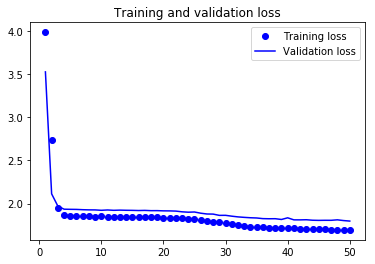

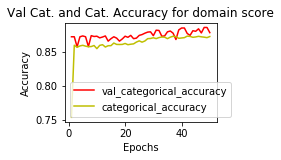

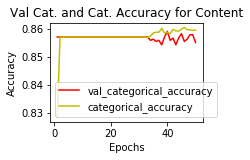

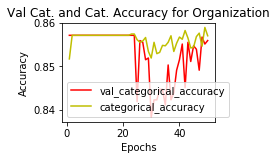

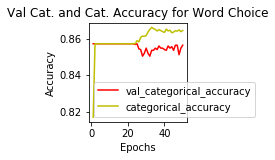

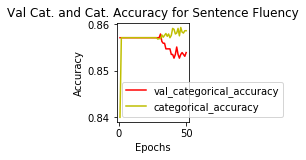

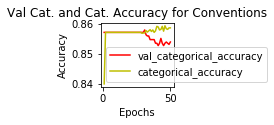

In [124]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score

'''
y_domain_score=X[['rater1_domain1']]
y_content=X[['Content']]
y_organization=X[['Organization']]
y_wordChoice=X[['Word Choice']]
y_sentenceFluency=X[['Sentence Fluency']]
y_conventions=X[['Conventions']]
'''

K.clear_session()

results = []
y_pred_list = []

count = 1
print(X.shape)
train_essays = X['essay']

sentences = []
for essay in train_essays:
        sentences += essay_to_sentences(essay, remove_stopwords = True)
        
# Initializing variables for word2vec model.
num_features = 300 
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

print("Training Word2Vec Model...")
model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,
                 window = context, sample = downsampling)

model.init_sims(replace=True)
model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

clean_train_essays = []

# Generate training and testing data word vectors.
for essay_v in train_essays:
    clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)

trainDataVecs = np.array(trainDataVecs)
print("trainDataVecs"+str(trainDataVecs.shape))

trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
validsiz=200

y_domain_score_c = to_categorical(y_domain_score)
y_content_c = to_categorical(y_content)
y_organization_c = to_categorical(y_organization)
y_wordChoice_c = to_categorical(y_wordChoice)
y_sentenceFluency_c = to_categorical(y_sentenceFluency)
y_conventions_c = to_categorical(y_conventions)
lstm_model = get_model()
history = lstm_model.fit(trainDataVecs,
                         y=[y_domain_score_c,y_content_c,y_organization_c,y_wordChoice_c
                             ,y_sentenceFluency_c,y_conventions_c] ,validation_split=0.2
                         ,batch_size=64, epochs=50)

print(history.history.keys())

if count == 1:
     lstm_model.save('final_lstm.h5')

import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.subplot(222)
valacc = history.history['val_dense_1_acc']
acc = history.history['dense_1_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for domain score')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplot(223)
valacc = history.history['val_dense_2_acc']
acc = history.history['dense_2_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for Content')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplot(224)
valacc = history.history['val_dense_3_acc']
acc = history.history['dense_3_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for Organization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplot(234)
valacc = history.history['val_dense_4_acc']
acc = history.history['dense_4_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for Word Choice')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplot(244)
valacc = history.history['val_dense_5_acc']
acc = history.history['dense_5_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for Sentence Fluency')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplot(344)
valacc = history.history['val_dense_5_acc']
acc = history.history['dense_5_acc']
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy for Conventions')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#break
count += 1


In [43]:
model = keras.models.load_model("final_lstm.h5")  # Load Keras model we learned using KerasPractice 
test = trainDataVecs[1:2]
test_p = y_train[1:2]
print(test_p)
model.predict(test)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


array([[1.8432736e-04, 6.3183904e-04, 5.1012635e-04, 2.4204850e-03,
        1.3749599e-03, 2.3709595e-02, 3.4940720e-02, 3.2466865e-01,
        2.4821348e-01, 2.5709864e-01, 8.0462538e-02, 2.5904387e-02]],
      dtype=float32)

In [45]:
X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.csv'), encoding='ISO-8859-1')
Xplus = pd.read_csv(os.path.join(DATASET_DIR, 'Prompt-1.csv'), encoding='ISO-8859-1')
X = (X[(X["essay_set"] == 1)])
#X = (X[(X["essay_set"] == 1)])
X = X.dropna(axis=1)
#newset = X.set_index('essay_id').join(Xplus.set_index('EssayID'))
newset =X.merge(Xplus,left_on='essay_id', right_on='EssayID')
print(newset.columns)
newset = newset[["essay_id","essay_set","essay", "rater1_domain1",'Content',
       'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions']]
newset.to_csv("essay_set1_merged.csv",index=False);

Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'domain1_score', 'domain1_score_copy', 'EssayID', 'Content',
       'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions'],
      dtype='object')
